# Generating images of houses with DCGAN

In this notebook I attempted to generate images that look like houses using a DCGAN. The last assignment required us to try to generate images with either a variational autoencoder or a GAN and I chose this. Unfortunately I didn't end up with anything satisfactory but it was still a good learning experience. I aim to improve this model later with more data and new techniques. 

In [1]:
import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.layers import Flatten, BatchNormalization, Dense, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [2]:
# Here is where we will load the dataset stored in dataset_path. In this script
# we will use the Caltech-UCSD Birds-200-2011 dataset which includes 11788
# images from 200 different birds. We will feed the images without applying
# the provided bounding boxes from the dataset. The data will only be resized
# and normalized. Keras ImageDataGenerator will be used for loading the dataset
def load_dataset(dataset_path, batch_size, image_shape):
    dataset_generator = ImageDataGenerator()
    dataset_generator = dataset_generator.flow_from_directory(
        dataset_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size,
        class_mode=None)

    return dataset_generator


# Creates the discriminator model. This model tries to classify images as real
# or fake.
def construct_discriminator(image_shape):

    discriminator = Sequential()
    discriminator.add(Conv2D(filters=64, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform',
                             input_shape=(image_shape)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(filters=128, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform'))
    discriminator.add(BatchNormalization(momentum=0.5))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(filters=256, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform'))
    discriminator.add(BatchNormalization(momentum=0.5))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(filters=512, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform'))
    discriminator.add(BatchNormalization(momentum=0.5))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

    return discriminator


# Creates the generator model. This model has an input of random noise and
# generates an image that will try mislead the discriminator.
def construct_generator():

    generator = Sequential()

    generator.add(Dense(units=4 * 4 * 512,
                        kernel_initializer='glorot_uniform',
                        input_shape=(1, 1, 100)))
    generator.add(Reshape(target_shape=(4, 4, 512)))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same',
                                  data_format='channels_last',
                                  kernel_initializer='glorot_uniform'))
    generator.add(Activation('tanh'))

    optimizer = Adam(lr=0.00015, beta_1=0.5)
    generator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=None)

    return generator


# Displays a figure of the generated images and saves them in as .png image
def save_generated_images(generated_images, epoch, batch_number):

    plt.figure(figsize=(8, 8), num=2)
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0, hspace=0)

    for i in range(50):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = generated_images[i, :, :, :]
        image += 1
        image *= 127.5
        fig = plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    save_name = 'generated images/generatedSamples_epoch' + str(
        epoch + 1) + '_batch' + str(batch_number + 1) + '.png'

    plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
    plt.pause(0.0000000001)
    plt.show()


# Main train function
def train_dcgan(batch_size, epochs, image_shape, dataset_path):
    # Build the adversarial model that consists in the generator output
    # connected to the discriminator
    generator = construct_generator()
    discriminator = construct_discriminator(image_shape)

    gan = Sequential()
    # Only false for the adversarial model
    discriminator.trainable = False
    gan.add(generator)
    gan.add(discriminator)

    optimizer = Adam(lr=0.00015, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer,
                metrics=None)

    # Create a dataset Generator with help of keras
    dataset_generator = load_dataset(dataset_path, batch_size, image_shape)

    # 11788 is the total number of images on the bird dataset
    number_of_batches = int(400 / batch_size)

    # Variables that will be used to plot the losses from the discriminator and
    # the adversarial models
    adversarial_loss = np.empty(shape=1)
    discriminator_loss = np.empty(shape=1)
    batches = np.empty(shape=1)

    # Allo plot updates inside for loop
    plt.ion()

    current_batch = 0

    # Let's train the DCGAN for n epochs
    for epoch in range(epochs):

        print("Epoch " + str(epoch+1) + "/" + str(epochs) + " :")

        for batch_number in range(number_of_batches):

            start_time = time.time()

            # Get the current batch and normalize the images between -1 and 1
            real_images = dataset_generator.next()
            real_images /= 127.5
            real_images -= 1

            # The last batch is smaller than the other ones, so we need to
            # take that into account
            current_batch_size = real_images.shape[0]

            # Generate noise
            noise = np.random.normal(0, 1,
                                     size=(current_batch_size,) + (1, 1, 100))

            # Generate images
            generated_images = generator.predict(noise)

            # Add some noise to the labels that will be
            # fed to the discriminator
            real_y = (np.ones(current_batch_size) -
                      np.random.random_sample(current_batch_size) * 0.2)
            fake_y = np.random.random_sample(current_batch_size) * 0.2

            # Let's train the discriminator
            discriminator.trainable = True

            d_loss = discriminator.train_on_batch(real_images, real_y)
            d_loss += discriminator.train_on_batch(generated_images, fake_y)

            discriminator_loss = np.append(discriminator_loss, d_loss)

            # Now it's time to train the generator
            discriminator.trainable = False

            noise = np.random.normal(0, 1,
                                     size=(current_batch_size * 2,) +
                                     (1, 1, 100))

            # We try to mislead the discriminator by giving the opposite labels
            fake_y = (np.ones(current_batch_size * 2) -
                      np.random.random_sample(current_batch_size * 2) * 0.2)

            g_loss = gan.train_on_batch(noise, fake_y)
            adversarial_loss = np.append(adversarial_loss, g_loss)
            batches = np.append(batches, current_batch)

            # Each 50 batches show and save images
            if((batch_number + 1) % 50 == 0 and
               current_batch_size == batch_size):
                save_generated_images(generated_images, epoch, batch_number)

            time_elapsed = time.time() - start_time

            # Display and plot the results
            print("     Batch " + str(batch_number + 1) + "/" +
                  str(number_of_batches) +
                  " generator loss | discriminator loss : " +
                  str(g_loss) + " | " + str(d_loss) + ' - batch took ' +
                  str(time_elapsed) + ' s.')

            current_batch += 1

        # Save the model weights each 5 epochs
        if (epoch + 1) % 5 == 0:
            discriminator.trainable = True
            generator.save('models/generator_epoch' + str(epoch) + '.hdf5')
            discriminator.save('models/discriminator_epoch' +
                               str(epoch) + '.hdf5')

        # Each epoch update the loss graphs
        plt.figure(1)
        plt.plot(batches, adversarial_loss, color='green',
                 label='Generator Loss')
        plt.plot(batches, discriminator_loss, color='blue',
                 label='Discriminator Loss')
        plt.title("DCGAN Train")
        plt.xlabel("Batch Iteration")
        plt.ylabel("Loss")
        if epoch == 0:
            plt.legend()
        plt.pause(0.0000000001)
        plt.show()
        plt.savefig('trainingLossPlot.png')






Instructions for updating:
Colocations handled automatically by placer.
Found 400 images belonging to 1 classes.
Epoch 1/190 :
Instructions for updating:
Use tf.cast instead.
     Batch 1/8 generator loss | discriminator loss : 3.8054876 | 6.434922 - batch took 16.3311665058136 s.
     Batch 2/8 generator loss | discriminator loss : 9.059606 | 1.9860672 - batch took 7.330466985702515 s.
     Batch 3/8 generator loss | discriminator loss : 4.9202166 | 1.7437048 - batch took 7.688139200210571 s.
     Batch 4/8 generator loss | discriminator loss : 10.06353 | 6.158291 - batch took 11.302987813949585 s.
     Batch 5/8 generator loss | discriminator loss : 7.829673 | 2.5427392 - batch took 8.839245557785034 s.
     Batch 6/8 generator loss | discriminator loss : 13.837135 | 3.1233854 - batch took 8.013457536697388 s.
     Batch 7/8 generator loss | discriminator loss : 14.515938 | 2.110487 - batch took 7.567479133605957 s.
     Batch 8/8 generator loss | discriminator loss : 8.665986 | 2.06

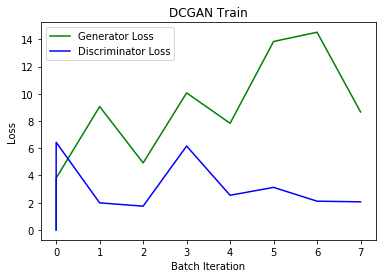

Epoch 2/190 :
     Batch 1/8 generator loss | discriminator loss : 14.150051 | 5.100662 - batch took 8.02337646484375 s.
     Batch 2/8 generator loss | discriminator loss : 14.624637 | 2.38984 - batch took 7.065557956695557 s.
     Batch 3/8 generator loss | discriminator loss : 14.410297 | 2.2152462 - batch took 6.964422702789307 s.
     Batch 4/8 generator loss | discriminator loss : 14.48491 | 2.326723 - batch took 6.712092638015747 s.
     Batch 5/8 generator loss | discriminator loss : 14.665225 | 2.2428715 - batch took 6.715080499649048 s.
     Batch 6/8 generator loss | discriminator loss : 14.502276 | 2.344524 - batch took 6.929514408111572 s.
     Batch 7/8 generator loss | discriminator loss : 14.433979 | 2.1665382 - batch took 6.583415508270264 s.
     Batch 8/8 generator loss | discriminator loss : 14.391677 | 1.7655224 - batch took 6.982374668121338 s.


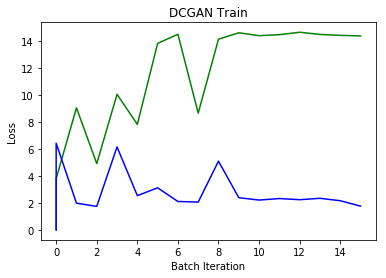

Epoch 3/190 :
     Batch 1/8 generator loss | discriminator loss : 14.590039 | 2.181181 - batch took 6.615343809127808 s.
     Batch 2/8 generator loss | discriminator loss : 14.54406 | 1.9102547 - batch took 6.760964632034302 s.
     Batch 3/8 generator loss | discriminator loss : 14.478145 | 2.0415003 - batch took 6.665216445922852 s.
     Batch 4/8 generator loss | discriminator loss : 14.4443 | 1.8691002 - batch took 7.09107780456543 s.
     Batch 5/8 generator loss | discriminator loss : 14.458005 | 1.9975551 - batch took 6.917546272277832 s.
     Batch 6/8 generator loss | discriminator loss : 14.472155 | 2.142557 - batch took 6.546547174453735 s.
     Batch 7/8 generator loss | discriminator loss : 14.416734 | 2.0080743 - batch took 6.851715803146362 s.
     Batch 8/8 generator loss | discriminator loss : 14.285762 | 2.0553265 - batch took 6.641284227371216 s.


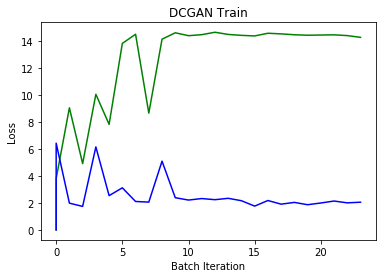

Epoch 4/190 :
     Batch 1/8 generator loss | discriminator loss : 14.505257 | 2.0402076 - batch took 7.072126150131226 s.
     Batch 2/8 generator loss | discriminator loss : 14.449918 | 1.7411215 - batch took 6.7549779415130615 s.
     Batch 3/8 generator loss | discriminator loss : 14.479548 | 1.9128432 - batch took 6.49965500831604 s.
     Batch 4/8 generator loss | discriminator loss : 14.569305 | 2.250173 - batch took 6.829784631729126 s.
     Batch 5/8 generator loss | discriminator loss : 14.388845 | 1.8613236 - batch took 6.830779075622559 s.
     Batch 6/8 generator loss | discriminator loss : 14.318739 | 1.9706819 - batch took 6.871667861938477 s.
     Batch 7/8 generator loss | discriminator loss : 14.392195 | 1.899506 - batch took 6.57745623588562 s.
     Batch 8/8 generator loss | discriminator loss : 14.462566 | 1.9677066 - batch took 7.091078042984009 s.


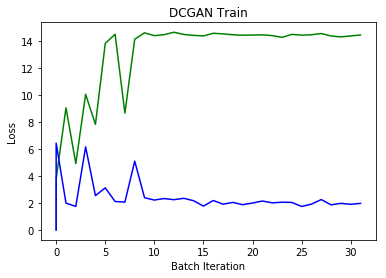

Epoch 5/190 :
     Batch 1/8 generator loss | discriminator loss : 14.424612 | 1.880689 - batch took 7.0721399784088135 s.
     Batch 2/8 generator loss | discriminator loss : 14.688147 | 2.2650833 - batch took 7.911894083023071 s.
     Batch 3/8 generator loss | discriminator loss : 14.541998 | 2.2597446 - batch took 7.475053071975708 s.
     Batch 4/8 generator loss | discriminator loss : 14.413606 | 2.424116 - batch took 7.420608997344971 s.
     Batch 5/8 generator loss | discriminator loss : 14.350373 | 2.100762 - batch took 6.902004957199097 s.
     Batch 6/8 generator loss | discriminator loss : 14.458264 | 2.1367192 - batch took 7.170610427856445 s.
     Batch 7/8 generator loss | discriminator loss : 14.438347 | 1.805614 - batch took 7.6353466510772705 s.
     Batch 8/8 generator loss | discriminator loss : 14.418887 | 2.0186737 - batch took 6.688832998275757 s.


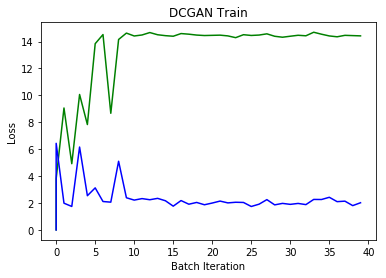

Epoch 6/190 :
     Batch 1/8 generator loss | discriminator loss : 14.350151 | 1.8496343 - batch took 7.106558322906494 s.
     Batch 2/8 generator loss | discriminator loss : 14.48285 | 2.1800683 - batch took 6.807752847671509 s.
     Batch 3/8 generator loss | discriminator loss : 14.499275 | 2.0409496 - batch took 7.174432277679443 s.
     Batch 4/8 generator loss | discriminator loss : 14.598806 | 2.0317688 - batch took 6.873260259628296 s.
     Batch 5/8 generator loss | discriminator loss : 14.535 | 2.1696115 - batch took 7.086987495422363 s.
     Batch 6/8 generator loss | discriminator loss : 14.563545 | 1.7940907 - batch took 6.920643329620361 s.
     Batch 7/8 generator loss | discriminator loss : 14.654535 | 1.9339166 - batch took 6.91521954536438 s.
     Batch 8/8 generator loss | discriminator loss : 14.341313 | 2.053299 - batch took 6.721246719360352 s.


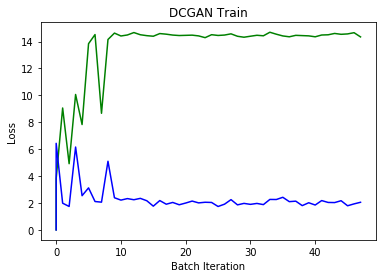

Epoch 7/190 :
     Batch 1/8 generator loss | discriminator loss : 14.468738 | 2.2359939 - batch took 7.1518003940582275 s.
     Batch 2/8 generator loss | discriminator loss : 14.482469 | 2.023443 - batch took 7.152909755706787 s.
     Batch 3/8 generator loss | discriminator loss : 14.559556 | 1.9106317 - batch took 6.934429407119751 s.
     Batch 4/8 generator loss | discriminator loss : 14.374556 | 1.8933015 - batch took 7.222439527511597 s.
     Batch 5/8 generator loss | discriminator loss : 14.423956 | 1.8820772 - batch took 6.91488242149353 s.
     Batch 6/8 generator loss | discriminator loss : 14.467686 | 1.9226319 - batch took 6.899338722229004 s.
     Batch 7/8 generator loss | discriminator loss : 14.502881 | 2.0575767 - batch took 6.786295413970947 s.
     Batch 8/8 generator loss | discriminator loss : 14.514929 | 1.6662512 - batch took 7.0438196659088135 s.


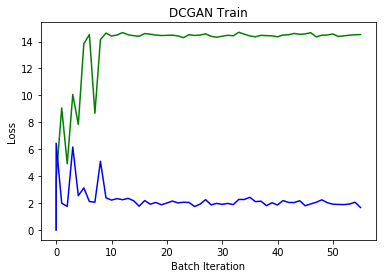

Epoch 8/190 :
     Batch 1/8 generator loss | discriminator loss : 14.607936 | 1.8676147 - batch took 7.116858243942261 s.
     Batch 2/8 generator loss | discriminator loss : 14.465669 | 1.8953476 - batch took 6.610787868499756 s.
     Batch 3/8 generator loss | discriminator loss : 14.452799 | 2.0876877 - batch took 7.241859197616577 s.
     Batch 4/8 generator loss | discriminator loss : 14.369126 | 2.030774 - batch took 6.868530750274658 s.
     Batch 5/8 generator loss | discriminator loss : 14.403272 | 1.8221443 - batch took 7.6896653175354 s.
     Batch 6/8 generator loss | discriminator loss : 14.451316 | 1.8911796 - batch took 8.36990761756897 s.
     Batch 7/8 generator loss | discriminator loss : 14.5988455 | 1.9561524 - batch took 9.365335702896118 s.
     Batch 8/8 generator loss | discriminator loss : 14.626698 | 1.9775552 - batch took 7.37392783164978 s.


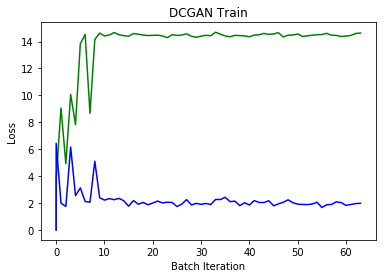

Epoch 9/190 :
     Batch 1/8 generator loss | discriminator loss : 14.563313 | 1.9230813 - batch took 7.022926330566406 s.
     Batch 2/8 generator loss | discriminator loss : 14.50664 | 1.9511344 - batch took 7.180753707885742 s.
     Batch 3/8 generator loss | discriminator loss : 14.524109 | 1.9318128 - batch took 6.887305498123169 s.
     Batch 4/8 generator loss | discriminator loss : 14.536992 | 1.8234402 - batch took 6.951449155807495 s.
     Batch 5/8 generator loss | discriminator loss : 14.365688 | 1.9489212 - batch took 6.974290370941162 s.
     Batch 6/8 generator loss | discriminator loss : 14.491427 | 1.8674439 - batch took 7.167532444000244 s.
     Batch 7/8 generator loss | discriminator loss : 14.5144205 | 2.2374618 - batch took 6.924471378326416 s.
     Batch 8/8 generator loss | discriminator loss : 14.486935 | 1.8559077 - batch took 7.732985258102417 s.


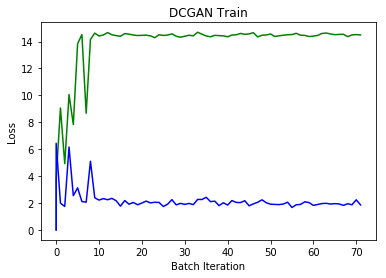

Epoch 10/190 :
     Batch 1/8 generator loss | discriminator loss : 14.453346 | 2.2153354 - batch took 6.899556875228882 s.
     Batch 2/8 generator loss | discriminator loss : 14.515018 | 1.7316132 - batch took 7.2093260288238525 s.
     Batch 3/8 generator loss | discriminator loss : 14.423618 | 1.8776078 - batch took 6.60136342048645 s.
     Batch 4/8 generator loss | discriminator loss : 14.568669 | 2.1985614 - batch took 7.056320667266846 s.
     Batch 5/8 generator loss | discriminator loss : 14.552246 | 2.1162531 - batch took 7.411192417144775 s.
     Batch 6/8 generator loss | discriminator loss : 14.666906 | 1.9224455 - batch took 6.749232769012451 s.
     Batch 7/8 generator loss | discriminator loss : 14.502042 | 2.123237 - batch took 6.92652440071106 s.
     Batch 8/8 generator loss | discriminator loss : 14.408161 | 1.8724831 - batch took 6.496752500534058 s.


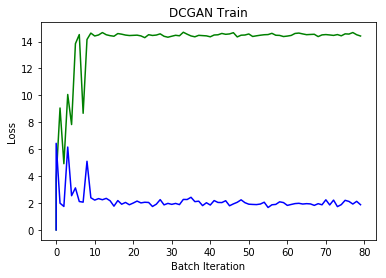

Epoch 11/190 :
     Batch 1/8 generator loss | discriminator loss : 14.529586 | 1.8197105 - batch took 7.093271493911743 s.
     Batch 2/8 generator loss | discriminator loss : 14.4617 | 2.270947 - batch took 6.620681047439575 s.
     Batch 3/8 generator loss | discriminator loss : 14.568082 | 2.1631653 - batch took 7.384448528289795 s.
     Batch 4/8 generator loss | discriminator loss : 14.497285 | 2.06811 - batch took 6.9590537548065186 s.
     Batch 5/8 generator loss | discriminator loss : 14.688214 | 1.8976407 - batch took 6.66741943359375 s.
     Batch 6/8 generator loss | discriminator loss : 14.504866 | 1.9060857 - batch took 6.755805253982544 s.
     Batch 7/8 generator loss | discriminator loss : 14.425989 | 1.9899275 - batch took 6.886318206787109 s.
     Batch 8/8 generator loss | discriminator loss : 14.505745 | 1.9698708 - batch took 6.731092214584351 s.


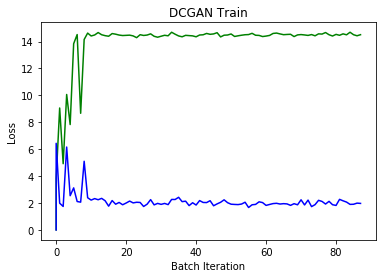

Epoch 12/190 :
     Batch 1/8 generator loss | discriminator loss : 14.599131 | 1.9941818 - batch took 6.633198976516724 s.
     Batch 2/8 generator loss | discriminator loss : 14.542311 | 2.0286372 - batch took 7.438342571258545 s.
     Batch 3/8 generator loss | discriminator loss : 14.542156 | 2.155803 - batch took 9.55150032043457 s.
     Batch 4/8 generator loss | discriminator loss : 14.523752 | 2.1968617 - batch took 7.6026930809021 s.
     Batch 5/8 generator loss | discriminator loss : 14.640042 | 2.0329869 - batch took 9.185746192932129 s.
     Batch 6/8 generator loss | discriminator loss : 14.60887 | 1.9767076 - batch took 8.567925453186035 s.
     Batch 7/8 generator loss | discriminator loss : 14.477735 | 1.9410444 - batch took 8.10815954208374 s.
     Batch 8/8 generator loss | discriminator loss : 4.361435 | 1.6335073 - batch took 8.258151054382324 s.


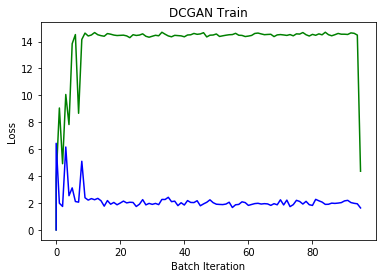

Epoch 13/190 :
     Batch 1/8 generator loss | discriminator loss : 14.326259 | 10.64959 - batch took 8.459286212921143 s.
     Batch 2/8 generator loss | discriminator loss : 14.46419 | 4.7747087 - batch took 8.005737066268921 s.
     Batch 3/8 generator loss | discriminator loss : 14.429862 | 2.2514079 - batch took 7.8217432498931885 s.
     Batch 4/8 generator loss | discriminator loss : 14.476807 | 2.3184595 - batch took 8.506774663925171 s.
     Batch 5/8 generator loss | discriminator loss : 14.511055 | 2.3339458 - batch took 8.270452499389648 s.
     Batch 6/8 generator loss | discriminator loss : 14.593717 | 2.0997703 - batch took 8.977337121963501 s.
     Batch 7/8 generator loss | discriminator loss : 14.466191 | 2.1439323 - batch took 8.37762188911438 s.
     Batch 8/8 generator loss | discriminator loss : 14.459057 | 1.7754078 - batch took 9.146241188049316 s.


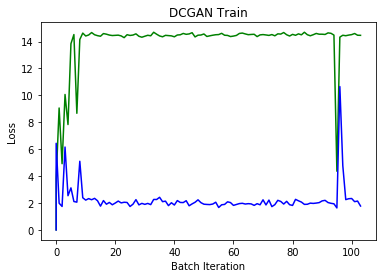

Epoch 14/190 :
     Batch 1/8 generator loss | discriminator loss : 14.432979 | 2.006291 - batch took 9.091277122497559 s.
     Batch 2/8 generator loss | discriminator loss : 14.433616 | 1.7695777 - batch took 9.282919883728027 s.
     Batch 3/8 generator loss | discriminator loss : 14.473208 | 1.8109124 - batch took 10.98442792892456 s.
     Batch 4/8 generator loss | discriminator loss : 14.510055 | 1.8067762 - batch took 9.758161783218384 s.
     Batch 5/8 generator loss | discriminator loss : 14.641158 | 1.8951478 - batch took 9.098810911178589 s.
     Batch 6/8 generator loss | discriminator loss : 14.487526 | 2.1191797 - batch took 8.789643287658691 s.
     Batch 7/8 generator loss | discriminator loss : 14.55811 | 2.2248504 - batch took 9.035355806350708 s.
     Batch 8/8 generator loss | discriminator loss : 14.6430025 | 1.874977 - batch took 7.235691547393799 s.


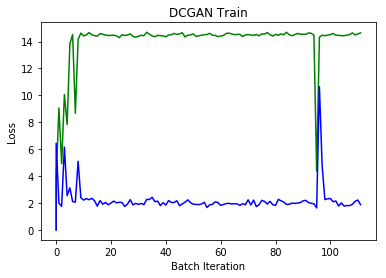

Epoch 15/190 :
     Batch 1/8 generator loss | discriminator loss : 14.385782 | 1.8226695 - batch took 8.319867134094238 s.
     Batch 2/8 generator loss | discriminator loss : 14.505313 | 2.113646 - batch took 8.872366666793823 s.
     Batch 3/8 generator loss | discriminator loss : 14.555927 | 2.0401087 - batch took 7.011897087097168 s.
     Batch 4/8 generator loss | discriminator loss : 14.517334 | 1.9124318 - batch took 7.1408703327178955 s.
     Batch 5/8 generator loss | discriminator loss : 14.369776 | 1.8443776 - batch took 7.225868463516235 s.
     Batch 6/8 generator loss | discriminator loss : 14.533234 | 2.0636065 - batch took 6.980342149734497 s.
     Batch 7/8 generator loss | discriminator loss : 14.596317 | 1.9478967 - batch took 7.096497297286987 s.
     Batch 8/8 generator loss | discriminator loss : 14.407209 | 2.1257992 - batch took 6.936059951782227 s.


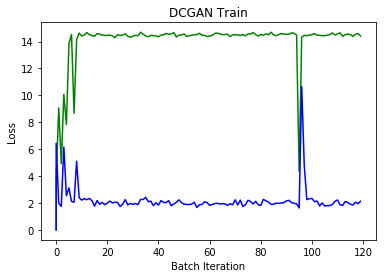

Epoch 16/190 :
     Batch 1/8 generator loss | discriminator loss : 14.359112 | 1.9006655 - batch took 7.3842644691467285 s.
     Batch 2/8 generator loss | discriminator loss : 14.417122 | 1.7430195 - batch took 7.03986930847168 s.
     Batch 3/8 generator loss | discriminator loss : 14.445317 | 2.0540104 - batch took 7.272690057754517 s.
     Batch 4/8 generator loss | discriminator loss : 14.3575735 | 1.9238296 - batch took 6.763004779815674 s.
     Batch 5/8 generator loss | discriminator loss : 14.5344515 | 2.1284 - batch took 7.1427624225616455 s.
     Batch 6/8 generator loss | discriminator loss : 14.452522 | 1.9397608 - batch took 6.640090227127075 s.
     Batch 7/8 generator loss | discriminator loss : 14.535371 | 2.0332828 - batch took 6.948396444320679 s.
     Batch 8/8 generator loss | discriminator loss : 14.260647 | 1.983463 - batch took 6.785398244857788 s.


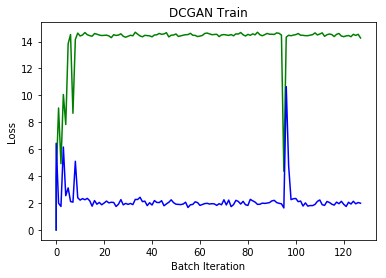

Epoch 17/190 :
     Batch 1/8 generator loss | discriminator loss : 14.392987 | 1.7692466 - batch took 6.828726291656494 s.
     Batch 2/8 generator loss | discriminator loss : 14.576015 | 2.1042647 - batch took 6.910227298736572 s.
     Batch 3/8 generator loss | discriminator loss : 14.580846 | 1.9370894 - batch took 6.864176034927368 s.
     Batch 4/8 generator loss | discriminator loss : 14.700813 | 2.184493 - batch took 7.422129154205322 s.
     Batch 5/8 generator loss | discriminator loss : 14.598772 | 2.029971 - batch took 7.087647438049316 s.
     Batch 6/8 generator loss | discriminator loss : 14.429157 | 2.0548356 - batch took 6.851048707962036 s.
     Batch 7/8 generator loss | discriminator loss : 14.598614 | 2.0105197 - batch took 6.9404144287109375 s.
     Batch 8/8 generator loss | discriminator loss : 14.471321 | 1.896497 - batch took 7.0215229988098145 s.


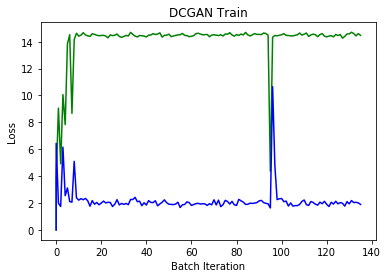

Epoch 18/190 :
     Batch 1/8 generator loss | discriminator loss : 14.554071 | 2.123785 - batch took 6.875542402267456 s.
     Batch 2/8 generator loss | discriminator loss : 14.487662 | 1.698604 - batch took 7.017422914505005 s.
     Batch 3/8 generator loss | discriminator loss : 14.576582 | 2.0640967 - batch took 7.16594386100769 s.
     Batch 4/8 generator loss | discriminator loss : 14.458196 | 1.7640712 - batch took 6.8273961544036865 s.
     Batch 5/8 generator loss | discriminator loss : 14.474922 | 2.051928 - batch took 7.047551155090332 s.
     Batch 6/8 generator loss | discriminator loss : 14.591184 | 1.987377 - batch took 6.881361722946167 s.
     Batch 7/8 generator loss | discriminator loss : 13.713637 | 1.8084562 - batch took 6.893133163452148 s.
     Batch 8/8 generator loss | discriminator loss : 3.0145388 | 1.246153 - batch took 7.074668884277344 s.


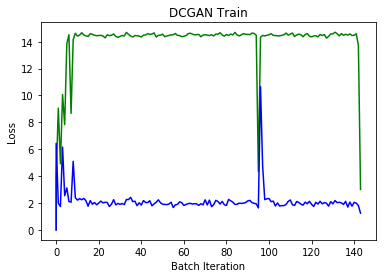

Epoch 19/190 :
     Batch 1/8 generator loss | discriminator loss : 13.054727 | 4.7545505 - batch took 6.685565233230591 s.
     Batch 2/8 generator loss | discriminator loss : 10.748457 | 4.0697174 - batch took 7.0079827308654785 s.
     Batch 3/8 generator loss | discriminator loss : 1.9982327 | 2.2167947 - batch took 6.8195250034332275 s.
     Batch 4/8 generator loss | discriminator loss : 5.6294904 | 2.039498 - batch took 7.148208141326904 s.
     Batch 5/8 generator loss | discriminator loss : 5.457448 | 1.515583 - batch took 6.85844874382019 s.
     Batch 6/8 generator loss | discriminator loss : 1.5602012 | 1.056727 - batch took 7.19492506980896 s.
     Batch 7/8 generator loss | discriminator loss : 7.308444 | 2.6039233 - batch took 6.891284704208374 s.
     Batch 8/8 generator loss | discriminator loss : 7.6488695 | 2.0877187 - batch took 6.810929775238037 s.


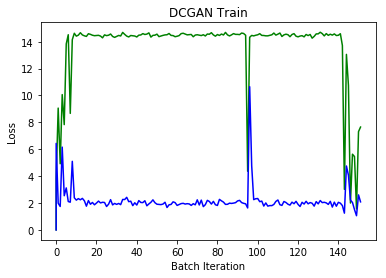

Epoch 20/190 :
     Batch 1/8 generator loss | discriminator loss : 2.6187418 | 1.338428 - batch took 7.23061728477478 s.
     Batch 2/8 generator loss | discriminator loss : 4.743248 | 1.4629056 - batch took 6.7485833168029785 s.
     Batch 3/8 generator loss | discriminator loss : 4.7223506 | 1.0534362 - batch took 7.121529817581177 s.
     Batch 4/8 generator loss | discriminator loss : 1.0445795 | 1.0691024 - batch took 7.02041220664978 s.
     Batch 5/8 generator loss | discriminator loss : 10.440265 | 2.6895587 - batch took 7.0250091552734375 s.
     Batch 6/8 generator loss | discriminator loss : 11.11741 | 1.9190013 - batch took 7.168303966522217 s.
     Batch 7/8 generator loss | discriminator loss : 3.4479918 | 1.581599 - batch took 6.70977783203125 s.
     Batch 8/8 generator loss | discriminator loss : 4.955168 | 2.2747788 - batch took 6.862957954406738 s.


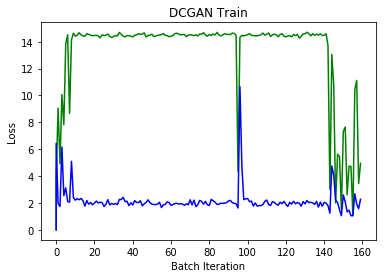

Epoch 21/190 :
     Batch 1/8 generator loss | discriminator loss : 5.315829 | 1.3813415 - batch took 7.019374370574951 s.
     Batch 2/8 generator loss | discriminator loss : 2.74927 | 1.23754 - batch took 6.980053663253784 s.
     Batch 3/8 generator loss | discriminator loss : 2.0639355 | 0.8869189 - batch took 6.911074876785278 s.
     Batch 4/8 generator loss | discriminator loss : 2.2491877 | 0.8424567 - batch took 7.104453086853027 s.
     Batch 5/8 generator loss | discriminator loss : 2.2052455 | 0.7318311 - batch took 7.139623165130615 s.
     Batch 6/8 generator loss | discriminator loss : 2.5742981 | 0.83711874 - batch took 6.975311994552612 s.
     Batch 7/8 generator loss | discriminator loss : 2.2454903 | 0.773932 - batch took 6.881358623504639 s.
     Batch 8/8 generator loss | discriminator loss : 4.1576176 | 0.8983895 - batch took 6.729151248931885 s.


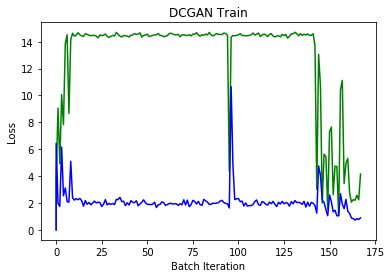

Epoch 22/190 :
     Batch 1/8 generator loss | discriminator loss : 2.974844 | 0.9530959 - batch took 6.86741828918457 s.
     Batch 2/8 generator loss | discriminator loss : 5.0930877 | 1.170085 - batch took 7.232914686203003 s.
     Batch 3/8 generator loss | discriminator loss : 2.0365396 | 1.1435361 - batch took 6.952543258666992 s.
     Batch 4/8 generator loss | discriminator loss : 8.024356 | 5.8561354 - batch took 6.830102205276489 s.
     Batch 5/8 generator loss | discriminator loss : 10.62456 | 1.8618147 - batch took 7.085989952087402 s.
     Batch 6/8 generator loss | discriminator loss : 7.1670713 | 1.9514147 - batch took 6.890493631362915 s.
     Batch 7/8 generator loss | discriminator loss : 2.0676086 | 1.2132823 - batch took 6.832999229431152 s.
     Batch 8/8 generator loss | discriminator loss : 5.744364 | 1.5260844 - batch took 6.96755313873291 s.


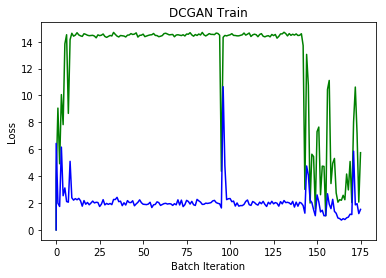

Epoch 23/190 :
     Batch 1/8 generator loss | discriminator loss : 7.5317287 | 1.3216428 - batch took 6.64572286605835 s.
     Batch 2/8 generator loss | discriminator loss : 2.193483 | 0.99391305 - batch took 6.904937982559204 s.
     Batch 3/8 generator loss | discriminator loss : 7.0738316 | 4.720591 - batch took 6.898334980010986 s.
     Batch 4/8 generator loss | discriminator loss : 10.538719 | 1.7046375 - batch took 6.995852708816528 s.
     Batch 5/8 generator loss | discriminator loss : 6.3440547 | 1.8328326 - batch took 6.981195449829102 s.
     Batch 6/8 generator loss | discriminator loss : 4.4770665 | 1.2900159 - batch took 6.881519556045532 s.
     Batch 7/8 generator loss | discriminator loss : 2.7540271 | 1.1699607 - batch took 6.916712999343872 s.
     Batch 8/8 generator loss | discriminator loss : 5.941677 | 2.0245514 - batch took 6.809757709503174 s.


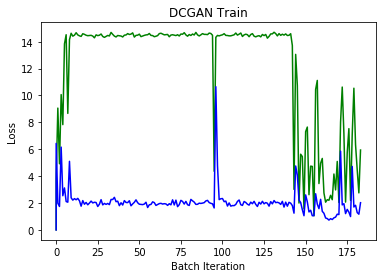

Epoch 24/190 :
     Batch 1/8 generator loss | discriminator loss : 3.8046954 | 1.2599336 - batch took 7.320575475692749 s.
     Batch 2/8 generator loss | discriminator loss : 3.2342136 | 1.7803941 - batch took 6.730917930603027 s.
     Batch 3/8 generator loss | discriminator loss : 3.361717 | 1.4147315 - batch took 7.01433253288269 s.
     Batch 4/8 generator loss | discriminator loss : 1.6200005 | 1.0660634 - batch took 6.9101197719573975 s.
     Batch 5/8 generator loss | discriminator loss : 2.060531 | 1.1093283 - batch took 6.972944259643555 s.
     Batch 6/8 generator loss | discriminator loss : 2.23091 | 1.0482665 - batch took 6.982264041900635 s.
     Batch 7/8 generator loss | discriminator loss : 2.2835615 | 0.9016653 - batch took 6.852392196655273 s.
     Batch 8/8 generator loss | discriminator loss : 2.4941833 | 1.194898 - batch took 6.998934984207153 s.


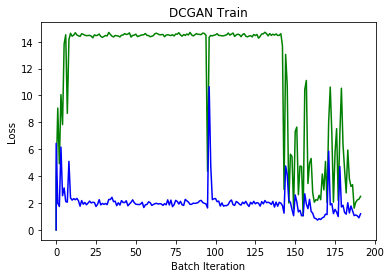

Epoch 25/190 :
     Batch 1/8 generator loss | discriminator loss : 2.6515675 | 0.9687518 - batch took 6.804366111755371 s.
     Batch 2/8 generator loss | discriminator loss : 2.9126453 | 1.1403744 - batch took 6.994254112243652 s.
     Batch 3/8 generator loss | discriminator loss : 2.789555 | 0.9292531 - batch took 7.0491297245025635 s.
     Batch 4/8 generator loss | discriminator loss : 2.2561452 | 0.79511964 - batch took 7.5148985385894775 s.
     Batch 5/8 generator loss | discriminator loss : 2.2142553 | 0.7490545 - batch took 6.912683486938477 s.
     Batch 6/8 generator loss | discriminator loss : 2.1498802 | 0.70234156 - batch took 6.715785980224609 s.
     Batch 7/8 generator loss | discriminator loss : 2.200062 | 0.7420883 - batch took 6.875299692153931 s.
     Batch 8/8 generator loss | discriminator loss : 2.3932624 | 0.7261394 - batch took 6.818850994110107 s.


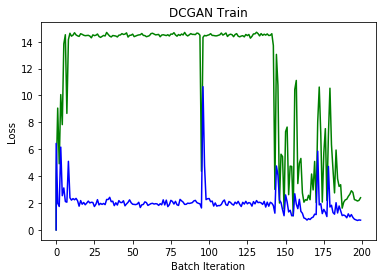

Epoch 26/190 :
     Batch 1/8 generator loss | discriminator loss : 3.1460156 | 0.78998506 - batch took 7.166193723678589 s.
     Batch 2/8 generator loss | discriminator loss : 2.3914797 | 0.8433103 - batch took 7.13201379776001 s.
     Batch 3/8 generator loss | discriminator loss : 3.2965717 | 1.0916532 - batch took 6.961478233337402 s.
     Batch 4/8 generator loss | discriminator loss : 2.546981 | 0.86674523 - batch took 6.900038242340088 s.
     Batch 5/8 generator loss | discriminator loss : 3.0687945 | 0.97148514 - batch took 7.092124700546265 s.
     Batch 6/8 generator loss | discriminator loss : 2.6788342 | 0.89775324 - batch took 6.7913978099823 s.
     Batch 7/8 generator loss | discriminator loss : 2.3238962 | 0.81072956 - batch took 6.841291904449463 s.
     Batch 8/8 generator loss | discriminator loss : 2.2765975 | 0.7532996 - batch took 7.101694345474243 s.


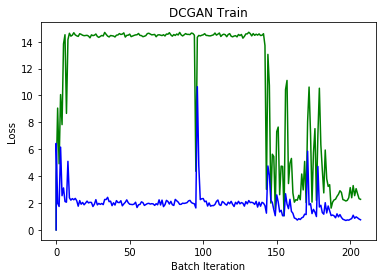

Epoch 27/190 :
     Batch 1/8 generator loss | discriminator loss : 2.7139819 | 0.76863444 - batch took 7.176407337188721 s.
     Batch 2/8 generator loss | discriminator loss : 2.2582564 | 0.79933715 - batch took 7.029592037200928 s.
     Batch 3/8 generator loss | discriminator loss : 3.0865815 | 0.85310566 - batch took 7.08880352973938 s.
     Batch 4/8 generator loss | discriminator loss : 2.629755 | 0.8154067 - batch took 7.6496171951293945 s.
     Batch 5/8 generator loss | discriminator loss : 3.5497637 | 1.0765123 - batch took 7.389103889465332 s.
     Batch 6/8 generator loss | discriminator loss : 2.212097 | 0.78282934 - batch took 7.0880279541015625 s.
     Batch 7/8 generator loss | discriminator loss : 2.2449145 | 1.1324055 - batch took 6.806241273880005 s.
     Batch 8/8 generator loss | discriminator loss : 2.1954582 | 0.8111267 - batch took 6.772188901901245 s.


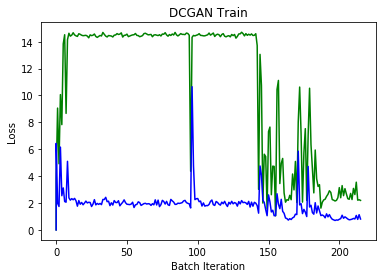

Epoch 28/190 :
     Batch 1/8 generator loss | discriminator loss : 2.4911022 | 1.2277955 - batch took 7.051161766052246 s.
     Batch 2/8 generator loss | discriminator loss : 2.196395 | 1.1011777 - batch took 6.892826318740845 s.
     Batch 3/8 generator loss | discriminator loss : 2.4278698 | 0.95571923 - batch took 6.902344465255737 s.
     Batch 4/8 generator loss | discriminator loss : 1.9983754 | 0.7745725 - batch took 6.73205304145813 s.
     Batch 5/8 generator loss | discriminator loss : 2.2202752 | 0.8887625 - batch took 7.076674461364746 s.
     Batch 6/8 generator loss | discriminator loss : 2.1034393 | 0.90251476 - batch took 7.030236005783081 s.
     Batch 7/8 generator loss | discriminator loss : 2.1438046 | 0.8927351 - batch took 6.776983737945557 s.
     Batch 8/8 generator loss | discriminator loss : 1.9736755 | 0.8158428 - batch took 7.126119613647461 s.


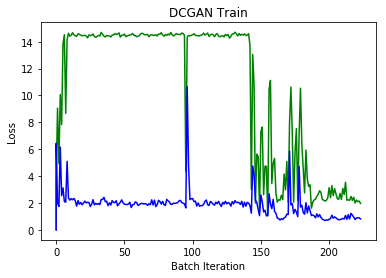

Epoch 29/190 :
     Batch 1/8 generator loss | discriminator loss : 2.0059006 | 0.8755494 - batch took 6.75999116897583 s.
     Batch 2/8 generator loss | discriminator loss : 2.1055176 | 0.96531403 - batch took 7.492268085479736 s.
     Batch 3/8 generator loss | discriminator loss : 2.0175953 | 0.9512147 - batch took 6.825730800628662 s.
     Batch 4/8 generator loss | discriminator loss : 2.031083 | 0.95890945 - batch took 6.945819139480591 s.
     Batch 5/8 generator loss | discriminator loss : 2.1318033 | 1.3137479 - batch took 6.967393398284912 s.
     Batch 6/8 generator loss | discriminator loss : 2.0226448 | 1.0248448 - batch took 7.0311439037323 s.
     Batch 7/8 generator loss | discriminator loss : 2.2415087 | 0.82358515 - batch took 7.198992490768433 s.
     Batch 8/8 generator loss | discriminator loss : 1.9807348 | 0.79518497 - batch took 6.801367521286011 s.


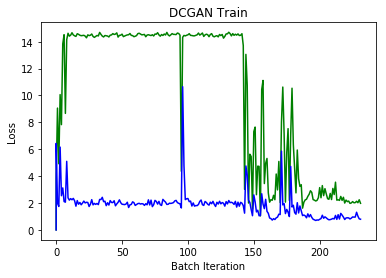

Epoch 30/190 :
     Batch 1/8 generator loss | discriminator loss : 2.5280647 | 0.8990501 - batch took 6.991060256958008 s.
     Batch 2/8 generator loss | discriminator loss : 2.0178924 | 0.84127325 - batch took 6.7277514934539795 s.
     Batch 3/8 generator loss | discriminator loss : 1.9478183 | 0.86075556 - batch took 7.528934717178345 s.
     Batch 4/8 generator loss | discriminator loss : 2.1743786 | 0.9057324 - batch took 6.898159027099609 s.
     Batch 5/8 generator loss | discriminator loss : 2.1905437 | 0.75974655 - batch took 7.011181354522705 s.
     Batch 6/8 generator loss | discriminator loss : 1.935948 | 0.7576854 - batch took 6.833431720733643 s.
     Batch 7/8 generator loss | discriminator loss : 2.4067123 | 0.7620011 - batch took 6.962780475616455 s.
     Batch 8/8 generator loss | discriminator loss : 2.0223482 | 0.81480265 - batch took 7.065845489501953 s.


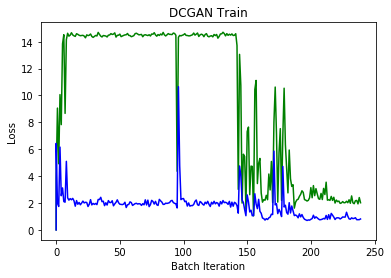

Epoch 31/190 :
     Batch 1/8 generator loss | discriminator loss : 2.1507542 | 0.80918664 - batch took 6.844926834106445 s.
     Batch 2/8 generator loss | discriminator loss : 2.1487715 | 0.7094798 - batch took 7.025503873825073 s.
     Batch 3/8 generator loss | discriminator loss : 2.2483544 | 0.9338764 - batch took 7.07746434211731 s.
     Batch 4/8 generator loss | discriminator loss : 2.1227798 | 0.8040352 - batch took 7.070298194885254 s.
     Batch 5/8 generator loss | discriminator loss : 2.0497653 | 0.78874743 - batch took 6.951354265213013 s.
     Batch 6/8 generator loss | discriminator loss : 2.5419395 | 0.7420796 - batch took 7.121442079544067 s.
     Batch 7/8 generator loss | discriminator loss : 2.6539538 | 0.8633573 - batch took 6.809988021850586 s.
     Batch 8/8 generator loss | discriminator loss : 1.7990683 | 0.8485607 - batch took 7.244600772857666 s.


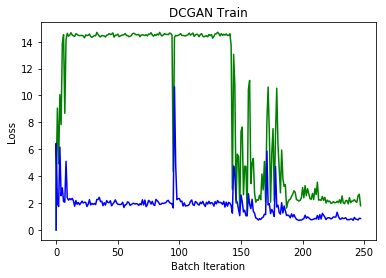

Epoch 32/190 :
     Batch 1/8 generator loss | discriminator loss : 3.351967 | 0.81122833 - batch took 6.87864089012146 s.
     Batch 2/8 generator loss | discriminator loss : 4.094321 | 1.7697062 - batch took 6.76526403427124 s.
     Batch 3/8 generator loss | discriminator loss : 2.3981276 | 1.0085425 - batch took 7.028228521347046 s.
     Batch 4/8 generator loss | discriminator loss : 3.7361975 | 1.1354556 - batch took 7.065507411956787 s.
     Batch 5/8 generator loss | discriminator loss : 1.7924806 | 1.1338719 - batch took 7.233603239059448 s.
     Batch 6/8 generator loss | discriminator loss : 1.8245772 | 0.8416927 - batch took 6.684039354324341 s.
     Batch 7/8 generator loss | discriminator loss : 2.0898578 | 0.7904172 - batch took 7.044013500213623 s.
     Batch 8/8 generator loss | discriminator loss : 2.0580902 | 0.9407555 - batch took 7.013430833816528 s.


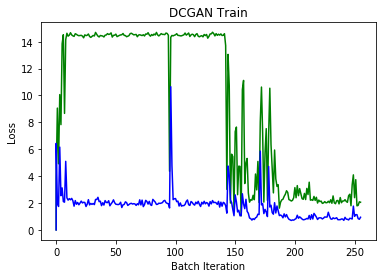

Epoch 33/190 :
     Batch 1/8 generator loss | discriminator loss : 2.1258428 | 1.0226684 - batch took 6.886183500289917 s.
     Batch 2/8 generator loss | discriminator loss : 3.284257 | 0.9549439 - batch took 7.103276014328003 s.
     Batch 3/8 generator loss | discriminator loss : 2.4889038 | 1.3014576 - batch took 6.835302352905273 s.
     Batch 4/8 generator loss | discriminator loss : 2.8482206 | 0.8886966 - batch took 7.219475269317627 s.
     Batch 5/8 generator loss | discriminator loss : 2.8489325 | 0.9560318 - batch took 7.121758460998535 s.
     Batch 6/8 generator loss | discriminator loss : 3.4819622 | 1.5102329 - batch took 7.051591396331787 s.
     Batch 7/8 generator loss | discriminator loss : 1.9621412 | 1.1513948 - batch took 6.7581024169921875 s.
     Batch 8/8 generator loss | discriminator loss : 2.2218137 | 0.9051906 - batch took 6.759153366088867 s.


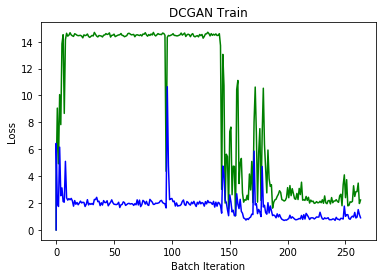

Epoch 34/190 :
     Batch 1/8 generator loss | discriminator loss : 2.1070592 | 0.81957996 - batch took 7.214414119720459 s.
     Batch 2/8 generator loss | discriminator loss : 3.329832 | 1.1502402 - batch took 6.874868154525757 s.
     Batch 3/8 generator loss | discriminator loss : 2.32475 | 1.0661438 - batch took 7.101889133453369 s.
     Batch 4/8 generator loss | discriminator loss : 4.628739 | 1.0068494 - batch took 6.670260906219482 s.
     Batch 5/8 generator loss | discriminator loss : 1.6108817 | 1.4830886 - batch took 7.194709062576294 s.
     Batch 6/8 generator loss | discriminator loss : 2.4000213 | 1.1500618 - batch took 6.783928155899048 s.
     Batch 7/8 generator loss | discriminator loss : 2.3021836 | 0.91013956 - batch took 6.9635093212127686 s.
     Batch 8/8 generator loss | discriminator loss : 2.4043014 | 1.055899 - batch took 6.8286943435668945 s.


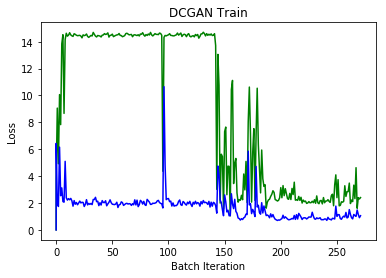

Epoch 35/190 :
     Batch 1/8 generator loss | discriminator loss : 2.826036 | 1.239604 - batch took 6.871262788772583 s.
     Batch 2/8 generator loss | discriminator loss : 3.033021 | 1.2646117 - batch took 7.110466241836548 s.
     Batch 3/8 generator loss | discriminator loss : 1.7349087 | 1.2774986 - batch took 6.702505350112915 s.
     Batch 4/8 generator loss | discriminator loss : 2.421052 | 0.87715065 - batch took 7.357758522033691 s.
     Batch 5/8 generator loss | discriminator loss : 2.347677 | 0.89735705 - batch took 6.696824550628662 s.
     Batch 6/8 generator loss | discriminator loss : 2.9026983 | 1.0475688 - batch took 7.160447597503662 s.
     Batch 7/8 generator loss | discriminator loss : 2.672107 | 0.99978995 - batch took 6.945129632949829 s.
     Batch 8/8 generator loss | discriminator loss : 3.5541852 | 1.2413945 - batch took 6.719865322113037 s.


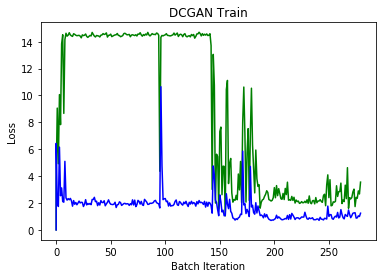

Epoch 36/190 :
     Batch 1/8 generator loss | discriminator loss : 1.8281573 | 1.0872738 - batch took 7.166637420654297 s.
     Batch 2/8 generator loss | discriminator loss : 4.4388695 | 1.5119678 - batch took 6.780522346496582 s.
     Batch 3/8 generator loss | discriminator loss : 2.0693483 | 1.4836292 - batch took 7.163235902786255 s.
     Batch 4/8 generator loss | discriminator loss : 3.6105652 | 1.2944552 - batch took 6.917026042938232 s.
     Batch 5/8 generator loss | discriminator loss : 2.4252224 | 1.1629156 - batch took 7.140595436096191 s.
     Batch 6/8 generator loss | discriminator loss : 3.2742023 | 1.2936687 - batch took 6.829003095626831 s.
     Batch 7/8 generator loss | discriminator loss : 2.7399707 | 1.0588065 - batch took 7.117830753326416 s.
     Batch 8/8 generator loss | discriminator loss : 3.325895 | 1.2976756 - batch took 7.201777219772339 s.


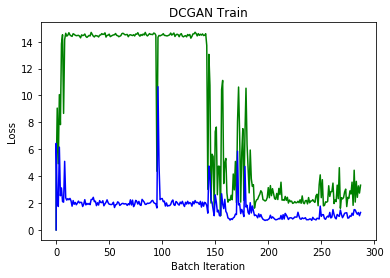

Epoch 37/190 :
     Batch 1/8 generator loss | discriminator loss : 2.4204454 | 0.92236525 - batch took 6.8069987297058105 s.
     Batch 2/8 generator loss | discriminator loss : 2.7047417 | 1.1183028 - batch took 7.028590679168701 s.
     Batch 3/8 generator loss | discriminator loss : 2.5513735 | 0.8240025 - batch took 6.917065382003784 s.
     Batch 4/8 generator loss | discriminator loss : 2.9566882 | 0.7838843 - batch took 7.026204824447632 s.
     Batch 5/8 generator loss | discriminator loss : 4.4179506 | 0.98020434 - batch took 6.868374347686768 s.
     Batch 6/8 generator loss | discriminator loss : 2.5883884 | 1.0677165 - batch took 7.224818468093872 s.
     Batch 7/8 generator loss | discriminator loss : 5.452984 | 1.3558046 - batch took 6.9336206912994385 s.
     Batch 8/8 generator loss | discriminator loss : 1.7221869 | 1.7507879 - batch took 6.888916492462158 s.


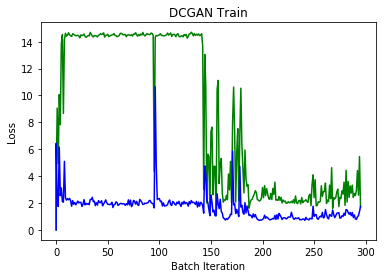

Epoch 38/190 :
     Batch 1/8 generator loss | discriminator loss : 2.4171922 | 1.2301258 - batch took 6.961286783218384 s.
     Batch 2/8 generator loss | discriminator loss : 2.4749644 | 0.784692 - batch took 7.098081350326538 s.
     Batch 3/8 generator loss | discriminator loss : 3.2530782 | 1.2314408 - batch took 7.174831390380859 s.
     Batch 4/8 generator loss | discriminator loss : 2.2007043 | 0.92010534 - batch took 7.0437331199646 s.
     Batch 5/8 generator loss | discriminator loss : 3.1549573 | 0.9926523 - batch took 7.275586843490601 s.
     Batch 6/8 generator loss | discriminator loss : 2.535513 | 1.0081607 - batch took 6.776766300201416 s.
     Batch 7/8 generator loss | discriminator loss : 3.002665 | 0.9714583 - batch took 7.228396415710449 s.
     Batch 8/8 generator loss | discriminator loss : 1.8253529 | 0.8067973 - batch took 7.022800445556641 s.


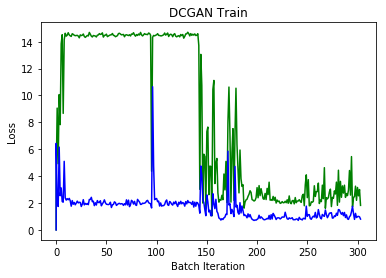

Epoch 39/190 :
     Batch 1/8 generator loss | discriminator loss : 2.8627775 | 1.0837302 - batch took 6.878367185592651 s.
     Batch 2/8 generator loss | discriminator loss : 2.0746467 | 0.80848503 - batch took 6.943089008331299 s.
     Batch 3/8 generator loss | discriminator loss : 2.8509521 | 1.088792 - batch took 6.884272575378418 s.
     Batch 4/8 generator loss | discriminator loss : 2.176978 | 1.2034471 - batch took 7.140116214752197 s.
     Batch 5/8 generator loss | discriminator loss : 3.1273506 | 0.8564114 - batch took 6.907401084899902 s.
     Batch 6/8 generator loss | discriminator loss : 2.2699473 | 0.7394284 - batch took 7.141907453536987 s.
     Batch 7/8 generator loss | discriminator loss : 4.1130977 | 1.5479715 - batch took 7.211500644683838 s.
     Batch 8/8 generator loss | discriminator loss : 1.7797973 | 1.5355233 - batch took 7.064366340637207 s.


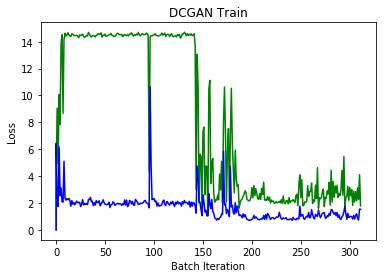

Epoch 40/190 :
     Batch 1/8 generator loss | discriminator loss : 2.7473779 | 1.0601275 - batch took 6.81445574760437 s.
     Batch 2/8 generator loss | discriminator loss : 2.3639638 | 0.8196894 - batch took 7.067174911499023 s.
     Batch 3/8 generator loss | discriminator loss : 2.3661196 | 1.2552338 - batch took 6.894405841827393 s.
     Batch 4/8 generator loss | discriminator loss : 2.13152 | 0.83210325 - batch took 6.86319637298584 s.
     Batch 5/8 generator loss | discriminator loss : 2.6667757 | 0.89158046 - batch took 7.066504001617432 s.
     Batch 6/8 generator loss | discriminator loss : 2.5242069 | 0.70442605 - batch took 6.796511173248291 s.
     Batch 7/8 generator loss | discriminator loss : 2.4160695 | 0.8888204 - batch took 7.035114526748657 s.
     Batch 8/8 generator loss | discriminator loss : 2.487093 | 0.78070295 - batch took 6.8541271686553955 s.


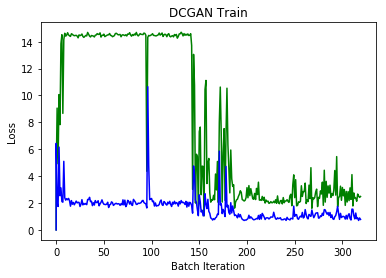

Epoch 41/190 :
     Batch 1/8 generator loss | discriminator loss : 4.0682874 | 1.048287 - batch took 7.083327531814575 s.
     Batch 2/8 generator loss | discriminator loss : 2.467115 | 1.054095 - batch took 6.876384258270264 s.
     Batch 3/8 generator loss | discriminator loss : 3.1165345 | 1.0225255 - batch took 6.983837366104126 s.
     Batch 4/8 generator loss | discriminator loss : 2.3378167 | 0.806099 - batch took 7.1087305545806885 s.
     Batch 5/8 generator loss | discriminator loss : 4.4498262 | 1.378236 - batch took 6.868240118026733 s.
     Batch 6/8 generator loss | discriminator loss : 2.891906 | 1.5241792 - batch took 7.0451788902282715 s.
     Batch 7/8 generator loss | discriminator loss : 2.3190672 | 1.0842483 - batch took 6.870554447174072 s.
     Batch 8/8 generator loss | discriminator loss : 2.3291445 | 0.8794762 - batch took 7.22582221031189 s.


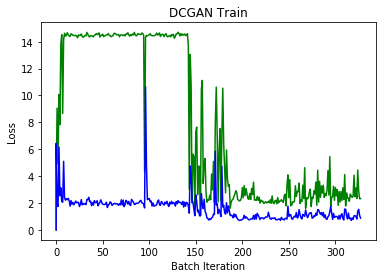

Epoch 42/190 :
     Batch 1/8 generator loss | discriminator loss : 2.661231 | 0.83663774 - batch took 7.103080749511719 s.
     Batch 2/8 generator loss | discriminator loss : 2.7187948 | 0.7022769 - batch took 6.990840673446655 s.
     Batch 3/8 generator loss | discriminator loss : 2.1422765 | 0.8022044 - batch took 6.899939060211182 s.
     Batch 4/8 generator loss | discriminator loss : 3.6910398 | 0.8232846 - batch took 6.9294068813323975 s.
     Batch 5/8 generator loss | discriminator loss : 1.9762125 | 1.0137818 - batch took 6.9326841831207275 s.
     Batch 6/8 generator loss | discriminator loss : 4.672063 | 0.9906891 - batch took 6.994796514511108 s.
     Batch 7/8 generator loss | discriminator loss : 2.8704793 | 1.1654246 - batch took 7.088770627975464 s.
     Batch 8/8 generator loss | discriminator loss : 3.4698246 | 0.9032186 - batch took 6.727313041687012 s.


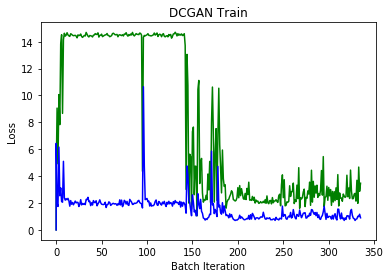

Epoch 43/190 :
     Batch 1/8 generator loss | discriminator loss : 2.468855 | 0.78388065 - batch took 6.9075446128845215 s.
     Batch 2/8 generator loss | discriminator loss : 2.8044055 | 0.9723575 - batch took 6.999299049377441 s.
     Batch 3/8 generator loss | discriminator loss : 2.471869 | 0.7580023 - batch took 6.847248077392578 s.
     Batch 4/8 generator loss | discriminator loss : 2.9103637 | 1.1020596 - batch took 6.935263395309448 s.
     Batch 5/8 generator loss | discriminator loss : 2.9647155 | 0.69598335 - batch took 6.99880313873291 s.
     Batch 6/8 generator loss | discriminator loss : 1.9929478 | 0.8235835 - batch took 7.1134655475616455 s.
     Batch 7/8 generator loss | discriminator loss : 3.0866935 | 0.84934354 - batch took 6.986125230789185 s.
     Batch 8/8 generator loss | discriminator loss : 2.4324148 | 0.78886116 - batch took 7.088569641113281 s.


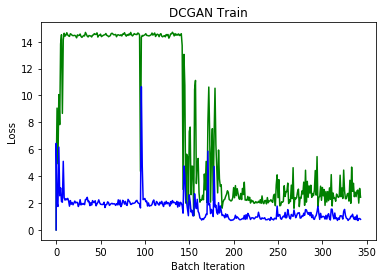

Epoch 44/190 :
     Batch 1/8 generator loss | discriminator loss : 3.0073917 | 0.9539485 - batch took 6.848038911819458 s.
     Batch 2/8 generator loss | discriminator loss : 2.420956 | 0.77355367 - batch took 7.135775327682495 s.
     Batch 3/8 generator loss | discriminator loss : 3.9333808 | 2.4488053 - batch took 7.0419840812683105 s.
     Batch 4/8 generator loss | discriminator loss : 2.162804 | 1.4266552 - batch took 6.844484806060791 s.
     Batch 5/8 generator loss | discriminator loss : 1.6614543 | 1.1170145 - batch took 6.9247071743011475 s.
     Batch 6/8 generator loss | discriminator loss : 1.7396255 | 0.8294618 - batch took 6.897077322006226 s.
     Batch 7/8 generator loss | discriminator loss : 1.8505492 | 0.8995997 - batch took 7.288556814193726 s.
     Batch 8/8 generator loss | discriminator loss : 2.132467 | 0.85581106 - batch took 6.952749490737915 s.


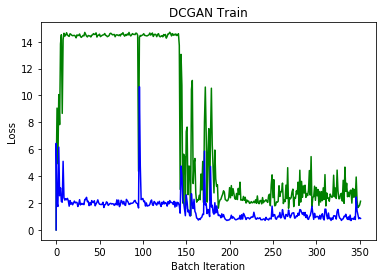

Epoch 45/190 :
     Batch 1/8 generator loss | discriminator loss : 2.031855 | 0.79070294 - batch took 6.865936040878296 s.
     Batch 2/8 generator loss | discriminator loss : 2.4764383 | 0.9187559 - batch took 7.021294593811035 s.
     Batch 3/8 generator loss | discriminator loss : 2.1223834 | 0.9321166 - batch took 6.7909996509552 s.
     Batch 4/8 generator loss | discriminator loss : 2.3328705 | 0.9008477 - batch took 7.1158528327941895 s.
     Batch 5/8 generator loss | discriminator loss : 2.8117206 | 0.85416025 - batch took 6.767454385757446 s.
     Batch 6/8 generator loss | discriminator loss : 2.1634223 | 0.74610984 - batch took 7.062666654586792 s.
     Batch 7/8 generator loss | discriminator loss : 4.224684 | 1.4426434 - batch took 6.620699644088745 s.
     Batch 8/8 generator loss | discriminator loss : 2.7979834 | 1.2330273 - batch took 7.5379228591918945 s.


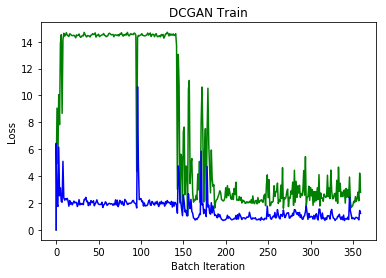

Epoch 46/190 :
     Batch 1/8 generator loss | discriminator loss : 2.1302366 | 0.83800304 - batch took 7.993245601654053 s.
     Batch 2/8 generator loss | discriminator loss : 2.8419654 | 0.8276106 - batch took 8.04634404182434 s.
     Batch 3/8 generator loss | discriminator loss : 2.1670809 | 0.80168295 - batch took 7.298379421234131 s.
     Batch 4/8 generator loss | discriminator loss : 2.9527607 | 1.0711269 - batch took 7.102359056472778 s.
     Batch 5/8 generator loss | discriminator loss : 2.2087033 | 0.9099825 - batch took 7.017901182174683 s.
     Batch 6/8 generator loss | discriminator loss : 2.599257 | 0.84319985 - batch took 6.820687532424927 s.
     Batch 7/8 generator loss | discriminator loss : 3.4171095 | 1.1049896 - batch took 7.186028003692627 s.
     Batch 8/8 generator loss | discriminator loss : 2.323364 | 1.0438106 - batch took 7.198646783828735 s.


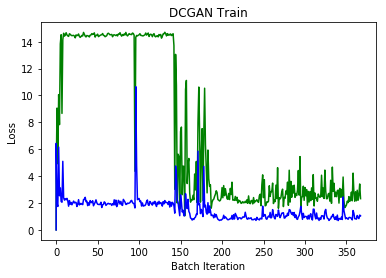

Epoch 47/190 :
     Batch 1/8 generator loss | discriminator loss : 4.075509 | 1.3412466 - batch took 7.2836689949035645 s.
     Batch 2/8 generator loss | discriminator loss : 3.2909205 | 1.0609645 - batch took 6.749354600906372 s.
     Batch 3/8 generator loss | discriminator loss : 1.8771744 | 0.83517206 - batch took 7.0932886600494385 s.
     Batch 4/8 generator loss | discriminator loss : 2.4896553 | 0.78656036 - batch took 6.7900354862213135 s.
     Batch 5/8 generator loss | discriminator loss : 2.3381424 | 0.7149143 - batch took 6.843082666397095 s.
     Batch 6/8 generator loss | discriminator loss : 1.88397 | 0.793651 - batch took 7.413235187530518 s.
     Batch 7/8 generator loss | discriminator loss : 2.6777859 | 0.8086401 - batch took 6.7575671672821045 s.
     Batch 8/8 generator loss | discriminator loss : 2.2263465 | 0.8555836 - batch took 7.105651378631592 s.


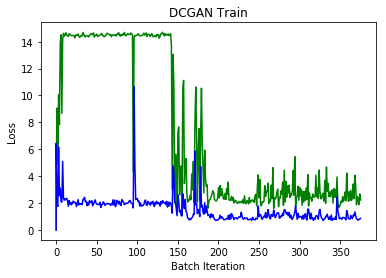

Epoch 48/190 :
     Batch 1/8 generator loss | discriminator loss : 2.6198156 | 0.8471229 - batch took 6.902432680130005 s.
     Batch 2/8 generator loss | discriminator loss : 2.6982734 | 0.76038754 - batch took 7.146852970123291 s.
     Batch 3/8 generator loss | discriminator loss : 2.8990493 | 0.859867 - batch took 6.710262060165405 s.
     Batch 4/8 generator loss | discriminator loss : 2.7721996 | 0.83095086 - batch took 7.001001834869385 s.
     Batch 5/8 generator loss | discriminator loss : 3.8451734 | 1.0041645 - batch took 7.120555400848389 s.
     Batch 6/8 generator loss | discriminator loss : 2.1876175 | 0.94835746 - batch took 6.8481903076171875 s.
     Batch 7/8 generator loss | discriminator loss : 4.111136 | 1.0460415 - batch took 6.792821168899536 s.
     Batch 8/8 generator loss | discriminator loss : 1.9673654 | 1.0722072 - batch took 6.890620946884155 s.


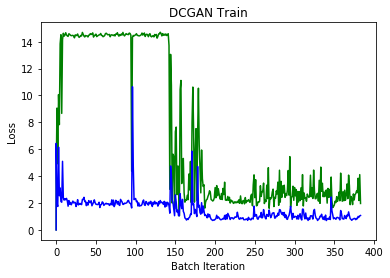

Epoch 49/190 :
     Batch 1/8 generator loss | discriminator loss : 3.9825556 | 1.0657715 - batch took 6.978508234024048 s.
     Batch 2/8 generator loss | discriminator loss : 3.2598524 | 0.9627 - batch took 6.924851417541504 s.
     Batch 3/8 generator loss | discriminator loss : 1.9209528 | 0.7803506 - batch took 7.033660650253296 s.
     Batch 4/8 generator loss | discriminator loss : 2.3931885 | 0.74356574 - batch took 6.921786785125732 s.
     Batch 5/8 generator loss | discriminator loss : 2.2555027 | 0.71854734 - batch took 6.845805883407593 s.
     Batch 6/8 generator loss | discriminator loss : 2.0963209 | 0.7505778 - batch took 7.330092668533325 s.
     Batch 7/8 generator loss | discriminator loss : 2.7501917 | 1.0256399 - batch took 6.726103782653809 s.
     Batch 8/8 generator loss | discriminator loss : 2.5816894 | 0.6966047 - batch took 6.866946220397949 s.


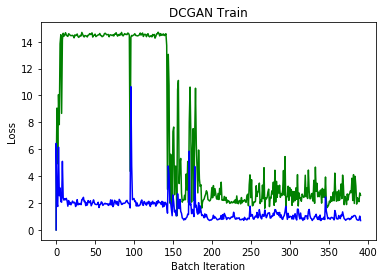

Epoch 50/190 :
     Batch 1/8 generator loss | discriminator loss : 1.887018 | 0.7546817 - batch took 7.115257024765015 s.
     Batch 2/8 generator loss | discriminator loss : 2.707039 | 0.91902 - batch took 7.084136486053467 s.
     Batch 3/8 generator loss | discriminator loss : 2.1310275 | 0.84462583 - batch took 6.899154186248779 s.
     Batch 4/8 generator loss | discriminator loss : 3.526778 | 1.1069334 - batch took 6.775491237640381 s.
     Batch 5/8 generator loss | discriminator loss : 2.2082303 | 1.0241663 - batch took 7.29806661605835 s.
     Batch 6/8 generator loss | discriminator loss : 2.973999 | 1.0337001 - batch took 7.45305609703064 s.
     Batch 7/8 generator loss | discriminator loss : 3.0126934 | 0.7704245 - batch took 7.120060205459595 s.
     Batch 8/8 generator loss | discriminator loss : 2.8755713 | 1.3459291 - batch took 6.835887908935547 s.


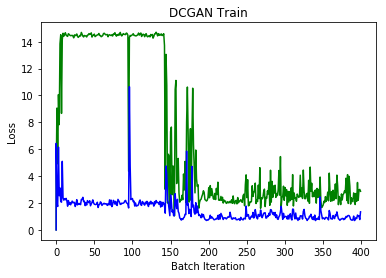

Epoch 51/190 :
     Batch 1/8 generator loss | discriminator loss : 2.3945518 | 0.88107157 - batch took 7.169742822647095 s.
     Batch 2/8 generator loss | discriminator loss : 2.5290377 | 0.73591864 - batch took 6.9509055614471436 s.
     Batch 3/8 generator loss | discriminator loss : 2.6119916 | 0.79336756 - batch took 7.255754470825195 s.
     Batch 4/8 generator loss | discriminator loss : 2.6881526 | 0.8307879 - batch took 6.7064597606658936 s.
     Batch 5/8 generator loss | discriminator loss : 2.5866637 | 0.80506444 - batch took 6.70791482925415 s.
     Batch 6/8 generator loss | discriminator loss : 3.2713656 | 0.8630457 - batch took 6.92535400390625 s.
     Batch 7/8 generator loss | discriminator loss : 2.654214 | 0.7650907 - batch took 6.858284950256348 s.
     Batch 8/8 generator loss | discriminator loss : 3.446202 | 0.85249543 - batch took 7.2205235958099365 s.


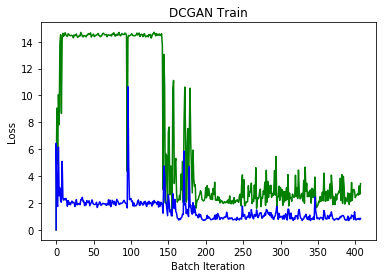

Epoch 52/190 :
     Batch 1/8 generator loss | discriminator loss : 2.3359363 | 0.81971 - batch took 6.75184965133667 s.
     Batch 2/8 generator loss | discriminator loss : 3.969041 | 0.9924978 - batch took 6.890887022018433 s.
     Batch 3/8 generator loss | discriminator loss : 2.9278991 | 0.9115526 - batch took 7.260066986083984 s.
     Batch 4/8 generator loss | discriminator loss : 1.9953856 | 0.8794733 - batch took 7.0632665157318115 s.
     Batch 5/8 generator loss | discriminator loss : 2.257708 | 0.7868402 - batch took 6.906491041183472 s.
     Batch 6/8 generator loss | discriminator loss : 2.5140424 | 0.74621785 - batch took 6.831517934799194 s.
     Batch 7/8 generator loss | discriminator loss : 2.3703094 | 0.71837986 - batch took 6.83562445640564 s.
     Batch 8/8 generator loss | discriminator loss : 2.861498 | 0.8365797 - batch took 6.917203187942505 s.


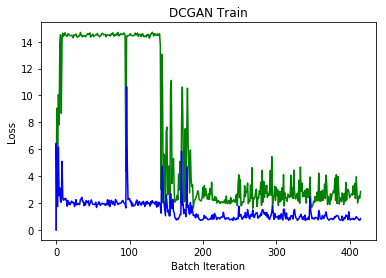

Epoch 53/190 :
     Batch 1/8 generator loss | discriminator loss : 2.0310972 | 0.8005964 - batch took 6.996312379837036 s.
     Batch 2/8 generator loss | discriminator loss : 3.1144505 | 0.8057482 - batch took 6.570896863937378 s.
     Batch 3/8 generator loss | discriminator loss : 2.4165125 | 0.83038247 - batch took 9.267084836959839 s.
     Batch 4/8 generator loss | discriminator loss : 2.5725214 | 0.88361275 - batch took 9.176477670669556 s.
     Batch 5/8 generator loss | discriminator loss : 2.7433288 | 0.7143056 - batch took 8.082642793655396 s.
     Batch 6/8 generator loss | discriminator loss : 2.2033024 | 0.85255456 - batch took 8.564018249511719 s.
     Batch 7/8 generator loss | discriminator loss : 3.9102514 | 0.8208026 - batch took 8.419713258743286 s.
     Batch 8/8 generator loss | discriminator loss : 2.3791056 | 0.952793 - batch took 7.833302974700928 s.


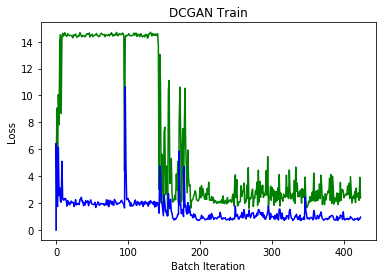

Epoch 54/190 :
     Batch 1/8 generator loss | discriminator loss : 4.3946447 | 1.0911822 - batch took 8.676915645599365 s.
     Batch 2/8 generator loss | discriminator loss : 3.8630545 | 0.8879357 - batch took 7.81132173538208 s.
     Batch 3/8 generator loss | discriminator loss : 2.0383363 | 0.7708217 - batch took 8.57532262802124 s.
     Batch 4/8 generator loss | discriminator loss : 3.0696259 | 1.0261223 - batch took 9.446243524551392 s.
     Batch 5/8 generator loss | discriminator loss : 2.6244528 | 0.7490095 - batch took 10.583333015441895 s.
     Batch 6/8 generator loss | discriminator loss : 2.8340273 | 0.79368544 - batch took 8.326375246047974 s.
     Batch 7/8 generator loss | discriminator loss : 1.6494739 | 0.71866655 - batch took 8.464808940887451 s.
     Batch 8/8 generator loss | discriminator loss : 5.2570148 | 1.0514902 - batch took 9.141525983810425 s.


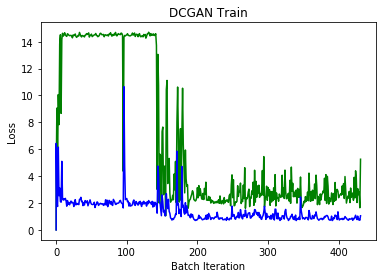

Epoch 55/190 :
     Batch 1/8 generator loss | discriminator loss : 1.7412704 | 1.3768461 - batch took 7.674509525299072 s.
     Batch 2/8 generator loss | discriminator loss : 5.2219944 | 1.9933438 - batch took 7.740659713745117 s.
     Batch 3/8 generator loss | discriminator loss : 3.3291986 | 1.5691077 - batch took 7.523127317428589 s.
     Batch 4/8 generator loss | discriminator loss : 1.8433768 | 1.0671043 - batch took 8.009402751922607 s.
     Batch 5/8 generator loss | discriminator loss : 2.5457902 | 0.9055315 - batch took 7.6091978549957275 s.
     Batch 6/8 generator loss | discriminator loss : 2.242711 | 0.8935371 - batch took 7.6131463050842285 s.
     Batch 7/8 generator loss | discriminator loss : 4.133783 | 1.2022192 - batch took 7.146869659423828 s.
     Batch 8/8 generator loss | discriminator loss : 3.8211825 | 0.84303224 - batch took 7.789254903793335 s.


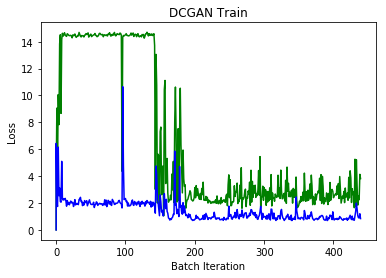

Epoch 56/190 :
     Batch 1/8 generator loss | discriminator loss : 1.9692286 | 0.91864634 - batch took 7.600765705108643 s.
     Batch 2/8 generator loss | discriminator loss : 2.7973206 | 0.80531025 - batch took 7.853737831115723 s.
     Batch 3/8 generator loss | discriminator loss : 2.1659756 | 0.8104839 - batch took 7.307063102722168 s.
     Batch 4/8 generator loss | discriminator loss : 3.1441948 | 0.9789999 - batch took 7.60607647895813 s.
     Batch 5/8 generator loss | discriminator loss : 2.4895997 | 0.99334776 - batch took 7.468004465103149 s.
     Batch 6/8 generator loss | discriminator loss : 4.4336176 | 1.2323457 - batch took 7.865965843200684 s.
     Batch 7/8 generator loss | discriminator loss : 1.8862627 | 1.2045496 - batch took 7.757002353668213 s.
     Batch 8/8 generator loss | discriminator loss : 4.1235585 | 1.8159893 - batch took 9.575339317321777 s.


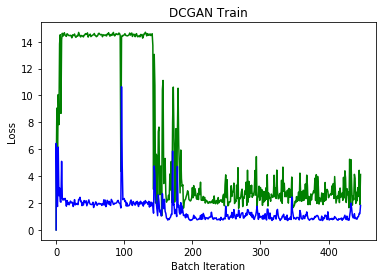

Epoch 57/190 :
     Batch 1/8 generator loss | discriminator loss : 2.2884924 | 1.3890533 - batch took 9.375712871551514 s.
     Batch 2/8 generator loss | discriminator loss : 1.7865088 | 1.0321054 - batch took 10.111156702041626 s.
     Batch 3/8 generator loss | discriminator loss : 2.3702385 | 0.767517 - batch took 8.983052492141724 s.
     Batch 4/8 generator loss | discriminator loss : 2.4245799 | 0.84238935 - batch took 7.744775772094727 s.
     Batch 5/8 generator loss | discriminator loss : 1.9685605 | 0.8629279 - batch took 7.411286354064941 s.
     Batch 6/8 generator loss | discriminator loss : 2.4795988 | 0.8533871 - batch took 7.693941354751587 s.
     Batch 7/8 generator loss | discriminator loss : 2.519034 | 0.7582449 - batch took 7.488649845123291 s.
     Batch 8/8 generator loss | discriminator loss : 2.0388896 | 0.67309237 - batch took 7.8721113204956055 s.


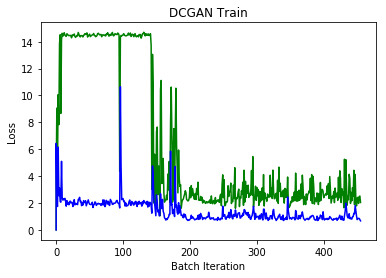

Epoch 58/190 :
     Batch 1/8 generator loss | discriminator loss : 2.0682466 | 0.8042816 - batch took 7.875874757766724 s.
     Batch 2/8 generator loss | discriminator loss : 2.037499 | 0.81227744 - batch took 8.805389642715454 s.
     Batch 3/8 generator loss | discriminator loss : 1.8543961 | 0.8334731 - batch took 9.32893443107605 s.
     Batch 4/8 generator loss | discriminator loss : 1.943708 | 0.74791515 - batch took 8.80355954170227 s.
     Batch 5/8 generator loss | discriminator loss : 2.638927 | 0.8562601 - batch took 8.58583664894104 s.
     Batch 6/8 generator loss | discriminator loss : 1.8529109 | 0.82256985 - batch took 8.04000186920166 s.
     Batch 7/8 generator loss | discriminator loss : 2.7800117 | 0.7719728 - batch took 7.890374183654785 s.
     Batch 8/8 generator loss | discriminator loss : 1.9778657 | 0.7418167 - batch took 8.139790534973145 s.


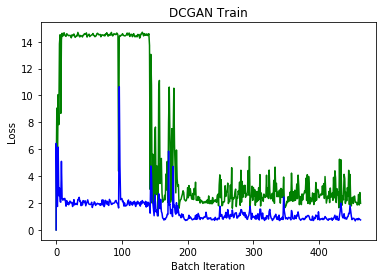

Epoch 59/190 :
     Batch 1/8 generator loss | discriminator loss : 3.891087 | 1.1115453 - batch took 7.666372299194336 s.
     Batch 2/8 generator loss | discriminator loss : 1.75256 | 1.4851428 - batch took 8.143873929977417 s.
     Batch 3/8 generator loss | discriminator loss : 2.4779212 | 0.80601156 - batch took 8.700186967849731 s.
     Batch 4/8 generator loss | discriminator loss : 2.631763 | 0.71432304 - batch took 7.954312086105347 s.
     Batch 5/8 generator loss | discriminator loss : 2.1729264 | 0.8280117 - batch took 8.453326940536499 s.
     Batch 6/8 generator loss | discriminator loss : 3.400988 | 0.8258952 - batch took 8.02676773071289 s.
     Batch 7/8 generator loss | discriminator loss : 2.601691 | 1.0245514 - batch took 9.527051210403442 s.
     Batch 8/8 generator loss | discriminator loss : 2.863741 | 0.8309227 - batch took 7.931894779205322 s.


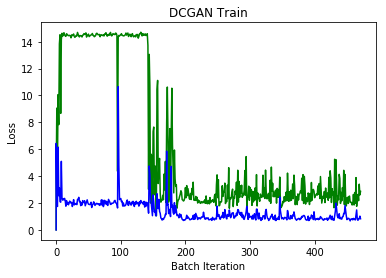

Epoch 60/190 :
     Batch 1/8 generator loss | discriminator loss : 2.872742 | 0.87309086 - batch took 8.633975505828857 s.
     Batch 2/8 generator loss | discriminator loss : 1.6710138 | 0.8200407 - batch took 8.881922721862793 s.
     Batch 3/8 generator loss | discriminator loss : 4.4702997 | 1.3765824 - batch took 8.803340196609497 s.
     Batch 4/8 generator loss | discriminator loss : 1.6483796 | 1.6441114 - batch took 8.243164539337158 s.
     Batch 5/8 generator loss | discriminator loss : 3.4656317 | 1.4408386 - batch took 7.836424112319946 s.
     Batch 6/8 generator loss | discriminator loss : 2.8365521 | 0.9588415 - batch took 7.833097696304321 s.
     Batch 7/8 generator loss | discriminator loss : 1.6216758 | 0.97546196 - batch took 7.957897186279297 s.
     Batch 8/8 generator loss | discriminator loss : 3.264276 | 0.93152034 - batch took 8.437049627304077 s.


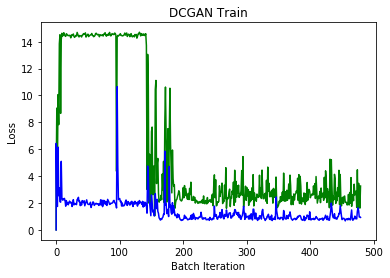

Epoch 61/190 :
     Batch 1/8 generator loss | discriminator loss : 1.4473529 | 1.0042608 - batch took 8.589930534362793 s.
     Batch 2/8 generator loss | discriminator loss : 4.283096 | 1.2248336 - batch took 9.108316659927368 s.
     Batch 3/8 generator loss | discriminator loss : 1.8955935 | 1.3548034 - batch took 9.002092123031616 s.
     Batch 4/8 generator loss | discriminator loss : 2.5829346 | 1.0733043 - batch took 8.927482843399048 s.
     Batch 5/8 generator loss | discriminator loss : 2.0582497 | 1.0206103 - batch took 7.794346570968628 s.
     Batch 6/8 generator loss | discriminator loss : 3.0704832 | 0.94566023 - batch took 8.594350099563599 s.
     Batch 7/8 generator loss | discriminator loss : 2.6188703 | 0.9421734 - batch took 8.441919565200806 s.
     Batch 8/8 generator loss | discriminator loss : 2.9367852 | 0.8078462 - batch took 8.495556592941284 s.


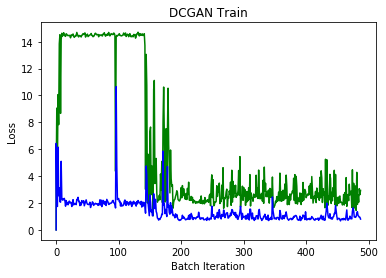

Epoch 62/190 :
     Batch 1/8 generator loss | discriminator loss : 2.5779595 | 0.7952794 - batch took 8.622654914855957 s.
     Batch 2/8 generator loss | discriminator loss : 8.40939 | 1.5925399 - batch took 7.928599834442139 s.
     Batch 3/8 generator loss | discriminator loss : 4.098328 | 2.8347888 - batch took 8.008018970489502 s.
     Batch 4/8 generator loss | discriminator loss : 1.729794 | 1.1271234 - batch took 7.611809492111206 s.
     Batch 5/8 generator loss | discriminator loss : 2.7556977 | 0.9770651 - batch took 7.517129182815552 s.
     Batch 6/8 generator loss | discriminator loss : 2.3651023 | 0.9043078 - batch took 7.305582523345947 s.
     Batch 7/8 generator loss | discriminator loss : 2.4166145 | 0.8881223 - batch took 6.972473621368408 s.
     Batch 8/8 generator loss | discriminator loss : 1.8978283 | 0.8854692 - batch took 7.522522211074829 s.


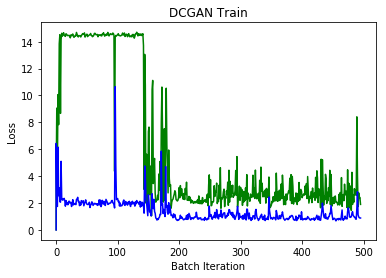

Epoch 63/190 :
     Batch 1/8 generator loss | discriminator loss : 2.3215127 | 0.7837176 - batch took 7.16795015335083 s.
     Batch 2/8 generator loss | discriminator loss : 2.0282183 | 0.80654764 - batch took 7.259775400161743 s.
     Batch 3/8 generator loss | discriminator loss : 2.522375 | 1.005337 - batch took 6.7827746868133545 s.
     Batch 4/8 generator loss | discriminator loss : 2.3226397 | 0.783064 - batch took 7.450073003768921 s.
     Batch 5/8 generator loss | discriminator loss : 2.2919116 | 0.83369184 - batch took 7.275515556335449 s.
     Batch 6/8 generator loss | discriminator loss : 2.3130789 | 0.76883245 - batch took 8.19629955291748 s.
     Batch 7/8 generator loss | discriminator loss : 2.3063276 | 0.7537357 - batch took 6.827277660369873 s.
     Batch 8/8 generator loss | discriminator loss : 2.9287255 | 0.93635726 - batch took 6.9506447315216064 s.


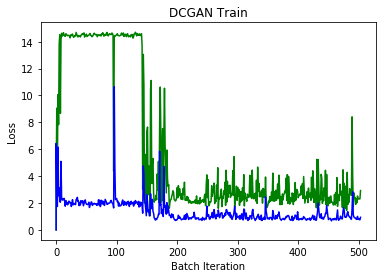

Epoch 64/190 :
     Batch 1/8 generator loss | discriminator loss : 1.6932769 | 0.9792639 - batch took 7.088921070098877 s.
     Batch 2/8 generator loss | discriminator loss : 2.2316065 | 0.7906093 - batch took 7.017422676086426 s.
     Batch 3/8 generator loss | discriminator loss : 2.0055146 | 0.8568907 - batch took 7.196706056594849 s.
     Batch 4/8 generator loss | discriminator loss : 2.3046455 | 0.7270482 - batch took 6.694534778594971 s.
     Batch 5/8 generator loss | discriminator loss : 2.9819117 | 0.9213598 - batch took 6.50117301940918 s.
     Batch 6/8 generator loss | discriminator loss : 2.889971 | 0.9201542 - batch took 7.405488014221191 s.
     Batch 7/8 generator loss | discriminator loss : 3.541637 | 1.1755544 - batch took 8.919057369232178 s.
     Batch 8/8 generator loss | discriminator loss : 2.7940633 | 0.83812374 - batch took 8.092291116714478 s.


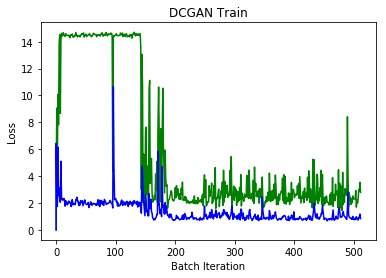

Epoch 65/190 :
     Batch 1/8 generator loss | discriminator loss : 2.3671641 | 0.8135358 - batch took 7.544515132904053 s.
     Batch 2/8 generator loss | discriminator loss : 2.023509 | 0.7761857 - batch took 6.8641886711120605 s.
     Batch 3/8 generator loss | discriminator loss : 5.645239 | 1.4171141 - batch took 6.670921087265015 s.
     Batch 4/8 generator loss | discriminator loss : 1.9261392 | 1.7205722 - batch took 7.18433952331543 s.
     Batch 5/8 generator loss | discriminator loss : 4.2481174 | 1.8629255 - batch took 8.43705415725708 s.
     Batch 6/8 generator loss | discriminator loss : 2.4949465 | 1.5397371 - batch took 12.11289095878601 s.
     Batch 7/8 generator loss | discriminator loss : 2.8623583 | 1.2578979 - batch took 14.326376914978027 s.
     Batch 8/8 generator loss | discriminator loss : 2.125842 | 0.90186876 - batch took 7.689325571060181 s.


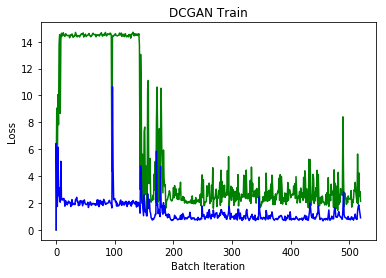

Epoch 66/190 :
     Batch 1/8 generator loss | discriminator loss : 3.284186 | 1.1512699 - batch took 7.946415424346924 s.
     Batch 2/8 generator loss | discriminator loss : 2.0194213 | 1.0757476 - batch took 8.229190826416016 s.
     Batch 3/8 generator loss | discriminator loss : 2.718891 | 0.98217636 - batch took 8.637813329696655 s.
     Batch 4/8 generator loss | discriminator loss : 2.5197287 | 0.77452457 - batch took 8.732442378997803 s.
     Batch 5/8 generator loss | discriminator loss : 2.455997 | 0.8683466 - batch took 8.03814172744751 s.
     Batch 6/8 generator loss | discriminator loss : 2.802147 | 0.8304223 - batch took 6.668864488601685 s.
     Batch 7/8 generator loss | discriminator loss : 2.0475624 | 0.90293443 - batch took 6.83919620513916 s.
     Batch 8/8 generator loss | discriminator loss : 3.7086399 | 1.1257755 - batch took 6.705250263214111 s.


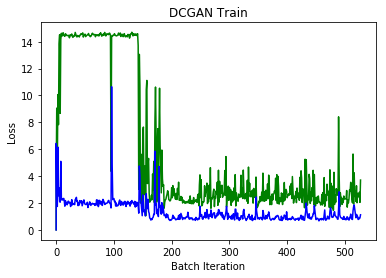

Epoch 67/190 :
     Batch 1/8 generator loss | discriminator loss : 2.1912851 | 1.2596271 - batch took 7.251643896102905 s.
     Batch 2/8 generator loss | discriminator loss : 3.482359 | 1.0713824 - batch took 9.248181343078613 s.
     Batch 3/8 generator loss | discriminator loss : 2.0719101 | 1.1373096 - batch took 9.538519620895386 s.
     Batch 4/8 generator loss | discriminator loss : 3.5846949 | 0.9909953 - batch took 7.99618935585022 s.
     Batch 5/8 generator loss | discriminator loss : 1.9695125 | 1.1803743 - batch took 8.194855690002441 s.
     Batch 6/8 generator loss | discriminator loss : 3.5037842 | 1.012321 - batch took 8.447117805480957 s.
     Batch 7/8 generator loss | discriminator loss : 2.2712512 | 0.9271932 - batch took 9.328796863555908 s.
     Batch 8/8 generator loss | discriminator loss : 3.3271096 | 1.0173153 - batch took 10.850604772567749 s.


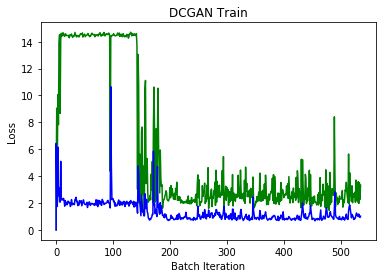

Epoch 68/190 :
     Batch 1/8 generator loss | discriminator loss : 2.0958042 | 1.0385556 - batch took 12.310917615890503 s.
     Batch 2/8 generator loss | discriminator loss : 4.7335997 | 1.3929169 - batch took 8.85710096359253 s.
     Batch 3/8 generator loss | discriminator loss : 3.4532275 | 0.984391 - batch took 7.523403167724609 s.
     Batch 4/8 generator loss | discriminator loss : 2.3427892 | 1.3503261 - batch took 9.281108856201172 s.
     Batch 5/8 generator loss | discriminator loss : 3.1342776 | 0.92083573 - batch took 8.907088994979858 s.
     Batch 6/8 generator loss | discriminator loss : 2.4308987 | 0.9855845 - batch took 7.944890022277832 s.
     Batch 7/8 generator loss | discriminator loss : 2.9925628 | 0.9015653 - batch took 8.26157832145691 s.
     Batch 8/8 generator loss | discriminator loss : 2.1550772 | 0.81218046 - batch took 6.840103626251221 s.


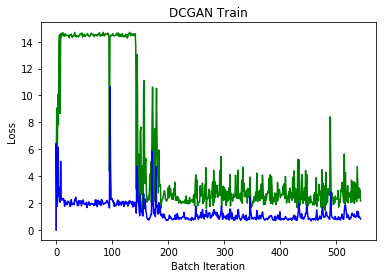

Epoch 69/190 :
     Batch 1/8 generator loss | discriminator loss : 5.382642 | 1.2271757 - batch took 7.426775693893433 s.
     Batch 2/8 generator loss | discriminator loss : 2.454587 | 1.5382285 - batch took 6.724322557449341 s.
     Batch 3/8 generator loss | discriminator loss : 3.029288 | 1.1660198 - batch took 6.7736780643463135 s.
     Batch 4/8 generator loss | discriminator loss : 2.1674817 | 0.9491546 - batch took 6.745115518569946 s.
     Batch 5/8 generator loss | discriminator loss : 2.7915258 | 1.0533144 - batch took 6.54140305519104 s.
     Batch 6/8 generator loss | discriminator loss : 2.5999897 | 1.0452572 - batch took 6.838371992111206 s.
     Batch 7/8 generator loss | discriminator loss : 2.4819264 | 0.80342007 - batch took 6.679789304733276 s.
     Batch 8/8 generator loss | discriminator loss : 2.493759 | 1.1651376 - batch took 6.526862144470215 s.


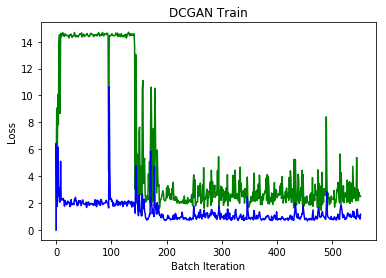

Epoch 70/190 :
     Batch 1/8 generator loss | discriminator loss : 2.3189225 | 0.9350879 - batch took 6.5817553997039795 s.
     Batch 2/8 generator loss | discriminator loss : 2.5957837 | 0.8600124 - batch took 6.511963129043579 s.
     Batch 3/8 generator loss | discriminator loss : 2.393479 | 0.817492 - batch took 6.9092857837677 s.
     Batch 4/8 generator loss | discriminator loss : 3.0965033 | 0.84522325 - batch took 6.535437345504761 s.
     Batch 5/8 generator loss | discriminator loss : 1.8450208 | 0.81806266 - batch took 6.901101589202881 s.
     Batch 6/8 generator loss | discriminator loss : 3.2285864 | 0.94726473 - batch took 6.610262870788574 s.
     Batch 7/8 generator loss | discriminator loss : 2.2793949 | 0.96160996 - batch took 6.892544269561768 s.
     Batch 8/8 generator loss | discriminator loss : 3.1970868 | 0.98212355 - batch took 6.753129482269287 s.


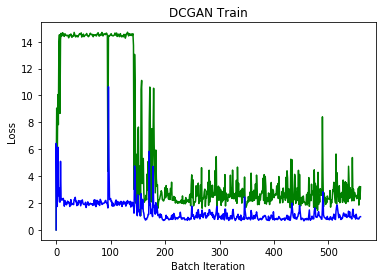

Epoch 71/190 :
     Batch 1/8 generator loss | discriminator loss : 2.9762216 | 0.92055565 - batch took 6.685070991516113 s.
     Batch 2/8 generator loss | discriminator loss : 3.0153081 | 0.9818406 - batch took 6.912856817245483 s.
     Batch 3/8 generator loss | discriminator loss : 2.7853417 | 1.0917556 - batch took 6.45861291885376 s.
     Batch 4/8 generator loss | discriminator loss : 3.9082117 | 1.091762 - batch took 7.315820932388306 s.
     Batch 5/8 generator loss | discriminator loss : 2.263343 | 0.97512877 - batch took 6.63957142829895 s.
     Batch 6/8 generator loss | discriminator loss : 4.512251 | 1.1518435 - batch took 6.544501066207886 s.
     Batch 7/8 generator loss | discriminator loss : 2.1955793 | 1.3797601 - batch took 6.832345485687256 s.
     Batch 8/8 generator loss | discriminator loss : 4.7670603 | 1.4540989 - batch took 6.643232345581055 s.


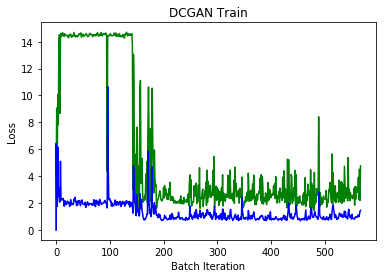

Epoch 72/190 :
     Batch 1/8 generator loss | discriminator loss : 2.6891217 | 1.0749547 - batch took 6.795245885848999 s.
     Batch 2/8 generator loss | discriminator loss : 3.4224927 | 1.0357941 - batch took 6.532347202301025 s.
     Batch 3/8 generator loss | discriminator loss : 2.5973358 | 0.8445188 - batch took 7.375370502471924 s.
     Batch 4/8 generator loss | discriminator loss : 2.47591 | 0.9177033 - batch took 6.931869268417358 s.
     Batch 5/8 generator loss | discriminator loss : 2.7501025 | 0.7801169 - batch took 6.4638426303863525 s.
     Batch 6/8 generator loss | discriminator loss : 2.3742783 | 0.83766204 - batch took 6.710918188095093 s.
     Batch 7/8 generator loss | discriminator loss : 2.9475598 | 0.98302054 - batch took 6.448492765426636 s.
     Batch 8/8 generator loss | discriminator loss : 1.8391281 | 0.8774467 - batch took 6.927261829376221 s.


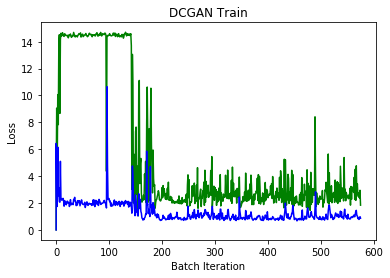

Epoch 73/190 :
     Batch 1/8 generator loss | discriminator loss : 3.784878 | 1.0450726 - batch took 6.917227506637573 s.
     Batch 2/8 generator loss | discriminator loss : 2.5147529 | 0.959793 - batch took 6.9372735023498535 s.
     Batch 3/8 generator loss | discriminator loss : 2.6744242 | 0.8398626 - batch took 7.292187452316284 s.
     Batch 4/8 generator loss | discriminator loss : 2.4235656 | 0.737389 - batch took 6.568649768829346 s.
     Batch 5/8 generator loss | discriminator loss : 3.762816 | 1.373678 - batch took 6.967764854431152 s.
     Batch 6/8 generator loss | discriminator loss : 2.1397562 | 1.1906989 - batch took 6.551410436630249 s.
     Batch 7/8 generator loss | discriminator loss : 2.0426362 | 0.837869 - batch took 6.764514207839966 s.
     Batch 8/8 generator loss | discriminator loss : 2.3109934 | 0.8903736 - batch took 6.455555438995361 s.


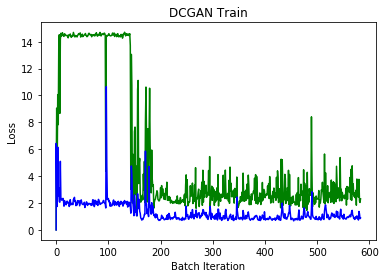

Epoch 74/190 :
     Batch 1/8 generator loss | discriminator loss : 2.3367047 | 0.77625334 - batch took 6.6624414920806885 s.
     Batch 2/8 generator loss | discriminator loss : 2.4455807 | 0.767629 - batch took 7.136801242828369 s.
     Batch 3/8 generator loss | discriminator loss : 3.0025086 | 0.96733046 - batch took 6.782148599624634 s.
     Batch 4/8 generator loss | discriminator loss : 2.5658789 | 0.7575934 - batch took 8.086774587631226 s.
     Batch 5/8 generator loss | discriminator loss : 2.8940356 | 0.80799377 - batch took 6.6700599193573 s.
     Batch 6/8 generator loss | discriminator loss : 2.4999213 | 0.69722116 - batch took 6.828679084777832 s.
     Batch 7/8 generator loss | discriminator loss : 3.578551 | 0.87763417 - batch took 6.574361085891724 s.
     Batch 8/8 generator loss | discriminator loss : 2.680105 | 0.8493756 - batch took 7.054366588592529 s.


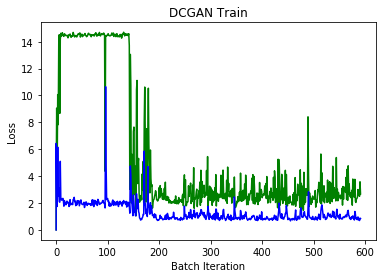

Epoch 75/190 :
     Batch 1/8 generator loss | discriminator loss : 3.7703774 | 0.88878417 - batch took 6.578836679458618 s.
     Batch 2/8 generator loss | discriminator loss : 1.8150867 | 1.0116594 - batch took 6.57241415977478 s.
     Batch 3/8 generator loss | discriminator loss : 4.0329714 | 0.97207093 - batch took 6.858216047286987 s.
     Batch 4/8 generator loss | discriminator loss : 2.4683857 | 0.8974844 - batch took 7.278408765792847 s.
     Batch 5/8 generator loss | discriminator loss : 4.1684093 | 0.986614 - batch took 8.512008666992188 s.
     Batch 6/8 generator loss | discriminator loss : 2.2698765 | 0.9727727 - batch took 7.035409927368164 s.
     Batch 7/8 generator loss | discriminator loss : 4.659927 | 1.0672059 - batch took 6.741125822067261 s.
     Batch 8/8 generator loss | discriminator loss : 2.5056655 | 1.2279449 - batch took 6.424995422363281 s.


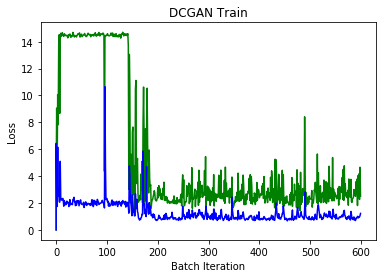

Epoch 76/190 :
     Batch 1/8 generator loss | discriminator loss : 4.517509 | 1.1300039 - batch took 7.0447986125946045 s.
     Batch 2/8 generator loss | discriminator loss : 2.9514887 | 0.98726106 - batch took 6.5017547607421875 s.
     Batch 3/8 generator loss | discriminator loss : 3.1548498 | 0.9526695 - batch took 6.686124563217163 s.
     Batch 4/8 generator loss | discriminator loss : 2.094871 | 0.84148335 - batch took 6.634276390075684 s.
     Batch 5/8 generator loss | discriminator loss : 2.9619842 | 0.99492115 - batch took 6.5184526443481445 s.
     Batch 6/8 generator loss | discriminator loss : 2.4884386 | 0.8056654 - batch took 6.6888532638549805 s.
     Batch 7/8 generator loss | discriminator loss : 2.933396 | 0.8700299 - batch took 6.679810523986816 s.
     Batch 8/8 generator loss | discriminator loss : 2.274974 | 0.85679114 - batch took 6.341158390045166 s.


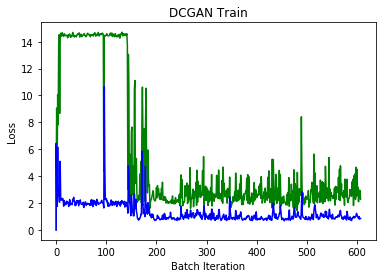

Epoch 77/190 :
     Batch 1/8 generator loss | discriminator loss : 2.315152 | 0.73979217 - batch took 6.528987169265747 s.
     Batch 2/8 generator loss | discriminator loss : 2.3825555 | 0.7580993 - batch took 6.308194875717163 s.
     Batch 3/8 generator loss | discriminator loss : 4.0603657 | 1.0327828 - batch took 6.577990770339966 s.
     Batch 4/8 generator loss | discriminator loss : 2.0318158 | 0.83438027 - batch took 6.489464998245239 s.
     Batch 5/8 generator loss | discriminator loss : 4.238261 | 1.1472843 - batch took 6.503713130950928 s.
     Batch 6/8 generator loss | discriminator loss : 2.3211637 | 1.0604239 - batch took 6.855071544647217 s.
     Batch 7/8 generator loss | discriminator loss : 5.4624634 | 1.5236279 - batch took 6.456468105316162 s.
     Batch 8/8 generator loss | discriminator loss : 2.3459306 | 1.741004 - batch took 6.685081958770752 s.


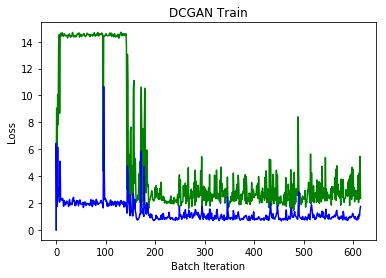

Epoch 78/190 :
     Batch 1/8 generator loss | discriminator loss : 3.2468545 | 1.1506051 - batch took 7.091911792755127 s.
     Batch 2/8 generator loss | discriminator loss : 2.6564593 | 0.8343054 - batch took 7.3323962688446045 s.
     Batch 3/8 generator loss | discriminator loss : 2.7163317 | 0.9477524 - batch took 6.359801769256592 s.
     Batch 4/8 generator loss | discriminator loss : 1.925148 | 0.87573653 - batch took 6.4615559577941895 s.
     Batch 5/8 generator loss | discriminator loss : 2.207233 | 0.764609 - batch took 6.746631145477295 s.
     Batch 6/8 generator loss | discriminator loss : 2.2269995 | 0.78927386 - batch took 6.555428504943848 s.
     Batch 7/8 generator loss | discriminator loss : 3.121116 | 0.820426 - batch took 6.5500569343566895 s.
     Batch 8/8 generator loss | discriminator loss : 1.9550989 | 0.8334935 - batch took 6.439898490905762 s.


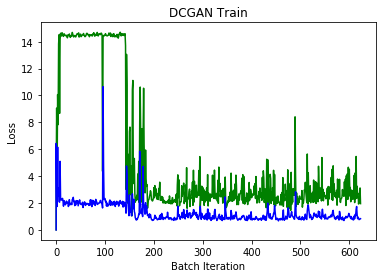

Epoch 79/190 :
     Batch 1/8 generator loss | discriminator loss : 3.9759464 | 1.1478968 - batch took 7.401943206787109 s.
     Batch 2/8 generator loss | discriminator loss : 2.6267889 | 0.96439695 - batch took 6.715489387512207 s.
     Batch 3/8 generator loss | discriminator loss : 2.150858 | 0.7850122 - batch took 6.435739517211914 s.
     Batch 4/8 generator loss | discriminator loss : 2.9130182 | 0.8453527 - batch took 6.440364360809326 s.
     Batch 5/8 generator loss | discriminator loss : 1.9412781 | 0.8462887 - batch took 6.334019899368286 s.
     Batch 6/8 generator loss | discriminator loss : 2.6352644 | 0.8147216 - batch took 6.918194055557251 s.
     Batch 7/8 generator loss | discriminator loss : 2.5601702 | 0.77169585 - batch took 6.424849510192871 s.
     Batch 8/8 generator loss | discriminator loss : 3.7398782 | 1.1572098 - batch took 6.420291423797607 s.


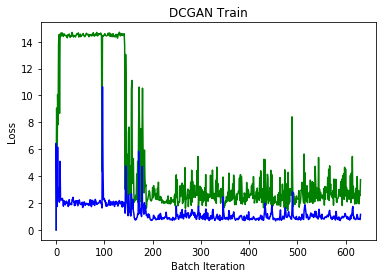

Epoch 80/190 :
     Batch 1/8 generator loss | discriminator loss : 2.8199165 | 0.8518822 - batch took 6.502991437911987 s.
     Batch 2/8 generator loss | discriminator loss : 1.3283747 | 0.73375964 - batch took 6.407398462295532 s.
     Batch 3/8 generator loss | discriminator loss : 2.7850797 | 0.9119786 - batch took 6.71503758430481 s.
     Batch 4/8 generator loss | discriminator loss : 2.3533404 | 1.105735 - batch took 6.505263328552246 s.
     Batch 5/8 generator loss | discriminator loss : 1.5681022 | 0.768835 - batch took 6.4452738761901855 s.
     Batch 6/8 generator loss | discriminator loss : 2.8184357 | 0.8579884 - batch took 6.5019614696502686 s.
     Batch 7/8 generator loss | discriminator loss : 2.418728 | 0.7533437 - batch took 6.662984371185303 s.
     Batch 8/8 generator loss | discriminator loss : 6.8419423 | 1.5806258 - batch took 6.90607213973999 s.


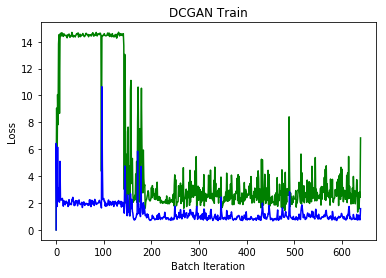

Epoch 81/190 :
     Batch 1/8 generator loss | discriminator loss : 3.9489524 | 2.0226364 - batch took 6.69035530090332 s.
     Batch 2/8 generator loss | discriminator loss : 1.8954846 | 0.72299826 - batch took 7.014504671096802 s.
     Batch 3/8 generator loss | discriminator loss : 3.362757 | 1.0701647 - batch took 6.532541990280151 s.
     Batch 4/8 generator loss | discriminator loss : 2.6215885 | 0.9063245 - batch took 6.393720865249634 s.
     Batch 5/8 generator loss | discriminator loss : 2.0916324 | 1.0945766 - batch took 6.695839881896973 s.
     Batch 6/8 generator loss | discriminator loss : 2.9560053 | 0.99516815 - batch took 6.326201915740967 s.
     Batch 7/8 generator loss | discriminator loss : 2.9503427 | 1.0335231 - batch took 6.6748480796813965 s.
     Batch 8/8 generator loss | discriminator loss : 2.8506212 | 0.778427 - batch took 6.558584451675415 s.


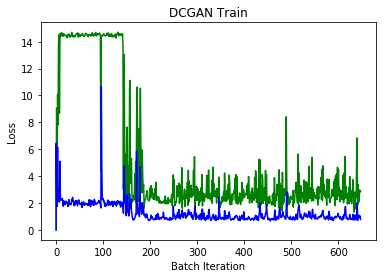

Epoch 82/190 :
     Batch 1/8 generator loss | discriminator loss : 3.0976245 | 0.7027745 - batch took 6.606718301773071 s.
     Batch 2/8 generator loss | discriminator loss : 3.5492225 | 1.0419425 - batch took 8.134747743606567 s.
     Batch 3/8 generator loss | discriminator loss : 2.0642643 | 1.0155398 - batch took 6.65974497795105 s.
     Batch 4/8 generator loss | discriminator loss : 3.7562332 | 0.96044296 - batch took 6.858688831329346 s.
     Batch 5/8 generator loss | discriminator loss : 3.0920792 | 0.79952794 - batch took 6.505778789520264 s.
     Batch 6/8 generator loss | discriminator loss : 2.5690565 | 0.9809122 - batch took 6.705706596374512 s.
     Batch 7/8 generator loss | discriminator loss : 2.5263696 | 0.78449136 - batch took 6.416313409805298 s.
     Batch 8/8 generator loss | discriminator loss : 2.727555 | 0.7392007 - batch took 6.5366175174713135 s.


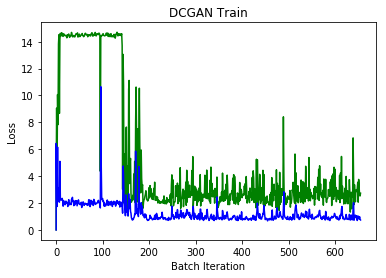

Epoch 83/190 :
     Batch 1/8 generator loss | discriminator loss : 2.5420513 | 0.80442286 - batch took 6.419674396514893 s.
     Batch 2/8 generator loss | discriminator loss : 2.167655 | 0.7845504 - batch took 6.448338270187378 s.
     Batch 3/8 generator loss | discriminator loss : 4.093991 | 1.1878335 - batch took 6.939354181289673 s.
     Batch 4/8 generator loss | discriminator loss : 1.9520221 | 1.1622846 - batch took 6.448587894439697 s.
     Batch 5/8 generator loss | discriminator loss : 2.253091 | 0.88311887 - batch took 6.644028902053833 s.
     Batch 6/8 generator loss | discriminator loss : 2.1175318 | 0.6907058 - batch took 6.63683557510376 s.
     Batch 7/8 generator loss | discriminator loss : 3.4422913 | 1.0853398 - batch took 6.448991537094116 s.
     Batch 8/8 generator loss | discriminator loss : 2.6047976 | 0.8810602 - batch took 6.623213529586792 s.


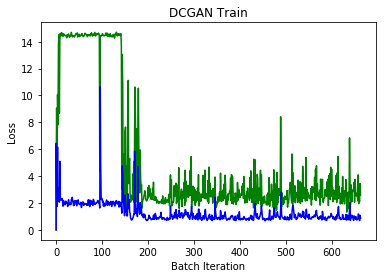

Epoch 84/190 :
     Batch 1/8 generator loss | discriminator loss : 2.0656374 | 0.780239 - batch took 6.271966934204102 s.
     Batch 2/8 generator loss | discriminator loss : 2.41116 | 0.7214507 - batch took 6.7987987995147705 s.
     Batch 3/8 generator loss | discriminator loss : 2.5295966 | 0.80165 - batch took 6.3535315990448 s.
     Batch 4/8 generator loss | discriminator loss : 2.645387 | 0.8486283 - batch took 6.685849666595459 s.
     Batch 5/8 generator loss | discriminator loss : 2.8802803 | 0.8479166 - batch took 6.653858661651611 s.
     Batch 6/8 generator loss | discriminator loss : 2.3943925 | 0.79829067 - batch took 6.727501630783081 s.
     Batch 7/8 generator loss | discriminator loss : 3.5372708 | 0.92384565 - batch took 6.870647668838501 s.
     Batch 8/8 generator loss | discriminator loss : 2.210596 | 0.9699222 - batch took 6.663480043411255 s.


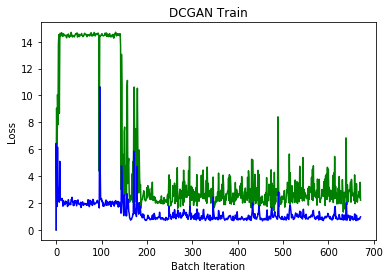

Epoch 85/190 :
     Batch 1/8 generator loss | discriminator loss : 4.097287 | 0.9170337 - batch took 6.600722789764404 s.
     Batch 2/8 generator loss | discriminator loss : 2.3625479 | 0.9445715 - batch took 6.302393913269043 s.
     Batch 3/8 generator loss | discriminator loss : 4.798152 | 1.1202369 - batch took 6.65364146232605 s.
     Batch 4/8 generator loss | discriminator loss : 2.2005558 | 1.269211 - batch took 6.848241567611694 s.
     Batch 5/8 generator loss | discriminator loss : 2.6108837 | 0.920377 - batch took 6.423334121704102 s.
     Batch 6/8 generator loss | discriminator loss : 2.5579653 | 0.7253343 - batch took 6.762192010879517 s.
     Batch 7/8 generator loss | discriminator loss : 2.9394906 | 0.9501045 - batch took 6.504040718078613 s.
     Batch 8/8 generator loss | discriminator loss : 1.6245645 | 0.8346613 - batch took 6.341060161590576 s.


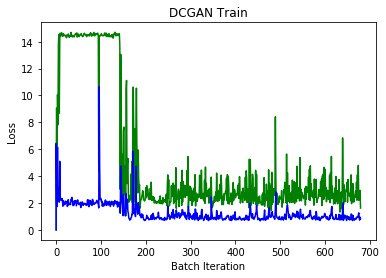

Epoch 86/190 :
     Batch 1/8 generator loss | discriminator loss : 3.4173222 | 0.9276831 - batch took 6.801090955734253 s.
     Batch 2/8 generator loss | discriminator loss : 2.4185772 | 0.82046205 - batch took 6.411201000213623 s.
     Batch 3/8 generator loss | discriminator loss : 4.1611266 | 1.1963091 - batch took 6.841204643249512 s.
     Batch 4/8 generator loss | discriminator loss : 2.7197175 | 1.2145504 - batch took 6.395192861557007 s.
     Batch 5/8 generator loss | discriminator loss : 1.9618943 | 0.8116518 - batch took 6.756622076034546 s.
     Batch 6/8 generator loss | discriminator loss : 2.730815 | 0.77282155 - batch took 6.468487501144409 s.
     Batch 7/8 generator loss | discriminator loss : 2.3022356 | 0.77632123 - batch took 6.4391419887542725 s.
     Batch 8/8 generator loss | discriminator loss : 2.9531908 | 0.975415 - batch took 6.581900358200073 s.


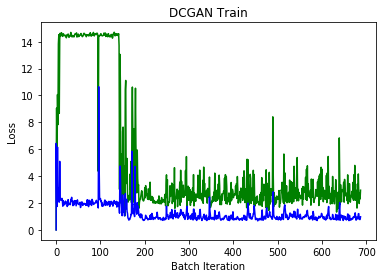

Epoch 87/190 :
     Batch 1/8 generator loss | discriminator loss : 2.561062 | 0.74388117 - batch took 6.350639820098877 s.
     Batch 2/8 generator loss | discriminator loss : 3.6240075 | 0.89352053 - batch took 6.744394063949585 s.
     Batch 3/8 generator loss | discriminator loss : 2.1606967 | 0.86828053 - batch took 6.6950390338897705 s.
     Batch 4/8 generator loss | discriminator loss : 3.088535 | 0.91574544 - batch took 6.721561908721924 s.
     Batch 5/8 generator loss | discriminator loss : 2.0133588 | 0.87354374 - batch took 6.9721033573150635 s.
     Batch 6/8 generator loss | discriminator loss : 3.5403712 | 0.92946494 - batch took 6.553479433059692 s.
     Batch 7/8 generator loss | discriminator loss : 2.2408164 | 0.9524732 - batch took 6.7319746017456055 s.
     Batch 8/8 generator loss | discriminator loss : 4.0798073 | 0.9898282 - batch took 6.343587398529053 s.


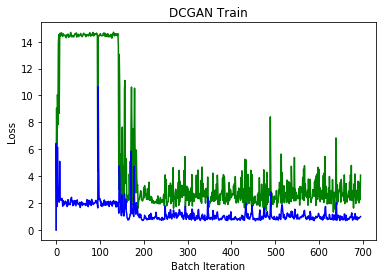

Epoch 88/190 :
     Batch 1/8 generator loss | discriminator loss : 2.5663812 | 1.0935435 - batch took 6.189605236053467 s.
     Batch 2/8 generator loss | discriminator loss : 3.1669323 | 0.87461436 - batch took 6.569126129150391 s.
     Batch 3/8 generator loss | discriminator loss : 2.3136523 | 0.74640346 - batch took 6.304351329803467 s.
     Batch 4/8 generator loss | discriminator loss : 2.2385929 | 0.78068817 - batch took 6.843384504318237 s.
     Batch 5/8 generator loss | discriminator loss : 2.0159032 | 0.7002522 - batch took 6.778380393981934 s.
     Batch 6/8 generator loss | discriminator loss : 3.7298734 | 0.9650446 - batch took 6.6233086585998535 s.
     Batch 7/8 generator loss | discriminator loss : 1.870793 | 1.1043649 - batch took 6.460552453994751 s.
     Batch 8/8 generator loss | discriminator loss : 4.468358 | 1.0900261 - batch took 6.504471302032471 s.


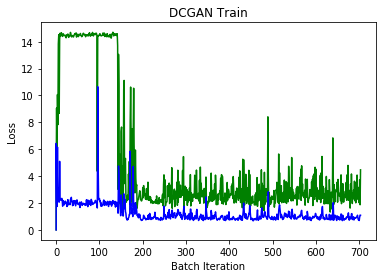

Epoch 89/190 :
     Batch 1/8 generator loss | discriminator loss : 3.8130958 | 0.9041768 - batch took 7.2306272983551025 s.
     Batch 2/8 generator loss | discriminator loss : 1.8966435 | 0.89557457 - batch took 7.386277198791504 s.
     Batch 3/8 generator loss | discriminator loss : 2.9126544 | 0.850121 - batch took 7.465468168258667 s.
     Batch 4/8 generator loss | discriminator loss : 2.5442324 | 0.7739523 - batch took 6.523813247680664 s.
     Batch 5/8 generator loss | discriminator loss : 3.7202141 | 1.0244673 - batch took 6.744086980819702 s.
     Batch 6/8 generator loss | discriminator loss : 2.3089368 | 0.8456839 - batch took 6.380684852600098 s.
     Batch 7/8 generator loss | discriminator loss : 4.0485997 | 1.0838995 - batch took 6.412749290466309 s.
     Batch 8/8 generator loss | discriminator loss : 2.9183557 | 0.9503802 - batch took 6.676691293716431 s.


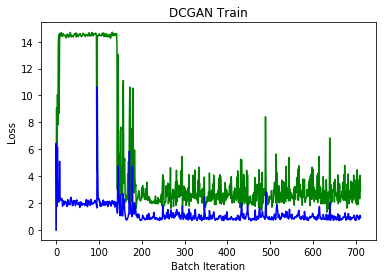

Epoch 90/190 :
     Batch 1/8 generator loss | discriminator loss : 1.7744831 | 0.77188915 - batch took 6.504219055175781 s.
     Batch 2/8 generator loss | discriminator loss : 2.5100696 | 0.8374561 - batch took 6.656219959259033 s.
     Batch 3/8 generator loss | discriminator loss : 2.4208856 | 0.70197374 - batch took 6.329819917678833 s.
     Batch 4/8 generator loss | discriminator loss : 2.8804598 | 0.8538623 - batch took 6.594696998596191 s.
     Batch 5/8 generator loss | discriminator loss : 2.1705606 | 0.8194885 - batch took 6.635507583618164 s.
     Batch 6/8 generator loss | discriminator loss : 3.303869 | 0.8622029 - batch took 6.7185468673706055 s.
     Batch 7/8 generator loss | discriminator loss : 2.4549994 | 0.7763368 - batch took 6.594256401062012 s.
     Batch 8/8 generator loss | discriminator loss : 3.2873707 | 0.8393843 - batch took 6.36145544052124 s.


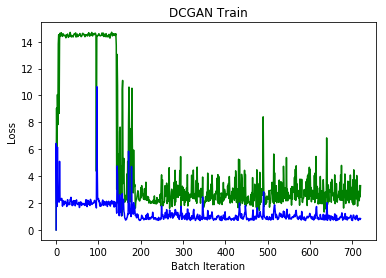

Epoch 91/190 :
     Batch 1/8 generator loss | discriminator loss : 1.8839574 | 0.8493674 - batch took 6.793083906173706 s.
     Batch 2/8 generator loss | discriminator loss : 4.2229733 | 0.9681473 - batch took 6.625971794128418 s.
     Batch 3/8 generator loss | discriminator loss : 2.9492996 | 0.8450509 - batch took 6.513480186462402 s.
     Batch 4/8 generator loss | discriminator loss : 2.6557817 | 0.9090874 - batch took 6.71165919303894 s.
     Batch 5/8 generator loss | discriminator loss : 2.4389777 | 0.7233867 - batch took 6.630539417266846 s.
     Batch 6/8 generator loss | discriminator loss : 3.0605059 | 0.7985953 - batch took 9.164030075073242 s.
     Batch 7/8 generator loss | discriminator loss : 2.6446369 | 0.78294086 - batch took 7.847799777984619 s.
     Batch 8/8 generator loss | discriminator loss : 6.0498576 | 1.17153 - batch took 8.018758058547974 s.


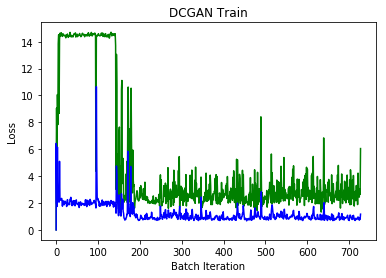

Epoch 92/190 :
     Batch 1/8 generator loss | discriminator loss : 3.421135 | 1.3544326 - batch took 7.135631322860718 s.
     Batch 2/8 generator loss | discriminator loss : 2.802777 | 0.91037506 - batch took 7.31009578704834 s.
     Batch 3/8 generator loss | discriminator loss : 2.6667945 | 0.78445953 - batch took 7.234872817993164 s.
     Batch 4/8 generator loss | discriminator loss : 2.690925 | 0.84168786 - batch took 7.721160411834717 s.
     Batch 5/8 generator loss | discriminator loss : 2.4670591 | 0.7994774 - batch took 6.86947226524353 s.
     Batch 6/8 generator loss | discriminator loss : 3.7617621 | 0.82734275 - batch took 6.633906126022339 s.
     Batch 7/8 generator loss | discriminator loss : 2.4050858 | 0.9653524 - batch took 6.639610290527344 s.
     Batch 8/8 generator loss | discriminator loss : 6.2098145 | 1.0736632 - batch took 6.996676921844482 s.


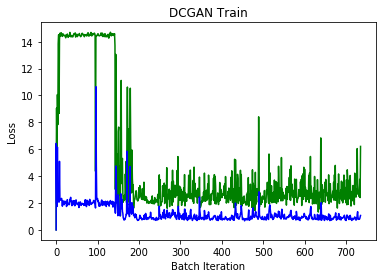

Epoch 93/190 :
     Batch 1/8 generator loss | discriminator loss : 3.6140661 | 1.3954568 - batch took 7.578567028045654 s.
     Batch 2/8 generator loss | discriminator loss : 2.466369 | 0.8666025 - batch took 8.115364789962769 s.
     Batch 3/8 generator loss | discriminator loss : 2.3558037 | 0.88809216 - batch took 7.52663254737854 s.
     Batch 4/8 generator loss | discriminator loss : 2.3420212 | 0.79691464 - batch took 6.859828472137451 s.
     Batch 5/8 generator loss | discriminator loss : 3.9207044 | 1.1678913 - batch took 7.144557952880859 s.
     Batch 6/8 generator loss | discriminator loss : 3.2406561 | 0.87401843 - batch took 6.994695425033569 s.
     Batch 7/8 generator loss | discriminator loss : 2.7401147 | 0.89541614 - batch took 6.75155234336853 s.
     Batch 8/8 generator loss | discriminator loss : 1.9516501 | 0.7878474 - batch took 6.936788320541382 s.


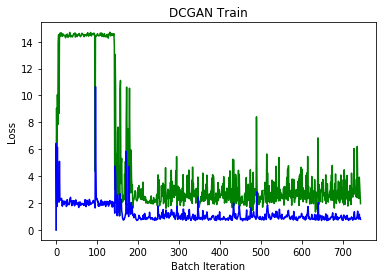

Epoch 94/190 :
     Batch 1/8 generator loss | discriminator loss : 3.2785082 | 0.9453025 - batch took 7.182013750076294 s.
     Batch 2/8 generator loss | discriminator loss : 2.4636514 | 0.8227125 - batch took 7.4729905128479 s.
     Batch 3/8 generator loss | discriminator loss : 2.4323308 | 0.77868974 - batch took 7.40955114364624 s.
     Batch 4/8 generator loss | discriminator loss : 2.4496555 | 0.71434903 - batch took 7.500553607940674 s.
     Batch 5/8 generator loss | discriminator loss : 3.9946759 | 1.2022269 - batch took 6.807437181472778 s.
     Batch 6/8 generator loss | discriminator loss : 3.4850507 | 0.92093277 - batch took 7.499335289001465 s.
     Batch 7/8 generator loss | discriminator loss : 2.1641755 | 0.7394359 - batch took 6.951841592788696 s.
     Batch 8/8 generator loss | discriminator loss : 3.0541425 | 0.8608428 - batch took 7.134632110595703 s.


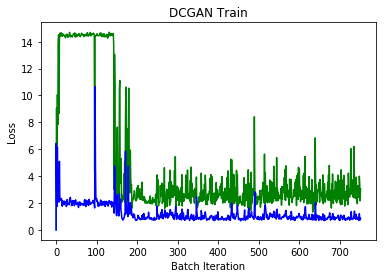

Epoch 95/190 :
     Batch 1/8 generator loss | discriminator loss : 2.5111275 | 0.8083763 - batch took 7.895802736282349 s.
     Batch 2/8 generator loss | discriminator loss : 1.86941 | 0.8077837 - batch took 7.4110047817230225 s.
     Batch 3/8 generator loss | discriminator loss : 2.6403925 | 0.7757851 - batch took 7.623271942138672 s.
     Batch 4/8 generator loss | discriminator loss : 3.3067584 | 0.92556524 - batch took 7.361669063568115 s.
     Batch 5/8 generator loss | discriminator loss : 2.0062194 | 0.82513654 - batch took 8.742074489593506 s.
     Batch 6/8 generator loss | discriminator loss : 4.598305 | 1.0608834 - batch took 9.289276599884033 s.
     Batch 7/8 generator loss | discriminator loss : 2.6572614 | 0.97571135 - batch took 8.773533582687378 s.
     Batch 8/8 generator loss | discriminator loss : 2.9001818 | 0.8490207 - batch took 8.958175659179688 s.


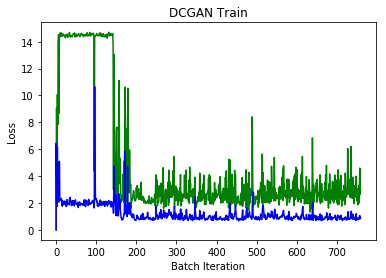

Epoch 96/190 :
     Batch 1/8 generator loss | discriminator loss : 2.3571804 | 0.7554658 - batch took 9.26996660232544 s.
     Batch 2/8 generator loss | discriminator loss : 3.1161444 | 0.9280127 - batch took 10.663913488388062 s.
     Batch 3/8 generator loss | discriminator loss : 1.7256606 | 0.8939946 - batch took 11.905476808547974 s.
     Batch 4/8 generator loss | discriminator loss : 5.3626995 | 1.1164008 - batch took 11.556563377380371 s.
     Batch 5/8 generator loss | discriminator loss : 3.747182 | 1.3577307 - batch took 12.211384296417236 s.
     Batch 6/8 generator loss | discriminator loss : 2.0904565 | 0.74442697 - batch took 11.288875818252563 s.
     Batch 7/8 generator loss | discriminator loss : 2.5809324 | 0.8275845 - batch took 10.76496148109436 s.
     Batch 8/8 generator loss | discriminator loss : 2.4181488 | 0.7554619 - batch took 8.917750597000122 s.


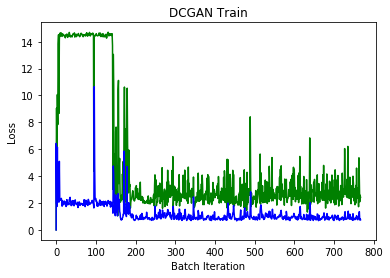

Epoch 97/190 :
     Batch 1/8 generator loss | discriminator loss : 2.42888 | 0.7848519 - batch took 8.835752010345459 s.
     Batch 2/8 generator loss | discriminator loss : 2.7830298 | 0.76341444 - batch took 8.304693937301636 s.
     Batch 3/8 generator loss | discriminator loss : 2.1672904 | 0.73390245 - batch took 9.399107456207275 s.
     Batch 4/8 generator loss | discriminator loss : 4.203092 | 0.9413918 - batch took 8.642614364624023 s.
     Batch 5/8 generator loss | discriminator loss : 2.7145233 | 0.940022 - batch took 8.454735040664673 s.
     Batch 6/8 generator loss | discriminator loss : 4.274868 | 0.9286791 - batch took 7.723593711853027 s.
     Batch 7/8 generator loss | discriminator loss : 2.7490094 | 0.9736166 - batch took 8.457380294799805 s.
     Batch 8/8 generator loss | discriminator loss : 4.05856 | 1.0831522 - batch took 7.705026388168335 s.


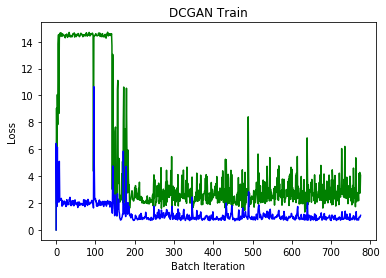

Epoch 98/190 :
     Batch 1/8 generator loss | discriminator loss : 3.1218271 | 0.9535486 - batch took 10.606235265731812 s.
     Batch 2/8 generator loss | discriminator loss : 3.1892185 | 0.9335288 - batch took 6.884416818618774 s.
     Batch 3/8 generator loss | discriminator loss : 2.8177936 | 0.79934216 - batch took 7.174715995788574 s.
     Batch 4/8 generator loss | discriminator loss : 3.484862 | 1.0480945 - batch took 6.676172256469727 s.
     Batch 5/8 generator loss | discriminator loss : 2.3245208 | 0.8081016 - batch took 8.123778581619263 s.
     Batch 6/8 generator loss | discriminator loss : 3.737055 | 0.88499516 - batch took 7.047183275222778 s.
     Batch 7/8 generator loss | discriminator loss : 2.0118062 | 0.9336966 - batch took 7.266592025756836 s.
     Batch 8/8 generator loss | discriminator loss : 3.9710016 | 1.1415176 - batch took 7.314476251602173 s.


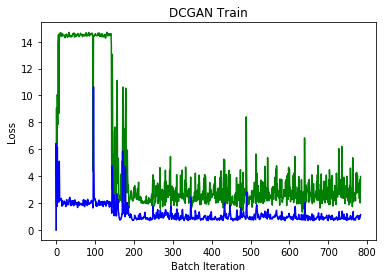

Epoch 99/190 :
     Batch 1/8 generator loss | discriminator loss : 2.7655642 | 1.0093794 - batch took 7.809148073196411 s.
     Batch 2/8 generator loss | discriminator loss : 2.859162 | 0.9403707 - batch took 7.164869070053101 s.
     Batch 3/8 generator loss | discriminator loss : 2.9577918 | 0.7946833 - batch took 7.474967956542969 s.
     Batch 4/8 generator loss | discriminator loss : 2.0410101 | 0.8769679 - batch took 6.668893575668335 s.
     Batch 5/8 generator loss | discriminator loss : 3.2935286 | 0.85611415 - batch took 7.184636116027832 s.
     Batch 6/8 generator loss | discriminator loss : 2.222351 | 0.7616445 - batch took 6.811593294143677 s.
     Batch 7/8 generator loss | discriminator loss : 3.4399183 | 1.0074484 - batch took 6.63604474067688 s.
     Batch 8/8 generator loss | discriminator loss : 2.0307212 | 1.0092154 - batch took 7.335256576538086 s.


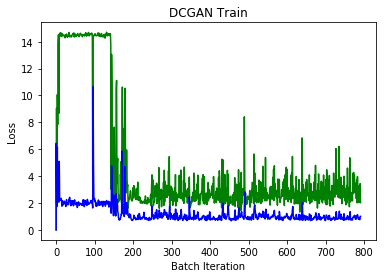

Epoch 100/190 :
     Batch 1/8 generator loss | discriminator loss : 3.120047 | 0.90956205 - batch took 6.577195644378662 s.
     Batch 2/8 generator loss | discriminator loss : 1.8795999 | 0.87446326 - batch took 7.398099184036255 s.
     Batch 3/8 generator loss | discriminator loss : 3.9921317 | 0.9757832 - batch took 6.637052297592163 s.
     Batch 4/8 generator loss | discriminator loss : 3.1583993 | 0.93076605 - batch took 7.032588005065918 s.
     Batch 5/8 generator loss | discriminator loss : 3.4289536 | 0.95893717 - batch took 6.631063222885132 s.
     Batch 6/8 generator loss | discriminator loss : 2.8741333 | 0.79323614 - batch took 6.582185506820679 s.
     Batch 7/8 generator loss | discriminator loss : 3.4973485 | 0.97017914 - batch took 6.987148284912109 s.
     Batch 8/8 generator loss | discriminator loss : 2.4417634 | 0.8573545 - batch took 6.662971019744873 s.


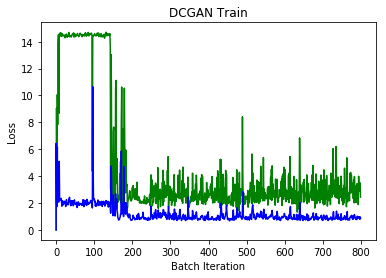

Epoch 101/190 :
     Batch 1/8 generator loss | discriminator loss : 4.1451983 | 1.0294886 - batch took 6.808610916137695 s.
     Batch 2/8 generator loss | discriminator loss : 2.5657592 | 0.99324924 - batch took 6.596147775650024 s.
     Batch 3/8 generator loss | discriminator loss : 3.346272 | 0.9477037 - batch took 6.836529970169067 s.
     Batch 4/8 generator loss | discriminator loss : 2.439435 | 0.77484953 - batch took 6.6430277824401855 s.
     Batch 5/8 generator loss | discriminator loss : 2.118002 | 0.795807 - batch took 6.7766828536987305 s.
     Batch 6/8 generator loss | discriminator loss : 2.240194 | 0.742553 - batch took 6.764715909957886 s.
     Batch 7/8 generator loss | discriminator loss : 3.5032074 | 1.0405083 - batch took 6.887400150299072 s.
     Batch 8/8 generator loss | discriminator loss : 1.8096519 | 0.92019254 - batch took 7.515793323516846 s.


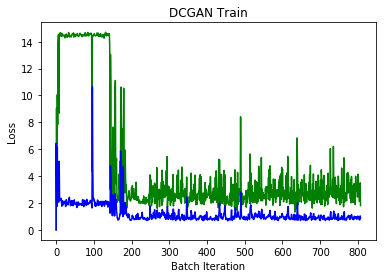

Epoch 102/190 :
     Batch 1/8 generator loss | discriminator loss : 4.1076245 | 1.0048946 - batch took 8.503952264785767 s.
     Batch 2/8 generator loss | discriminator loss : 3.2605612 | 0.8907664 - batch took 7.514162540435791 s.
     Batch 3/8 generator loss | discriminator loss : 2.36547 | 1.005042 - batch took 7.0132646560668945 s.
     Batch 4/8 generator loss | discriminator loss : 2.1259205 | 0.70631015 - batch took 7.062950611114502 s.
     Batch 5/8 generator loss | discriminator loss : 3.4853518 | 1.0369784 - batch took 6.746260166168213 s.
     Batch 6/8 generator loss | discriminator loss : 2.3047798 | 0.8168854 - batch took 6.589164972305298 s.
     Batch 7/8 generator loss | discriminator loss : 3.745809 | 0.9198196 - batch took 7.016075611114502 s.
     Batch 8/8 generator loss | discriminator loss : 2.9920413 | 0.8748387 - batch took 6.938255071640015 s.


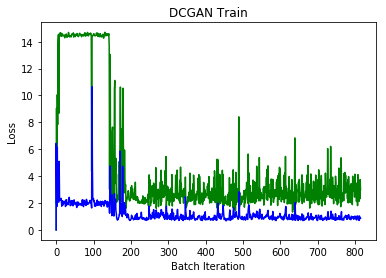

Epoch 103/190 :
     Batch 1/8 generator loss | discriminator loss : 2.720954 | 0.7784055 - batch took 7.310323715209961 s.
     Batch 2/8 generator loss | discriminator loss : 2.4763775 | 0.80659443 - batch took 6.886400938034058 s.
     Batch 3/8 generator loss | discriminator loss : 3.554608 | 0.8831664 - batch took 6.98515248298645 s.
     Batch 4/8 generator loss | discriminator loss : 2.520735 | 0.862332 - batch took 6.981163263320923 s.
     Batch 5/8 generator loss | discriminator loss : 3.3041308 | 0.9188546 - batch took 6.919320106506348 s.
     Batch 6/8 generator loss | discriminator loss : 2.816305 | 0.7571349 - batch took 8.009532928466797 s.
     Batch 7/8 generator loss | discriminator loss : 2.6661572 | 0.8598726 - batch took 7.3372461795806885 s.
     Batch 8/8 generator loss | discriminator loss : 2.8261738 | 0.75402176 - batch took 8.072974681854248 s.


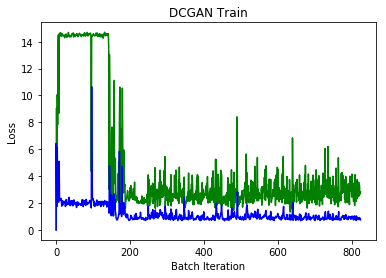

Epoch 104/190 :
     Batch 1/8 generator loss | discriminator loss : 2.124203 | 0.7445133 - batch took 8.238576650619507 s.
     Batch 2/8 generator loss | discriminator loss : 2.9870734 | 0.84160537 - batch took 7.886191129684448 s.
     Batch 3/8 generator loss | discriminator loss : 2.436502 | 0.7090647 - batch took 7.896562337875366 s.
     Batch 4/8 generator loss | discriminator loss : 3.3217678 | 0.8071219 - batch took 7.856649875640869 s.
     Batch 5/8 generator loss | discriminator loss : 1.9681602 | 0.8285544 - batch took 7.402157545089722 s.
     Batch 6/8 generator loss | discriminator loss : 5.8152885 | 1.2320213 - batch took 7.601376533508301 s.
     Batch 7/8 generator loss | discriminator loss : 3.447989 | 1.5035985 - batch took 7.709744691848755 s.
     Batch 8/8 generator loss | discriminator loss : 2.328912 | 0.8695225 - batch took 8.467789888381958 s.


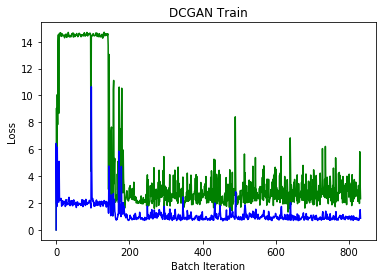

Epoch 105/190 :
     Batch 1/8 generator loss | discriminator loss : 2.0192573 | 0.7751205 - batch took 8.535569190979004 s.
     Batch 2/8 generator loss | discriminator loss : 2.9469771 | 0.86073756 - batch took 8.01949429512024 s.
     Batch 3/8 generator loss | discriminator loss : 2.5980368 | 1.0195112 - batch took 7.51993989944458 s.
     Batch 4/8 generator loss | discriminator loss : 2.3533192 | 0.70432436 - batch took 7.825440168380737 s.
     Batch 5/8 generator loss | discriminator loss : 2.7022011 | 0.95821166 - batch took 7.903783082962036 s.
     Batch 6/8 generator loss | discriminator loss : 2.4083571 | 0.70819014 - batch took 9.124725103378296 s.
     Batch 7/8 generator loss | discriminator loss : 3.3550239 | 0.9250066 - batch took 8.552366733551025 s.
     Batch 8/8 generator loss | discriminator loss : 2.2739925 | 0.8608006 - batch took 7.832167863845825 s.


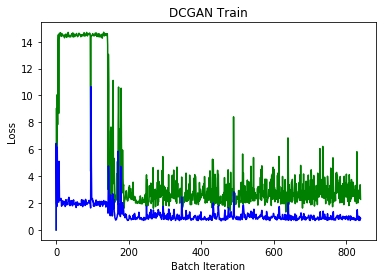

Epoch 106/190 :
     Batch 1/8 generator loss | discriminator loss : 4.7316766 | 1.1194624 - batch took 9.680668592453003 s.
     Batch 2/8 generator loss | discriminator loss : 3.5501864 | 1.0924726 - batch took 7.248342037200928 s.
     Batch 3/8 generator loss | discriminator loss : 2.181368 | 0.77250075 - batch took 7.027794122695923 s.
     Batch 4/8 generator loss | discriminator loss : 3.5562232 | 0.82330686 - batch took 6.805126905441284 s.
     Batch 5/8 generator loss | discriminator loss : 2.3167613 | 0.89330494 - batch took 6.540428876876831 s.
     Batch 6/8 generator loss | discriminator loss : 3.014232 | 0.8868774 - batch took 7.438663482666016 s.
     Batch 7/8 generator loss | discriminator loss : 2.666432 | 0.7373116 - batch took 8.155844688415527 s.
     Batch 8/8 generator loss | discriminator loss : 2.0847826 | 0.74326015 - batch took 7.772205114364624 s.


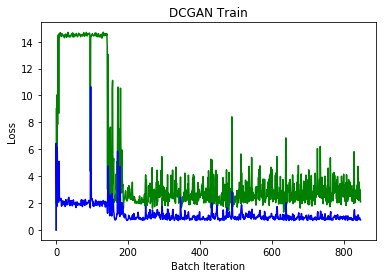

Epoch 107/190 :
     Batch 1/8 generator loss | discriminator loss : 3.0696175 | 0.69694847 - batch took 6.469599008560181 s.
     Batch 2/8 generator loss | discriminator loss : 2.273464 | 0.77232176 - batch took 6.830773830413818 s.
     Batch 3/8 generator loss | discriminator loss : 3.9973555 | 1.0119963 - batch took 6.774590253829956 s.
     Batch 4/8 generator loss | discriminator loss : 3.2604117 | 0.95711946 - batch took 7.02304482460022 s.
     Batch 5/8 generator loss | discriminator loss : 1.8380101 | 0.7853981 - batch took 6.712404012680054 s.
     Batch 6/8 generator loss | discriminator loss : 2.4940467 | 0.83255494 - batch took 6.531554222106934 s.
     Batch 7/8 generator loss | discriminator loss : 2.342405 | 0.73613834 - batch took 6.805037975311279 s.
     Batch 8/8 generator loss | discriminator loss : 3.2512476 | 0.8668117 - batch took 6.5835280418396 s.


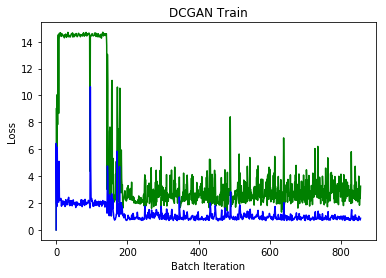

Epoch 108/190 :
     Batch 1/8 generator loss | discriminator loss : 2.577244 | 0.81784487 - batch took 7.460017204284668 s.
     Batch 2/8 generator loss | discriminator loss : 2.9890625 | 0.8906671 - batch took 6.474037170410156 s.
     Batch 3/8 generator loss | discriminator loss : 2.3164902 | 0.812297 - batch took 6.8584394454956055 s.
     Batch 4/8 generator loss | discriminator loss : 4.1141953 | 1.1273186 - batch took 6.650591135025024 s.
     Batch 5/8 generator loss | discriminator loss : 3.2150574 | 0.95763713 - batch took 6.651733875274658 s.
     Batch 6/8 generator loss | discriminator loss : 1.9146991 | 0.83567977 - batch took 6.87340235710144 s.
     Batch 7/8 generator loss | discriminator loss : 2.4412584 | 0.8297366 - batch took 6.703728675842285 s.
     Batch 8/8 generator loss | discriminator loss : 2.102474 | 0.69818926 - batch took 7.109851121902466 s.


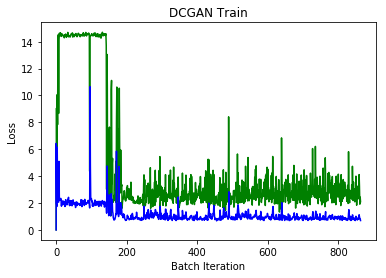

Epoch 109/190 :
     Batch 1/8 generator loss | discriminator loss : 2.4746518 | 0.85051095 - batch took 7.0092480182647705 s.
     Batch 2/8 generator loss | discriminator loss : 2.6116788 | 0.71271396 - batch took 7.062794923782349 s.
     Batch 3/8 generator loss | discriminator loss : 3.018909 | 0.94028854 - batch took 6.7192864418029785 s.
     Batch 4/8 generator loss | discriminator loss : 2.572138 | 0.65394163 - batch took 6.581362247467041 s.
     Batch 5/8 generator loss | discriminator loss : 3.896071 | 0.8261299 - batch took 6.946552276611328 s.
     Batch 6/8 generator loss | discriminator loss : 2.486013 | 0.85622776 - batch took 6.671582221984863 s.
     Batch 7/8 generator loss | discriminator loss : 4.3079 | 0.97296274 - batch took 7.0934929847717285 s.
     Batch 8/8 generator loss | discriminator loss : 3.8947005 | 0.9124227 - batch took 6.735596179962158 s.


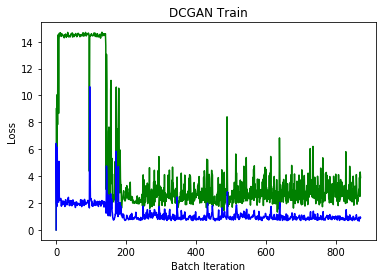

Epoch 110/190 :
     Batch 1/8 generator loss | discriminator loss : 2.0162945 | 0.8380981 - batch took 6.752203464508057 s.
     Batch 2/8 generator loss | discriminator loss : 2.4515111 | 0.7753234 - batch took 6.95441746711731 s.
     Batch 3/8 generator loss | discriminator loss : 2.5424912 | 0.761325 - batch took 6.796839475631714 s.
     Batch 4/8 generator loss | discriminator loss : 3.156892 | 0.8519575 - batch took 6.988765239715576 s.
     Batch 5/8 generator loss | discriminator loss : 2.458184 | 0.74123585 - batch took 7.15259313583374 s.
     Batch 6/8 generator loss | discriminator loss : 4.593144 | 0.90821314 - batch took 6.969278812408447 s.
     Batch 7/8 generator loss | discriminator loss : 2.7159138 | 0.9551209 - batch took 6.598225831985474 s.
     Batch 8/8 generator loss | discriminator loss : 5.6331415 | 1.1771659 - batch took 6.897924184799194 s.


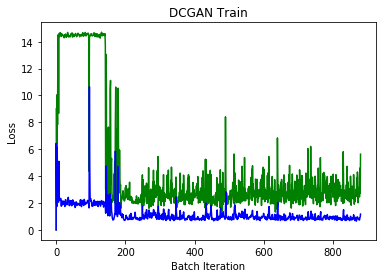

Epoch 111/190 :
     Batch 1/8 generator loss | discriminator loss : 2.6370203 | 1.3459966 - batch took 6.8573291301727295 s.
     Batch 2/8 generator loss | discriminator loss : 4.5108886 | 1.080235 - batch took 6.597707986831665 s.
     Batch 3/8 generator loss | discriminator loss : 2.6644142 | 0.9548491 - batch took 6.8844664096832275 s.
     Batch 4/8 generator loss | discriminator loss : 4.2560115 | 1.1498152 - batch took 6.600913763046265 s.
     Batch 5/8 generator loss | discriminator loss : 1.8717672 | 1.2788965 - batch took 8.579824686050415 s.
     Batch 6/8 generator loss | discriminator loss : 3.68336 | 1.102094 - batch took 8.19832992553711 s.
     Batch 7/8 generator loss | discriminator loss : 3.5031652 | 0.77055067 - batch took 7.065377950668335 s.
     Batch 8/8 generator loss | discriminator loss : 2.026695 | 0.82733977 - batch took 6.58561897277832 s.


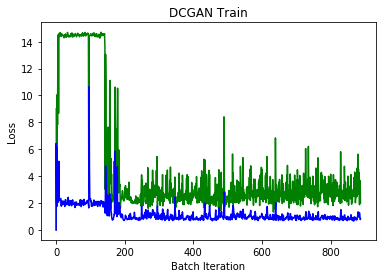

Epoch 112/190 :
     Batch 1/8 generator loss | discriminator loss : 4.949945 | 1.1729329 - batch took 6.931507587432861 s.
     Batch 2/8 generator loss | discriminator loss : 3.045175 | 1.2201352 - batch took 6.658382892608643 s.
     Batch 3/8 generator loss | discriminator loss : 4.321977 | 1.1226649 - batch took 6.683862209320068 s.
     Batch 4/8 generator loss | discriminator loss : 3.6356444 | 1.0194683 - batch took 6.827334403991699 s.
     Batch 5/8 generator loss | discriminator loss : 2.241026 | 0.7027004 - batch took 6.968388795852661 s.
     Batch 6/8 generator loss | discriminator loss : 2.6702173 | 0.84661824 - batch took 7.060208559036255 s.
     Batch 7/8 generator loss | discriminator loss : 1.9987491 | 0.8020246 - batch took 6.723577976226807 s.
     Batch 8/8 generator loss | discriminator loss : 2.710681 | 0.81904864 - batch took 6.88941764831543 s.


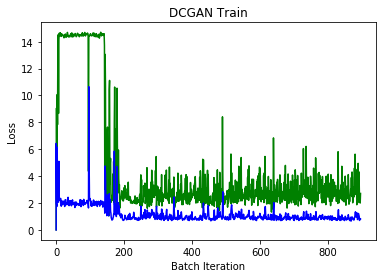

Epoch 113/190 :
     Batch 1/8 generator loss | discriminator loss : 2.245846 | 0.7744684 - batch took 6.553399085998535 s.
     Batch 2/8 generator loss | discriminator loss : 2.9155602 | 0.92203045 - batch took 6.797777891159058 s.
     Batch 3/8 generator loss | discriminator loss : 2.7265592 | 0.7921418 - batch took 6.88517165184021 s.
     Batch 4/8 generator loss | discriminator loss : 3.215832 | 1.07218 - batch took 6.720900058746338 s.
     Batch 5/8 generator loss | discriminator loss : 2.1411264 | 0.7808683 - batch took 6.734534502029419 s.
     Batch 6/8 generator loss | discriminator loss : 4.04567 | 0.91795796 - batch took 6.734728813171387 s.
     Batch 7/8 generator loss | discriminator loss : 2.2125444 | 0.993664 - batch took 6.78505802154541 s.
     Batch 8/8 generator loss | discriminator loss : 3.494313 | 0.8963516 - batch took 6.649042129516602 s.


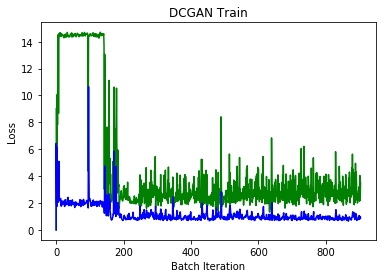

Epoch 114/190 :
     Batch 1/8 generator loss | discriminator loss : 2.7885833 | 0.8138738 - batch took 6.591758489608765 s.
     Batch 2/8 generator loss | discriminator loss : 3.4291663 | 1.0941033 - batch took 6.889451265335083 s.
     Batch 3/8 generator loss | discriminator loss : 2.1866457 | 0.86292684 - batch took 6.507746934890747 s.
     Batch 4/8 generator loss | discriminator loss : 4.3591423 | 1.0676229 - batch took 6.779144287109375 s.
     Batch 5/8 generator loss | discriminator loss : 4.0952306 | 0.931224 - batch took 6.704044818878174 s.
     Batch 6/8 generator loss | discriminator loss : 1.653508 | 0.8241367 - batch took 7.290102005004883 s.
     Batch 7/8 generator loss | discriminator loss : 3.1319885 | 0.9866534 - batch took 6.601171970367432 s.
     Batch 8/8 generator loss | discriminator loss : 2.4485698 | 0.9353001 - batch took 6.610245704650879 s.


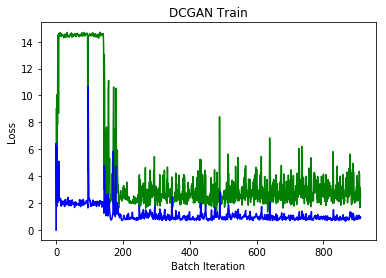

Epoch 115/190 :
     Batch 1/8 generator loss | discriminator loss : 2.7456412 | 0.879262 - batch took 7.297333002090454 s.
     Batch 2/8 generator loss | discriminator loss : 2.4357805 | 0.77600014 - batch took 6.676364898681641 s.
     Batch 3/8 generator loss | discriminator loss : 1.921822 | 0.7378459 - batch took 6.823057174682617 s.
     Batch 4/8 generator loss | discriminator loss : 2.87781 | 0.78368723 - batch took 6.683290243148804 s.
     Batch 5/8 generator loss | discriminator loss : 2.338664 | 0.8400959 - batch took 6.688322305679321 s.
     Batch 6/8 generator loss | discriminator loss : 2.719751 | 0.75922674 - batch took 6.810646295547485 s.
     Batch 7/8 generator loss | discriminator loss : 2.640173 | 0.73382056 - batch took 6.576266765594482 s.
     Batch 8/8 generator loss | discriminator loss : 3.312276 | 0.8197907 - batch took 6.772156476974487 s.


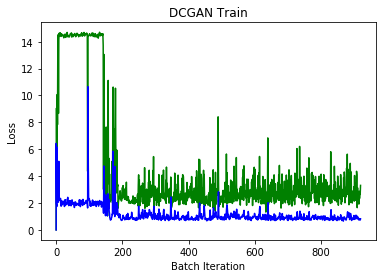

Epoch 116/190 :
     Batch 1/8 generator loss | discriminator loss : 2.2420168 | 0.723133 - batch took 6.9476158618927 s.
     Batch 2/8 generator loss | discriminator loss : 4.6864276 | 1.0472481 - batch took 6.868861436843872 s.
     Batch 3/8 generator loss | discriminator loss : 3.4755652 | 1.0766865 - batch took 6.725975513458252 s.
     Batch 4/8 generator loss | discriminator loss : 3.221502 | 0.96910685 - batch took 6.4323790073394775 s.
     Batch 5/8 generator loss | discriminator loss : 2.6826324 | 0.6887566 - batch took 6.546935558319092 s.
     Batch 6/8 generator loss | discriminator loss : 3.3269165 | 0.89162123 - batch took 6.49790620803833 s.
     Batch 7/8 generator loss | discriminator loss : 2.5440938 | 0.8068727 - batch took 6.843316555023193 s.
     Batch 8/8 generator loss | discriminator loss : 3.3393567 | 0.8878341 - batch took 6.531755208969116 s.


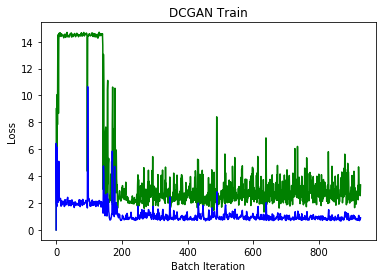

Epoch 117/190 :
     Batch 1/8 generator loss | discriminator loss : 2.354634 | 0.73278475 - batch took 6.831525802612305 s.
     Batch 2/8 generator loss | discriminator loss : 3.7890744 | 0.9223863 - batch took 6.606790542602539 s.
     Batch 3/8 generator loss | discriminator loss : 2.8397894 | 0.86119175 - batch took 7.151502370834351 s.
     Batch 4/8 generator loss | discriminator loss : 3.4757226 | 0.80162996 - batch took 6.496806859970093 s.
     Batch 5/8 generator loss | discriminator loss : 2.2809582 | 0.8471625 - batch took 6.4428040981292725 s.
     Batch 6/8 generator loss | discriminator loss : 3.8851001 | 0.8937795 - batch took 7.0052924156188965 s.
     Batch 7/8 generator loss | discriminator loss : 2.7004352 | 0.89198875 - batch took 6.509221315383911 s.
     Batch 8/8 generator loss | discriminator loss : 3.8762145 | 0.9980569 - batch took 6.829932928085327 s.


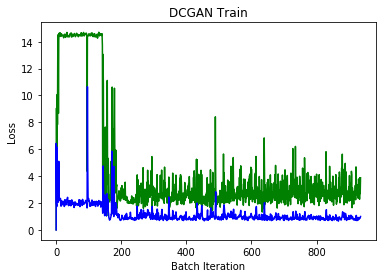

Epoch 118/190 :
     Batch 1/8 generator loss | discriminator loss : 3.284643 | 0.8130551 - batch took 6.7460808753967285 s.
     Batch 2/8 generator loss | discriminator loss : 2.073851 | 0.77084607 - batch took 6.536412477493286 s.
     Batch 3/8 generator loss | discriminator loss : 3.094865 | 0.8896736 - batch took 6.656205892562866 s.
     Batch 4/8 generator loss | discriminator loss : 2.2346277 | 0.9381968 - batch took 7.016465663909912 s.
     Batch 5/8 generator loss | discriminator loss : 2.7376523 | 0.87959063 - batch took 6.984249830245972 s.
     Batch 6/8 generator loss | discriminator loss : 2.3818917 | 0.74966276 - batch took 6.674274921417236 s.
     Batch 7/8 generator loss | discriminator loss : 2.7225764 | 0.7682453 - batch took 6.370544672012329 s.
     Batch 8/8 generator loss | discriminator loss : 2.0147312 | 0.7865429 - batch took 6.602211236953735 s.


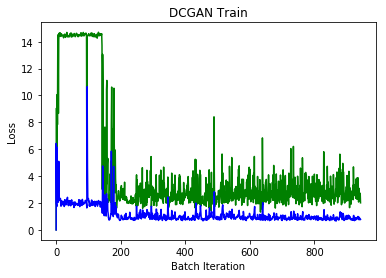

Epoch 119/190 :
     Batch 1/8 generator loss | discriminator loss : 2.9682028 | 0.84205127 - batch took 6.6032185554504395 s.
     Batch 2/8 generator loss | discriminator loss : 2.3366158 | 0.76905966 - batch took 6.71136999130249 s.
     Batch 3/8 generator loss | discriminator loss : 4.321502 | 1.0436378 - batch took 6.577900648117065 s.
     Batch 4/8 generator loss | discriminator loss : 3.9720619 | 1.0597351 - batch took 6.723236083984375 s.
     Batch 5/8 generator loss | discriminator loss : 1.7994808 | 0.72226524 - batch took 6.508246660232544 s.
     Batch 6/8 generator loss | discriminator loss : 2.6788201 | 0.8731037 - batch took 6.520090103149414 s.
     Batch 7/8 generator loss | discriminator loss : 2.2712467 | 0.7886528 - batch took 6.552236557006836 s.
     Batch 8/8 generator loss | discriminator loss : 2.6590044 | 0.781978 - batch took 6.659723281860352 s.


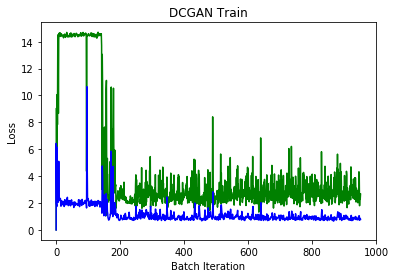

Epoch 120/190 :
     Batch 1/8 generator loss | discriminator loss : 2.7250593 | 0.68153524 - batch took 6.894564151763916 s.
     Batch 2/8 generator loss | discriminator loss : 1.9595298 | 0.73162884 - batch took 6.796119213104248 s.
     Batch 3/8 generator loss | discriminator loss : 3.6866465 | 0.96228427 - batch took 6.559571981430054 s.
     Batch 4/8 generator loss | discriminator loss : 2.8155212 | 0.93043995 - batch took 6.595804929733276 s.
     Batch 5/8 generator loss | discriminator loss : 2.7205775 | 0.77983665 - batch took 6.52665376663208 s.
     Batch 6/8 generator loss | discriminator loss : 2.6696868 | 0.67343736 - batch took 6.671028137207031 s.
     Batch 7/8 generator loss | discriminator loss : 2.248724 | 0.8116794 - batch took 6.61035680770874 s.
     Batch 8/8 generator loss | discriminator loss : 2.8975348 | 0.7815281 - batch took 6.606587171554565 s.


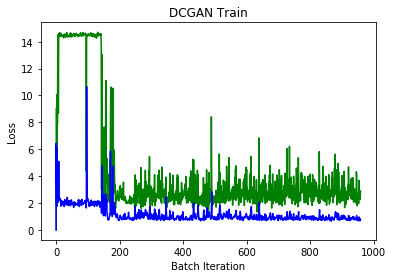

Epoch 121/190 :
     Batch 1/8 generator loss | discriminator loss : 2.3649387 | 0.6927637 - batch took 6.661541700363159 s.
     Batch 2/8 generator loss | discriminator loss : 2.6065335 | 0.7100109 - batch took 6.65159010887146 s.
     Batch 3/8 generator loss | discriminator loss : 2.5046766 | 0.7586256 - batch took 7.078670501708984 s.
     Batch 4/8 generator loss | discriminator loss : 2.9448595 | 0.7303883 - batch took 6.5863871574401855 s.
     Batch 5/8 generator loss | discriminator loss : 1.8865428 | 0.77315676 - batch took 6.7215471267700195 s.
     Batch 6/8 generator loss | discriminator loss : 3.8587153 | 0.868719 - batch took 6.47022819519043 s.
     Batch 7/8 generator loss | discriminator loss : 3.210304 | 0.8096912 - batch took 6.803085803985596 s.
     Batch 8/8 generator loss | discriminator loss : 2.1094332 | 0.69297904 - batch took 6.646463632583618 s.


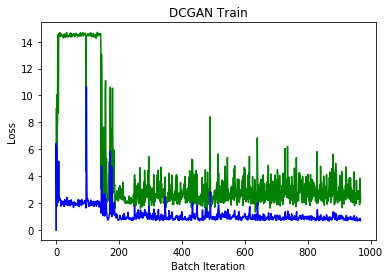

Epoch 122/190 :
     Batch 1/8 generator loss | discriminator loss : 3.7142022 | 0.8036401 - batch took 6.540771007537842 s.
     Batch 2/8 generator loss | discriminator loss : 2.9612565 | 0.7585865 - batch took 6.722712993621826 s.
     Batch 3/8 generator loss | discriminator loss : 3.3302217 | 0.8113173 - batch took 6.495166778564453 s.
     Batch 4/8 generator loss | discriminator loss : 1.9710649 | 0.79223365 - batch took 6.866767168045044 s.
     Batch 5/8 generator loss | discriminator loss : 5.066272 | 1.0913503 - batch took 6.5991857051849365 s.
     Batch 6/8 generator loss | discriminator loss : 3.6653168 | 1.2018287 - batch took 6.539281845092773 s.
     Batch 7/8 generator loss | discriminator loss : 2.1495566 | 0.78231835 - batch took 6.848249912261963 s.
     Batch 8/8 generator loss | discriminator loss : 2.6604886 | 0.75271165 - batch took 6.478444814682007 s.


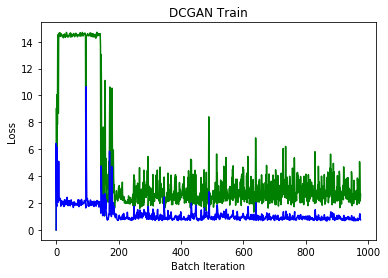

Epoch 123/190 :
     Batch 1/8 generator loss | discriminator loss : 2.1054401 | 0.7364437 - batch took 6.812471866607666 s.
     Batch 2/8 generator loss | discriminator loss : 3.099316 | 0.799252 - batch took 6.5825934410095215 s.
     Batch 3/8 generator loss | discriminator loss : 2.5747411 | 0.75798535 - batch took 6.568195819854736 s.
     Batch 4/8 generator loss | discriminator loss : 4.6788297 | 1.0550935 - batch took 6.5525970458984375 s.
     Batch 5/8 generator loss | discriminator loss : 3.9674041 | 0.9397578 - batch took 6.687550067901611 s.
     Batch 6/8 generator loss | discriminator loss : 3.538268 | 0.93028045 - batch took 6.672615051269531 s.
     Batch 7/8 generator loss | discriminator loss : 2.134183 | 0.77151924 - batch took 6.568167209625244 s.
     Batch 8/8 generator loss | discriminator loss : 3.5080378 | 0.908974 - batch took 7.1241960525512695 s.


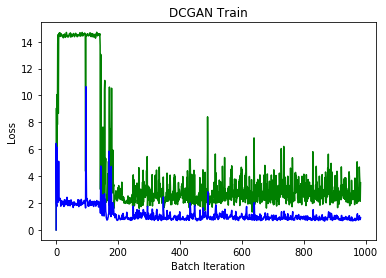

Epoch 124/190 :
     Batch 1/8 generator loss | discriminator loss : 3.1482954 | 0.7933246 - batch took 6.317413091659546 s.
     Batch 2/8 generator loss | discriminator loss : 2.0325685 | 0.8046042 - batch took 6.78821873664856 s.
     Batch 3/8 generator loss | discriminator loss : 3.2876587 | 0.81769097 - batch took 6.650562763214111 s.
     Batch 4/8 generator loss | discriminator loss : 2.102171 | 0.7022189 - batch took 6.6844587326049805 s.
     Batch 5/8 generator loss | discriminator loss : 4.1433916 | 0.88556784 - batch took 6.96830677986145 s.
     Batch 6/8 generator loss | discriminator loss : 2.6748855 | 0.90748644 - batch took 6.680912256240845 s.
     Batch 7/8 generator loss | discriminator loss : 3.690343 | 0.8665698 - batch took 6.518733024597168 s.
     Batch 8/8 generator loss | discriminator loss : 2.4261801 | 0.8855261 - batch took 6.699421167373657 s.


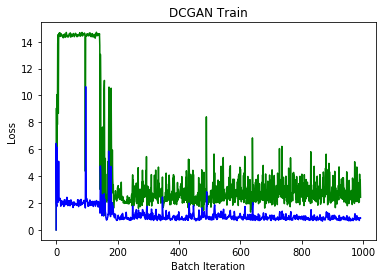

Epoch 125/190 :
     Batch 1/8 generator loss | discriminator loss : 3.0828967 | 0.86890626 - batch took 6.535315990447998 s.
     Batch 2/8 generator loss | discriminator loss : 2.3700013 | 0.7603935 - batch took 6.707765340805054 s.
     Batch 3/8 generator loss | discriminator loss : 4.0343947 | 0.91770023 - batch took 6.734419584274292 s.
     Batch 4/8 generator loss | discriminator loss : 2.3760972 | 0.9366206 - batch took 6.751507043838501 s.
     Batch 5/8 generator loss | discriminator loss : 4.983911 | 1.085856 - batch took 6.464621305465698 s.
     Batch 6/8 generator loss | discriminator loss : 3.7853913 | 1.0280179 - batch took 6.859911203384399 s.
     Batch 7/8 generator loss | discriminator loss : 2.6191528 | 0.8450477 - batch took 6.796830177307129 s.
     Batch 8/8 generator loss | discriminator loss : 2.212008 | 0.7608423 - batch took 6.540750980377197 s.


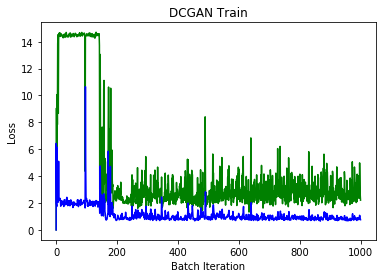

Epoch 126/190 :
     Batch 1/8 generator loss | discriminator loss : 2.6044648 | 0.7934264 - batch took 6.883545637130737 s.
     Batch 2/8 generator loss | discriminator loss : 2.5967553 | 0.66684127 - batch took 6.584628105163574 s.
     Batch 3/8 generator loss | discriminator loss : 2.6295147 | 0.79672265 - batch took 6.858487367630005 s.
     Batch 4/8 generator loss | discriminator loss : 3.5615442 | 0.8646544 - batch took 6.547744035720825 s.
     Batch 5/8 generator loss | discriminator loss : 2.607239 | 0.7389323 - batch took 6.802358150482178 s.
     Batch 6/8 generator loss | discriminator loss : 4.182359 | 0.8636958 - batch took 6.569942235946655 s.
     Batch 7/8 generator loss | discriminator loss : 2.1943305 | 0.99167824 - batch took 6.623411417007446 s.
     Batch 8/8 generator loss | discriminator loss : 4.6827703 | 0.99052584 - batch took 7.001590251922607 s.


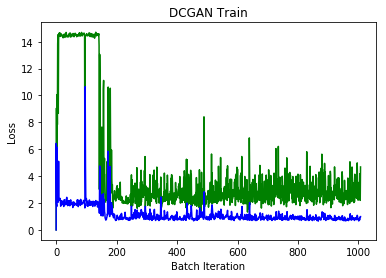

Epoch 127/190 :
     Batch 1/8 generator loss | discriminator loss : 3.8192127 | 0.87952054 - batch took 6.6479175090789795 s.
     Batch 2/8 generator loss | discriminator loss : 2.5217578 | 0.7896465 - batch took 6.769567251205444 s.
     Batch 3/8 generator loss | discriminator loss : 3.5095696 | 0.9638109 - batch took 6.954263210296631 s.
     Batch 4/8 generator loss | discriminator loss : 2.842494 | 0.7681761 - batch took 6.454249858856201 s.
     Batch 5/8 generator loss | discriminator loss : 3.7716084 | 1.0597166 - batch took 6.774255990982056 s.
     Batch 6/8 generator loss | discriminator loss : 2.8450766 | 0.9149419 - batch took 6.471157789230347 s.
     Batch 7/8 generator loss | discriminator loss : 2.0478158 | 0.731985 - batch took 6.810899496078491 s.
     Batch 8/8 generator loss | discriminator loss : 2.3970995 | 0.71913385 - batch took 6.805612564086914 s.


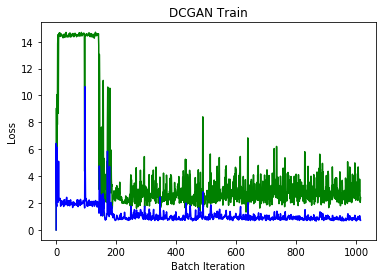

Epoch 128/190 :
     Batch 1/8 generator loss | discriminator loss : 1.9315312 | 0.76993644 - batch took 6.52419900894165 s.
     Batch 2/8 generator loss | discriminator loss : 4.3601866 | 0.9362007 - batch took 7.0282371044158936 s.
     Batch 3/8 generator loss | discriminator loss : 3.446221 | 0.97946584 - batch took 8.849785327911377 s.
     Batch 4/8 generator loss | discriminator loss : 3.065849 | 0.81630826 - batch took 7.39812159538269 s.
     Batch 5/8 generator loss | discriminator loss : 2.650426 | 0.7085568 - batch took 6.783409595489502 s.
     Batch 6/8 generator loss | discriminator loss : 3.423248 | 0.9404285 - batch took 7.0228776931762695 s.
     Batch 7/8 generator loss | discriminator loss : 2.3528316 | 0.796189 - batch took 7.912252187728882 s.
     Batch 8/8 generator loss | discriminator loss : 4.2895427 | 1.0473372 - batch took 6.890803098678589 s.


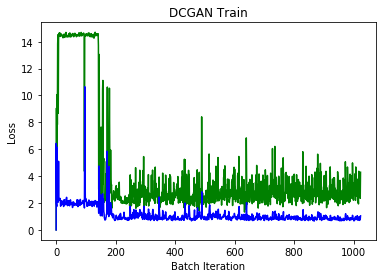

Epoch 129/190 :
     Batch 1/8 generator loss | discriminator loss : 3.9012485 | 0.9268242 - batch took 6.734468698501587 s.
     Batch 2/8 generator loss | discriminator loss : 2.0008502 | 0.8064088 - batch took 7.22646164894104 s.
     Batch 3/8 generator loss | discriminator loss : 3.189973 | 0.8282621 - batch took 6.755405426025391 s.
     Batch 4/8 generator loss | discriminator loss : 2.1873782 | 0.9927461 - batch took 6.704510450363159 s.
     Batch 5/8 generator loss | discriminator loss : 3.674514 | 0.88337183 - batch took 6.93731427192688 s.
     Batch 6/8 generator loss | discriminator loss : 3.1406085 | 0.69176316 - batch took 6.766369104385376 s.
     Batch 7/8 generator loss | discriminator loss : 2.570392 | 0.79911697 - batch took 6.937545537948608 s.
     Batch 8/8 generator loss | discriminator loss : 2.632164 | 0.69184744 - batch took 6.614349842071533 s.


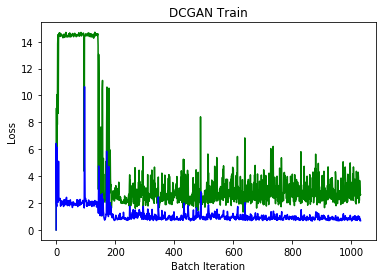

Epoch 130/190 :
     Batch 1/8 generator loss | discriminator loss : 2.4296439 | 0.7286837 - batch took 6.8565521240234375 s.
     Batch 2/8 generator loss | discriminator loss : 4.969033 | 0.9488982 - batch took 6.749643802642822 s.
     Batch 3/8 generator loss | discriminator loss : 2.8444464 | 1.077394 - batch took 6.474293947219849 s.
     Batch 4/8 generator loss | discriminator loss : 3.8303027 | 0.9575827 - batch took 6.717216491699219 s.
     Batch 5/8 generator loss | discriminator loss : 2.7213998 | 0.9488276 - batch took 6.897327899932861 s.
     Batch 6/8 generator loss | discriminator loss : 2.4287326 | 0.7916442 - batch took 6.610906362533569 s.
     Batch 7/8 generator loss | discriminator loss : 2.947939 | 0.80603975 - batch took 6.683782339096069 s.
     Batch 8/8 generator loss | discriminator loss : 1.9728223 | 0.7709842 - batch took 6.857395172119141 s.


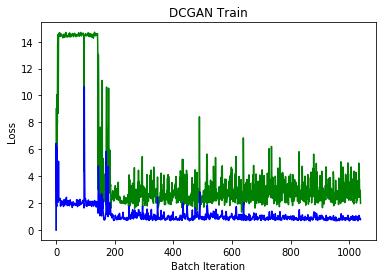

Epoch 131/190 :
     Batch 1/8 generator loss | discriminator loss : 3.960797 | 0.8831539 - batch took 6.881626605987549 s.
     Batch 2/8 generator loss | discriminator loss : 2.8712358 | 0.929351 - batch took 6.818933486938477 s.
     Batch 3/8 generator loss | discriminator loss : 3.4011762 | 0.8243302 - batch took 6.698288440704346 s.
     Batch 4/8 generator loss | discriminator loss : 2.839215 | 0.7295227 - batch took 6.5050578117370605 s.
     Batch 5/8 generator loss | discriminator loss : 2.8106127 | 0.831118 - batch took 6.824071645736694 s.
     Batch 6/8 generator loss | discriminator loss : 2.1298058 | 0.7235879 - batch took 6.453521966934204 s.
     Batch 7/8 generator loss | discriminator loss : 2.8534522 | 0.79970616 - batch took 6.505285978317261 s.
     Batch 8/8 generator loss | discriminator loss : 2.299243 | 0.759218 - batch took 6.69419264793396 s.


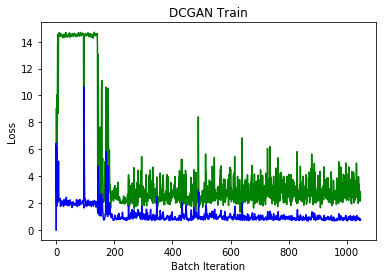

Epoch 132/190 :
     Batch 1/8 generator loss | discriminator loss : 2.9360926 | 0.79906505 - batch took 6.476829528808594 s.
     Batch 2/8 generator loss | discriminator loss : 2.3210268 | 0.73784244 - batch took 6.721915006637573 s.
     Batch 3/8 generator loss | discriminator loss : 4.8588557 | 0.90268695 - batch took 6.572650194168091 s.
     Batch 4/8 generator loss | discriminator loss : 3.1383996 | 1.0279541 - batch took 6.920805931091309 s.
     Batch 5/8 generator loss | discriminator loss : 3.755269 | 1.0118558 - batch took 6.547746181488037 s.
     Batch 6/8 generator loss | discriminator loss : 2.718116 | 0.77738893 - batch took 6.450294733047485 s.
     Batch 7/8 generator loss | discriminator loss : 3.011514 | 0.8558351 - batch took 6.922426462173462 s.
     Batch 8/8 generator loss | discriminator loss : 2.358757 | 0.76289856 - batch took 6.47995400428772 s.


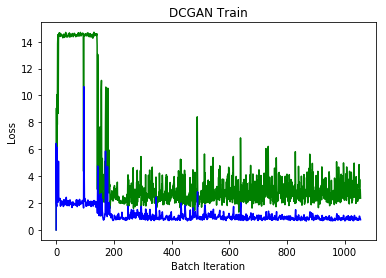

Epoch 133/190 :
     Batch 1/8 generator loss | discriminator loss : 2.7979488 | 0.800367 - batch took 6.910797595977783 s.
     Batch 2/8 generator loss | discriminator loss : 2.0092928 | 0.7539398 - batch took 6.722833633422852 s.
     Batch 3/8 generator loss | discriminator loss : 4.3510227 | 1.0436332 - batch took 6.521432876586914 s.
     Batch 4/8 generator loss | discriminator loss : 3.7136533 | 0.8926975 - batch took 6.563817501068115 s.
     Batch 5/8 generator loss | discriminator loss : 2.2717233 | 0.7870637 - batch took 6.526318311691284 s.
     Batch 6/8 generator loss | discriminator loss : 2.2679422 | 0.74146044 - batch took 6.943792819976807 s.
     Batch 7/8 generator loss | discriminator loss : 2.5373476 | 0.7816904 - batch took 6.504676342010498 s.
     Batch 8/8 generator loss | discriminator loss : 2.2118602 | 0.7404179 - batch took 7.01456880569458 s.


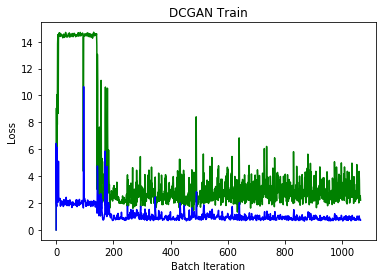

Epoch 134/190 :
     Batch 1/8 generator loss | discriminator loss : 2.776569 | 0.7484678 - batch took 6.726307153701782 s.
     Batch 2/8 generator loss | discriminator loss : 2.2002194 | 0.6977798 - batch took 6.59198522567749 s.
     Batch 3/8 generator loss | discriminator loss : 3.2257984 | 0.9283892 - batch took 6.579850196838379 s.
     Batch 4/8 generator loss | discriminator loss : 2.3463163 | 0.85257137 - batch took 6.416624307632446 s.
     Batch 5/8 generator loss | discriminator loss : 2.205034 | 0.75678 - batch took 7.047462224960327 s.
     Batch 6/8 generator loss | discriminator loss : 2.9947858 | 0.72222865 - batch took 6.597543001174927 s.
     Batch 7/8 generator loss | discriminator loss : 2.2978709 | 0.68431365 - batch took 6.663896083831787 s.
     Batch 8/8 generator loss | discriminator loss : 3.2440176 | 0.8229376 - batch took 6.57691502571106 s.


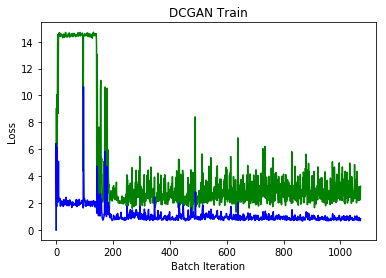

Epoch 135/190 :
     Batch 1/8 generator loss | discriminator loss : 2.824092 | 0.6905205 - batch took 6.534559726715088 s.
     Batch 2/8 generator loss | discriminator loss : 2.6153197 | 0.739823 - batch took 6.562439680099487 s.
     Batch 3/8 generator loss | discriminator loss : 2.5185637 | 0.7543722 - batch took 6.4995057582855225 s.
     Batch 4/8 generator loss | discriminator loss : 3.2437415 | 0.88137287 - batch took 7.280100345611572 s.
     Batch 5/8 generator loss | discriminator loss : 2.2461753 | 0.778113 - batch took 6.496988773345947 s.
     Batch 6/8 generator loss | discriminator loss : 4.3921213 | 0.8971236 - batch took 6.579592704772949 s.
     Batch 7/8 generator loss | discriminator loss : 2.8756745 | 1.0404153 - batch took 6.625216960906982 s.
     Batch 8/8 generator loss | discriminator loss : 2.8550308 | 0.8561512 - batch took 6.645633935928345 s.


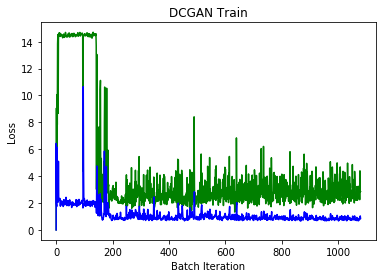

Epoch 136/190 :
     Batch 1/8 generator loss | discriminator loss : 2.5775378 | 0.7264872 - batch took 6.85951828956604 s.
     Batch 2/8 generator loss | discriminator loss : 2.1248333 | 0.71659803 - batch took 6.5086987018585205 s.
     Batch 3/8 generator loss | discriminator loss : 3.6500638 | 0.82023305 - batch took 6.748920440673828 s.
     Batch 4/8 generator loss | discriminator loss : 1.9960246 | 0.9816997 - batch took 6.782641172409058 s.
     Batch 5/8 generator loss | discriminator loss : 5.0368886 | 1.1002411 - batch took 6.9174559116363525 s.
     Batch 6/8 generator loss | discriminator loss : 4.769575 | 1.0565786 - batch took 6.546170711517334 s.
     Batch 7/8 generator loss | discriminator loss : 2.1725233 | 0.85793644 - batch took 6.655249357223511 s.
     Batch 8/8 generator loss | discriminator loss : 2.8052208 | 0.8602923 - batch took 6.848364353179932 s.


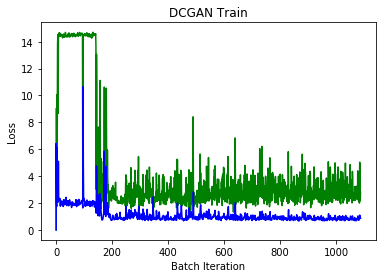

Epoch 137/190 :
     Batch 1/8 generator loss | discriminator loss : 2.53401 | 0.7071355 - batch took 6.355494022369385 s.
     Batch 2/8 generator loss | discriminator loss : 2.668092 | 0.93359524 - batch took 6.471999883651733 s.
     Batch 3/8 generator loss | discriminator loss : 2.490355 | 0.77889085 - batch took 6.610994577407837 s.
     Batch 4/8 generator loss | discriminator loss : 2.6804528 | 0.80541444 - batch took 6.344625949859619 s.
     Batch 5/8 generator loss | discriminator loss : 2.4081953 | 0.81124926 - batch took 6.727980136871338 s.
     Batch 6/8 generator loss | discriminator loss : 2.5664222 | 0.69265497 - batch took 7.25446343421936 s.
     Batch 7/8 generator loss | discriminator loss : 2.5866675 | 0.71245474 - batch took 6.77765417098999 s.
     Batch 8/8 generator loss | discriminator loss : 2.7145948 | 0.7134922 - batch took 6.483224630355835 s.


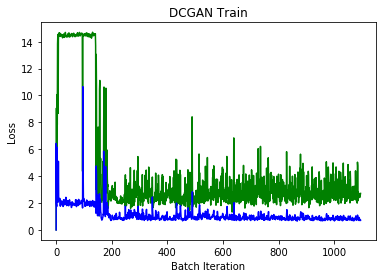

Epoch 138/190 :
     Batch 1/8 generator loss | discriminator loss : 2.50343 | 0.74982154 - batch took 6.585057973861694 s.
     Batch 2/8 generator loss | discriminator loss : 2.424106 | 0.6916189 - batch took 6.6668500900268555 s.
     Batch 3/8 generator loss | discriminator loss : 5.275499 | 0.980189 - batch took 6.4531028270721436 s.
     Batch 4/8 generator loss | discriminator loss : 2.9756608 | 1.0480266 - batch took 6.869008302688599 s.
     Batch 5/8 generator loss | discriminator loss : 3.1501915 | 0.83168113 - batch took 6.304976940155029 s.
     Batch 6/8 generator loss | discriminator loss : 2.4504004 | 0.7368796 - batch took 6.619132995605469 s.
     Batch 7/8 generator loss | discriminator loss : 3.7652438 | 0.91579914 - batch took 6.692457675933838 s.
     Batch 8/8 generator loss | discriminator loss : 2.4295757 | 0.8805986 - batch took 6.671368598937988 s.


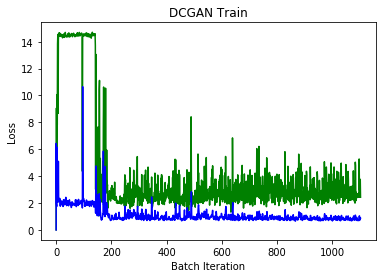

Epoch 139/190 :
     Batch 1/8 generator loss | discriminator loss : 4.1424675 | 0.985674 - batch took 6.879056692123413 s.
     Batch 2/8 generator loss | discriminator loss : 3.3023384 | 0.86987066 - batch took 6.497629642486572 s.
     Batch 3/8 generator loss | discriminator loss : 2.241117 | 0.8375249 - batch took 6.815392017364502 s.
     Batch 4/8 generator loss | discriminator loss : 2.7585745 | 0.80661255 - batch took 6.385076522827148 s.
     Batch 5/8 generator loss | discriminator loss : 2.788762 | 0.72342944 - batch took 6.342015504837036 s.
     Batch 6/8 generator loss | discriminator loss : 2.1098502 | 0.719551 - batch took 6.593845367431641 s.
     Batch 7/8 generator loss | discriminator loss : 4.2243366 | 0.8057692 - batch took 7.29542875289917 s.
     Batch 8/8 generator loss | discriminator loss : 2.789737 | 0.87369746 - batch took 7.764930248260498 s.


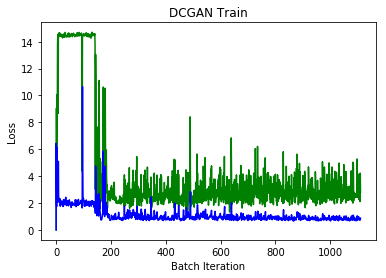

Epoch 140/190 :
     Batch 1/8 generator loss | discriminator loss : 3.0464776 | 0.7539263 - batch took 7.0455567836761475 s.
     Batch 2/8 generator loss | discriminator loss : 2.7220986 | 0.7109081 - batch took 7.029323577880859 s.
     Batch 3/8 generator loss | discriminator loss : 2.4424243 | 0.7127461 - batch took 6.6898884773254395 s.
     Batch 4/8 generator loss | discriminator loss : 3.994304 | 0.759989 - batch took 6.793072462081909 s.
     Batch 5/8 generator loss | discriminator loss : 2.401516 | 0.8878697 - batch took 6.675511837005615 s.
     Batch 6/8 generator loss | discriminator loss : 3.0611765 | 0.8061943 - batch took 6.466693162918091 s.
     Batch 7/8 generator loss | discriminator loss : 2.225889 | 0.8100859 - batch took 6.757379770278931 s.
     Batch 8/8 generator loss | discriminator loss : 5.5795097 | 1.0239246 - batch took 6.501616716384888 s.


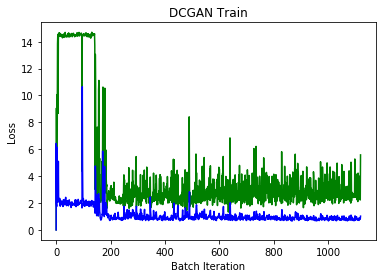

Epoch 141/190 :
     Batch 1/8 generator loss | discriminator loss : 4.1455865 | 1.3533168 - batch took 6.966001749038696 s.
     Batch 2/8 generator loss | discriminator loss : 2.4941037 | 0.79250145 - batch took 6.543220520019531 s.
     Batch 3/8 generator loss | discriminator loss : 3.0225115 | 0.7755054 - batch took 6.8547492027282715 s.
     Batch 4/8 generator loss | discriminator loss : 2.5308046 | 0.8184737 - batch took 6.647523641586304 s.
     Batch 5/8 generator loss | discriminator loss : 3.417957 | 0.86550194 - batch took 6.542892932891846 s.
     Batch 6/8 generator loss | discriminator loss : 2.384247 | 0.8124643 - batch took 6.747332334518433 s.
     Batch 7/8 generator loss | discriminator loss : 2.031065 | 0.7746215 - batch took 6.4656195640563965 s.
     Batch 8/8 generator loss | discriminator loss : 2.5355222 | 0.757287 - batch took 6.607927083969116 s.


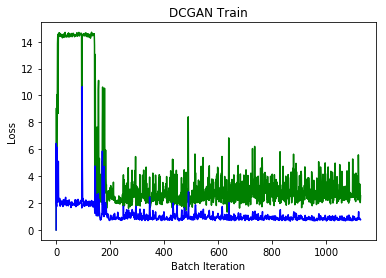

Epoch 142/190 :
     Batch 1/8 generator loss | discriminator loss : 2.5518343 | 0.7200024 - batch took 6.864409446716309 s.
     Batch 2/8 generator loss | discriminator loss : 3.1973057 | 0.6482239 - batch took 6.8394293785095215 s.
     Batch 3/8 generator loss | discriminator loss : 2.9917097 | 0.81815904 - batch took 6.810871839523315 s.
     Batch 4/8 generator loss | discriminator loss : 2.132738 | 0.72906744 - batch took 6.346486330032349 s.
     Batch 5/8 generator loss | discriminator loss : 5.542929 | 0.8869597 - batch took 6.787420034408569 s.
     Batch 6/8 generator loss | discriminator loss : 4.5685735 | 1.0706246 - batch took 6.66966986656189 s.
     Batch 7/8 generator loss | discriminator loss : 2.4911993 | 0.82262224 - batch took 6.516222953796387 s.
     Batch 8/8 generator loss | discriminator loss : 2.7175238 | 0.6978623 - batch took 6.7145280838012695 s.


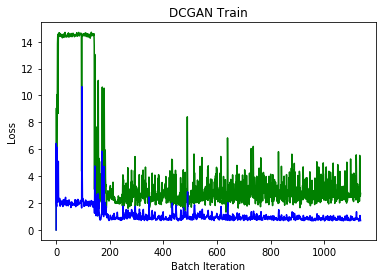

Epoch 143/190 :
     Batch 1/8 generator loss | discriminator loss : 2.1765342 | 0.7130021 - batch took 6.405961751937866 s.
     Batch 2/8 generator loss | discriminator loss : 3.0836585 | 0.82328004 - batch took 7.139353275299072 s.
     Batch 3/8 generator loss | discriminator loss : 2.3208518 | 0.71153206 - batch took 6.562809228897095 s.
     Batch 4/8 generator loss | discriminator loss : 3.7837152 | 0.87705755 - batch took 6.613839626312256 s.
     Batch 5/8 generator loss | discriminator loss : 2.3745582 | 0.87062347 - batch took 6.759915113449097 s.
     Batch 6/8 generator loss | discriminator loss : 4.444491 | 0.9217266 - batch took 6.545743703842163 s.
     Batch 7/8 generator loss | discriminator loss : 3.3871458 | 0.9382416 - batch took 6.860466718673706 s.
     Batch 8/8 generator loss | discriminator loss : 2.876745 | 0.83788687 - batch took 6.519454002380371 s.


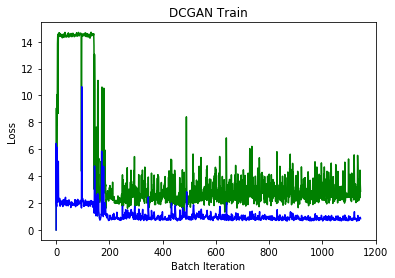

Epoch 144/190 :
     Batch 1/8 generator loss | discriminator loss : 2.4656987 | 0.69301605 - batch took 6.87186074256897 s.
     Batch 2/8 generator loss | discriminator loss : 3.2467241 | 0.79289436 - batch took 6.449697017669678 s.
     Batch 3/8 generator loss | discriminator loss : 2.581541 | 0.7633088 - batch took 7.088984727859497 s.
     Batch 4/8 generator loss | discriminator loss : 2.445216 | 0.81997806 - batch took 6.6289167404174805 s.
     Batch 5/8 generator loss | discriminator loss : 2.6924677 | 0.6652217 - batch took 6.500082969665527 s.
     Batch 6/8 generator loss | discriminator loss : 2.1124656 | 0.73919153 - batch took 6.626588582992554 s.
     Batch 7/8 generator loss | discriminator loss : 4.211153 | 0.8773894 - batch took 6.4313390254974365 s.
     Batch 8/8 generator loss | discriminator loss : 2.8967059 | 0.9375564 - batch took 6.93847131729126 s.


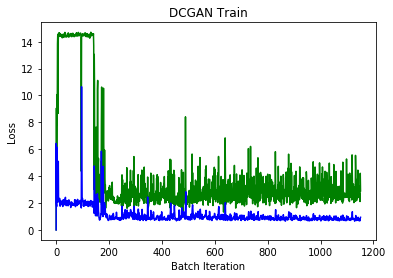

Epoch 145/190 :
     Batch 1/8 generator loss | discriminator loss : 2.762457 | 0.7809788 - batch took 6.446373224258423 s.
     Batch 2/8 generator loss | discriminator loss : 2.016871 | 0.7112769 - batch took 6.48124361038208 s.
     Batch 3/8 generator loss | discriminator loss : 4.0131345 | 0.917385 - batch took 6.609353303909302 s.
     Batch 4/8 generator loss | discriminator loss : 2.740157 | 0.97362494 - batch took 6.676671504974365 s.
     Batch 5/8 generator loss | discriminator loss : 3.602195 | 0.84057295 - batch took 7.047402620315552 s.
     Batch 6/8 generator loss | discriminator loss : 2.582089 | 0.8020669 - batch took 6.5248260498046875 s.
     Batch 7/8 generator loss | discriminator loss : 5.5894184 | 1.2408355 - batch took 6.434054136276245 s.
     Batch 8/8 generator loss | discriminator loss : 5.0966296 | 1.1610184 - batch took 6.562837839126587 s.


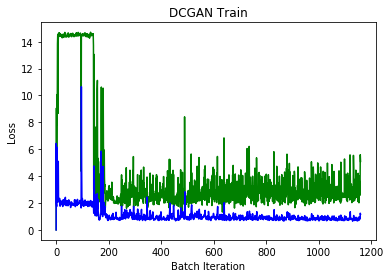

Epoch 146/190 :
     Batch 1/8 generator loss | discriminator loss : 2.6241992 | 0.8260315 - batch took 6.796623468399048 s.
     Batch 2/8 generator loss | discriminator loss : 3.0255365 | 0.7727003 - batch took 6.593834400177002 s.
     Batch 3/8 generator loss | discriminator loss : 2.0827477 | 0.8629495 - batch took 6.987868785858154 s.
     Batch 4/8 generator loss | discriminator loss : 3.3473585 | 0.8154329 - batch took 6.906309604644775 s.
     Batch 5/8 generator loss | discriminator loss : 2.683532 | 0.8628328 - batch took 7.135122060775757 s.
     Batch 6/8 generator loss | discriminator loss : 2.009459 | 0.7943268 - batch took 6.725409030914307 s.
     Batch 7/8 generator loss | discriminator loss : 2.3965888 | 0.68607306 - batch took 6.75982141494751 s.
     Batch 8/8 generator loss | discriminator loss : 2.6490338 | 0.74462235 - batch took 6.482224941253662 s.


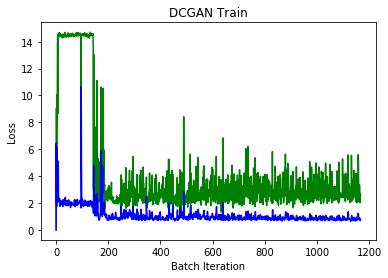

Epoch 147/190 :
     Batch 1/8 generator loss | discriminator loss : 2.442242 | 0.7003723 - batch took 6.7379350662231445 s.
     Batch 2/8 generator loss | discriminator loss : 2.7601318 | 0.7584297 - batch took 6.4213831424713135 s.
     Batch 3/8 generator loss | discriminator loss : 2.1221178 | 0.7251321 - batch took 6.655572891235352 s.
     Batch 4/8 generator loss | discriminator loss : 2.9069266 | 0.7946283 - batch took 6.85345721244812 s.
     Batch 5/8 generator loss | discriminator loss : 2.3496776 | 0.7629454 - batch took 6.456354141235352 s.
     Batch 6/8 generator loss | discriminator loss : 4.9422956 | 0.9751571 - batch took 6.8278186321258545 s.
     Batch 7/8 generator loss | discriminator loss : 3.5403507 | 1.1727791 - batch took 6.560101747512817 s.
     Batch 8/8 generator loss | discriminator loss : 2.4797535 | 0.73251235 - batch took 6.8408238887786865 s.


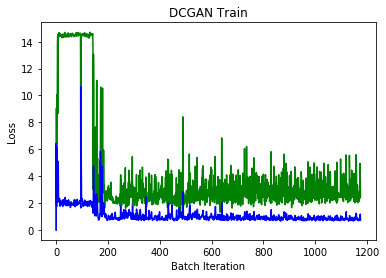

Epoch 148/190 :
     Batch 1/8 generator loss | discriminator loss : 2.4948661 | 0.715681 - batch took 6.354648590087891 s.
     Batch 2/8 generator loss | discriminator loss : 2.2713907 | 0.7250467 - batch took 6.341223478317261 s.
     Batch 3/8 generator loss | discriminator loss : 2.0468206 | 0.7237715 - batch took 6.781406879425049 s.
     Batch 4/8 generator loss | discriminator loss : 2.5517092 | 0.79053366 - batch took 6.4691972732543945 s.
     Batch 5/8 generator loss | discriminator loss : 2.2867565 | 0.73214746 - batch took 6.972179174423218 s.
     Batch 6/8 generator loss | discriminator loss : 2.408505 | 0.8131107 - batch took 6.733473300933838 s.
     Batch 7/8 generator loss | discriminator loss : 2.3620524 | 0.7071743 - batch took 7.036064624786377 s.
     Batch 8/8 generator loss | discriminator loss : 2.6701276 | 0.8468442 - batch took 6.699126958847046 s.


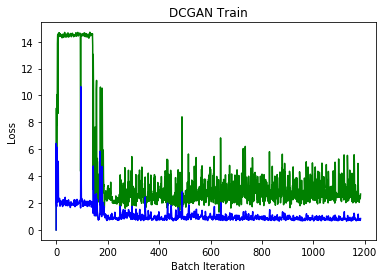

Epoch 149/190 :
     Batch 1/8 generator loss | discriminator loss : 2.280604 | 0.71296346 - batch took 6.404663324356079 s.
     Batch 2/8 generator loss | discriminator loss : 3.1195147 | 0.77886516 - batch took 6.7577643394470215 s.
     Batch 3/8 generator loss | discriminator loss : 2.2930214 | 0.71453315 - batch took 6.4525837898254395 s.
     Batch 4/8 generator loss | discriminator loss : 4.4458766 | 0.84600407 - batch took 6.835660457611084 s.
     Batch 5/8 generator loss | discriminator loss : 2.7495856 | 0.9508753 - batch took 6.487736225128174 s.
     Batch 6/8 generator loss | discriminator loss : 4.301574 | 0.9786161 - batch took 6.5946385860443115 s.
     Batch 7/8 generator loss | discriminator loss : 3.633924 | 0.8172834 - batch took 6.759826183319092 s.
     Batch 8/8 generator loss | discriminator loss : 2.2643156 | 0.79012847 - batch took 6.723782300949097 s.


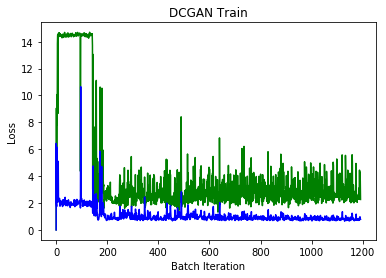

Epoch 150/190 :
     Batch 1/8 generator loss | discriminator loss : 2.745263 | 0.6459669 - batch took 6.693758487701416 s.
     Batch 2/8 generator loss | discriminator loss : 1.9688883 | 0.70928526 - batch took 6.5750792026519775 s.
     Batch 3/8 generator loss | discriminator loss : 3.6235046 | 0.91152614 - batch took 6.7702131271362305 s.
     Batch 4/8 generator loss | discriminator loss : 2.7908869 | 0.82982576 - batch took 6.482375383377075 s.
     Batch 5/8 generator loss | discriminator loss : 3.459327 | 0.8094836 - batch took 6.824815273284912 s.
     Batch 6/8 generator loss | discriminator loss : 2.114821 | 0.73810744 - batch took 6.594521999359131 s.
     Batch 7/8 generator loss | discriminator loss : 4.1329355 | 0.92641425 - batch took 6.484758615493774 s.
     Batch 8/8 generator loss | discriminator loss : 3.2087786 | 0.941319 - batch took 6.71246075630188 s.


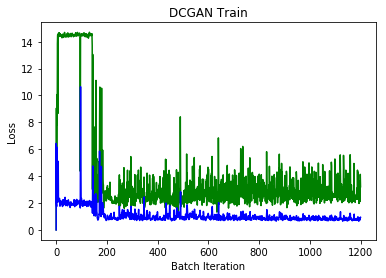

Epoch 151/190 :
     Batch 1/8 generator loss | discriminator loss : 2.6870599 | 0.8183892 - batch took 7.020396947860718 s.
     Batch 2/8 generator loss | discriminator loss : 2.3676908 | 0.68545234 - batch took 6.720654010772705 s.
     Batch 3/8 generator loss | discriminator loss : 2.9739234 | 0.77710474 - batch took 6.555248260498047 s.
     Batch 4/8 generator loss | discriminator loss : 2.5491996 | 0.72018373 - batch took 6.488366603851318 s.
     Batch 5/8 generator loss | discriminator loss : 3.663394 | 0.9096724 - batch took 6.938446521759033 s.
     Batch 6/8 generator loss | discriminator loss : 2.7238636 | 0.8617581 - batch took 6.453845262527466 s.
     Batch 7/8 generator loss | discriminator loss : 2.9025116 | 0.7906673 - batch took 7.344372987747192 s.
     Batch 8/8 generator loss | discriminator loss : 2.409647 | 0.72282624 - batch took 6.921627044677734 s.


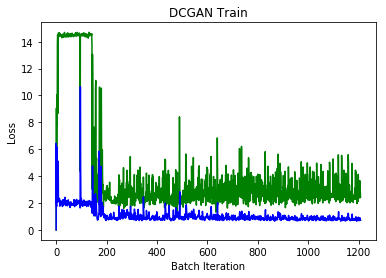

Epoch 152/190 :
     Batch 1/8 generator loss | discriminator loss : 3.3401415 | 0.8664057 - batch took 6.743442058563232 s.
     Batch 2/8 generator loss | discriminator loss : 2.5759735 | 0.80172133 - batch took 6.718270540237427 s.
     Batch 3/8 generator loss | discriminator loss : 3.979026 | 0.88476694 - batch took 6.907339096069336 s.
     Batch 4/8 generator loss | discriminator loss : 2.7284477 | 0.9884478 - batch took 6.999497413635254 s.
     Batch 5/8 generator loss | discriminator loss : 2.8311415 | 0.8142599 - batch took 6.563856601715088 s.
     Batch 6/8 generator loss | discriminator loss : 2.5683637 | 0.72373927 - batch took 6.858719348907471 s.
     Batch 7/8 generator loss | discriminator loss : 3.3511584 | 0.93641734 - batch took 7.614036321640015 s.
     Batch 8/8 generator loss | discriminator loss : 2.5874991 | 0.7782049 - batch took 7.8763086795806885 s.


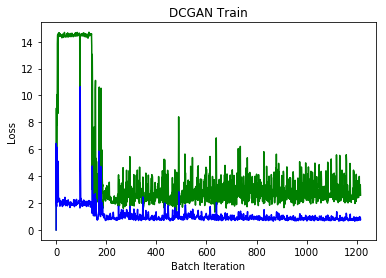

Epoch 153/190 :
     Batch 1/8 generator loss | discriminator loss : 2.3745744 | 0.7280016 - batch took 7.869197130203247 s.
     Batch 2/8 generator loss | discriminator loss : 2.4156523 | 0.6853834 - batch took 8.021446228027344 s.
     Batch 3/8 generator loss | discriminator loss : 3.940891 | 0.9868045 - batch took 7.380223751068115 s.
     Batch 4/8 generator loss | discriminator loss : 3.445116 | 0.85273826 - batch took 6.533976793289185 s.
     Batch 5/8 generator loss | discriminator loss : 2.8352685 | 0.76566046 - batch took 6.599431037902832 s.
     Batch 6/8 generator loss | discriminator loss : 2.2797222 | 0.727683 - batch took 6.569666385650635 s.
     Batch 7/8 generator loss | discriminator loss : 2.7338386 | 0.76459396 - batch took 6.730413913726807 s.
     Batch 8/8 generator loss | discriminator loss : 2.1668682 | 0.71484876 - batch took 6.500967502593994 s.


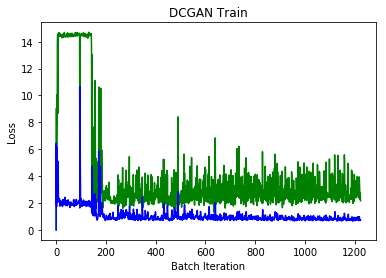

Epoch 154/190 :
     Batch 1/8 generator loss | discriminator loss : 3.0128553 | 0.72455835 - batch took 7.677928924560547 s.
     Batch 2/8 generator loss | discriminator loss : 1.9843827 | 0.72570896 - batch took 7.108024835586548 s.
     Batch 3/8 generator loss | discriminator loss : 4.788383 | 0.88353705 - batch took 6.750772476196289 s.
     Batch 4/8 generator loss | discriminator loss : 3.5523472 | 1.0002513 - batch took 6.640971660614014 s.
     Batch 5/8 generator loss | discriminator loss : 2.539757 | 0.71327823 - batch took 6.925109386444092 s.
     Batch 6/8 generator loss | discriminator loss : 2.711377 | 0.6964222 - batch took 6.777846574783325 s.
     Batch 7/8 generator loss | discriminator loss : 2.2556925 | 0.72954404 - batch took 6.621455907821655 s.
     Batch 8/8 generator loss | discriminator loss : 2.613743 | 0.72811794 - batch took 6.8889710903167725 s.


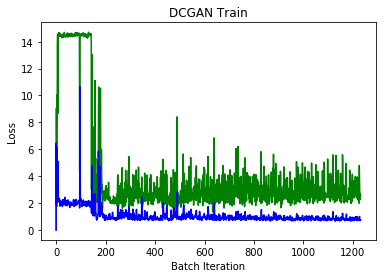

Epoch 155/190 :
     Batch 1/8 generator loss | discriminator loss : 2.1382344 | 0.69850117 - batch took 6.5412774085998535 s.
     Batch 2/8 generator loss | discriminator loss : 5.59677 | 0.9729497 - batch took 6.504327297210693 s.
     Batch 3/8 generator loss | discriminator loss : 3.7341595 | 1.3102555 - batch took 6.6410205364227295 s.
     Batch 4/8 generator loss | discriminator loss : 3.018114 | 0.81320834 - batch took 6.983785152435303 s.
     Batch 5/8 generator loss | discriminator loss : 2.6276557 | 0.7054643 - batch took 7.078686475753784 s.
     Batch 6/8 generator loss | discriminator loss : 2.3024204 | 0.7742926 - batch took 6.520502805709839 s.
     Batch 7/8 generator loss | discriminator loss : 2.1860943 | 0.7321757 - batch took 6.86688756942749 s.
     Batch 8/8 generator loss | discriminator loss : 2.9280853 | 0.67776084 - batch took 6.500314474105835 s.


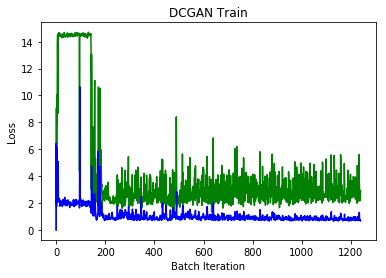

Epoch 156/190 :
     Batch 1/8 generator loss | discriminator loss : 2.205829 | 0.74350893 - batch took 6.601261854171753 s.
     Batch 2/8 generator loss | discriminator loss : 4.699341 | 0.8409027 - batch took 6.799978494644165 s.
     Batch 3/8 generator loss | discriminator loss : 3.420312 | 1.0197662 - batch took 6.4139533042907715 s.
     Batch 4/8 generator loss | discriminator loss : 2.0175328 | 0.78169346 - batch took 6.64494514465332 s.
     Batch 5/8 generator loss | discriminator loss : 2.056703 | 0.69938505 - batch took 7.059014320373535 s.
     Batch 6/8 generator loss | discriminator loss : 2.8221798 | 0.78567624 - batch took 6.8704469203948975 s.
     Batch 7/8 generator loss | discriminator loss : 2.206093 | 0.75584793 - batch took 6.576717138290405 s.
     Batch 8/8 generator loss | discriminator loss : 3.0781446 | 0.805655 - batch took 6.593542575836182 s.


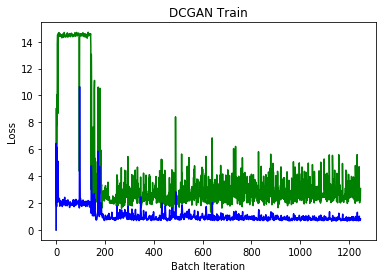

Epoch 157/190 :
     Batch 1/8 generator loss | discriminator loss : 3.0534527 | 0.81318486 - batch took 6.776569843292236 s.
     Batch 2/8 generator loss | discriminator loss : 3.696746 | 0.8309665 - batch took 6.510737180709839 s.
     Batch 3/8 generator loss | discriminator loss : 2.3675988 | 0.80750024 - batch took 6.752577543258667 s.
     Batch 4/8 generator loss | discriminator loss : 5.0155916 | 0.88463396 - batch took 6.6545984745025635 s.
     Batch 5/8 generator loss | discriminator loss : 3.5089812 | 1.0591213 - batch took 6.69867467880249 s.
     Batch 6/8 generator loss | discriminator loss : 2.6043768 | 0.8202878 - batch took 6.6493446826934814 s.
     Batch 7/8 generator loss | discriminator loss : 2.6157193 | 0.70569444 - batch took 6.567614555358887 s.
     Batch 8/8 generator loss | discriminator loss : 2.1336765 | 0.7713532 - batch took 6.934736251831055 s.


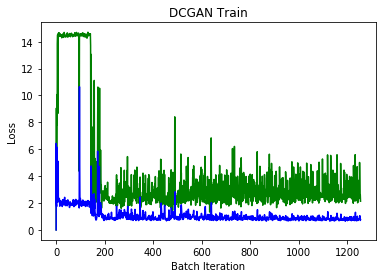

Epoch 158/190 :
     Batch 1/8 generator loss | discriminator loss : 3.1149693 | 0.7699018 - batch took 6.34699010848999 s.
     Batch 2/8 generator loss | discriminator loss : 2.2475274 | 0.8597338 - batch took 6.609577894210815 s.
     Batch 3/8 generator loss | discriminator loss : 4.84091 | 0.8240559 - batch took 6.8199779987335205 s.
     Batch 4/8 generator loss | discriminator loss : 3.387227 | 0.9815167 - batch took 6.465533971786499 s.
     Batch 5/8 generator loss | discriminator loss : 3.3291426 | 0.8100505 - batch took 6.8903398513793945 s.
     Batch 6/8 generator loss | discriminator loss : 2.486011 | 0.70177037 - batch took 6.669934272766113 s.
     Batch 7/8 generator loss | discriminator loss : 2.828056 | 0.79967546 - batch took 6.9889538288116455 s.
     Batch 8/8 generator loss | discriminator loss : 2.3223438 | 0.81026155 - batch took 6.571911811828613 s.


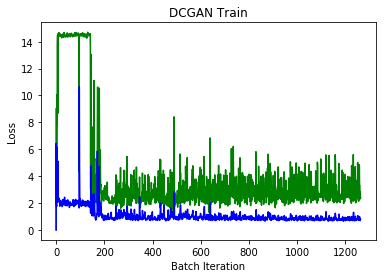

Epoch 159/190 :
     Batch 1/8 generator loss | discriminator loss : 2.67687 | 0.77767 - batch took 6.728419065475464 s.
     Batch 2/8 generator loss | discriminator loss : 2.2592344 | 0.7582574 - batch took 6.74807333946228 s.
     Batch 3/8 generator loss | discriminator loss : 2.7912314 | 0.74992836 - batch took 6.586825132369995 s.
     Batch 4/8 generator loss | discriminator loss : 2.0807211 | 0.751446 - batch took 6.803810119628906 s.
     Batch 5/8 generator loss | discriminator loss : 3.5568707 | 0.8193147 - batch took 6.591241836547852 s.
     Batch 6/8 generator loss | discriminator loss : 2.6049936 | 0.7897172 - batch took 6.84391975402832 s.
     Batch 7/8 generator loss | discriminator loss : 2.1507955 | 0.7983555 - batch took 7.3808417320251465 s.
     Batch 8/8 generator loss | discriminator loss : 2.1311266 | 0.74398017 - batch took 6.588643312454224 s.


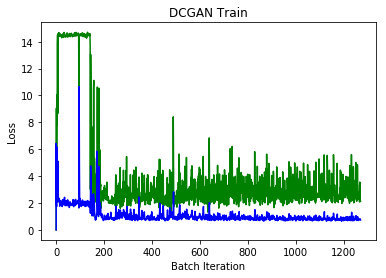

Epoch 160/190 :
     Batch 1/8 generator loss | discriminator loss : 3.716859 | 0.79578364 - batch took 6.576681137084961 s.
     Batch 2/8 generator loss | discriminator loss : 1.8419741 | 0.84639597 - batch took 6.944492340087891 s.
     Batch 3/8 generator loss | discriminator loss : 5.896334 | 1.0606587 - batch took 6.522792816162109 s.
     Batch 4/8 generator loss | discriminator loss : 3.9251697 | 1.2343624 - batch took 6.371940851211548 s.
     Batch 5/8 generator loss | discriminator loss : 2.7506058 | 0.8127682 - batch took 6.843491554260254 s.
     Batch 6/8 generator loss | discriminator loss : 2.8182955 | 0.71576524 - batch took 6.534450054168701 s.
     Batch 7/8 generator loss | discriminator loss : 2.3003159 | 0.7381566 - batch took 6.66620135307312 s.
     Batch 8/8 generator loss | discriminator loss : 2.4202812 | 0.7043731 - batch took 6.9250102043151855 s.


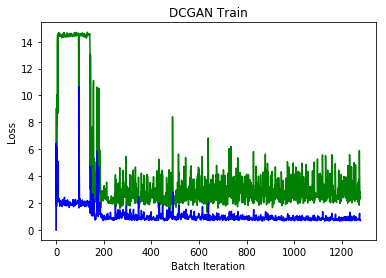

Epoch 161/190 :
     Batch 1/8 generator loss | discriminator loss : 2.72057 | 0.7016269 - batch took 6.5954203605651855 s.
     Batch 2/8 generator loss | discriminator loss : 1.9827844 | 0.76700306 - batch took 6.7984278202056885 s.
     Batch 3/8 generator loss | discriminator loss : 3.0909333 | 0.80841434 - batch took 6.4617884159088135 s.
     Batch 4/8 generator loss | discriminator loss : 2.4799728 | 0.7240974 - batch took 6.5900490283966064 s.
     Batch 5/8 generator loss | discriminator loss : 3.5246563 | 0.88331115 - batch took 7.333012819290161 s.
     Batch 6/8 generator loss | discriminator loss : 2.6401794 | 0.8249681 - batch took 7.533910512924194 s.
     Batch 7/8 generator loss | discriminator loss : 3.4678414 | 0.9088472 - batch took 6.610383749008179 s.
     Batch 8/8 generator loss | discriminator loss : 3.422697 | 0.84118384 - batch took 6.495073080062866 s.


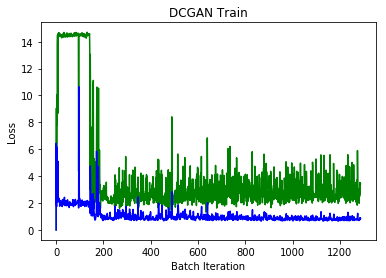

Epoch 162/190 :
     Batch 1/8 generator loss | discriminator loss : 2.514664 | 0.70419514 - batch took 6.871123790740967 s.
     Batch 2/8 generator loss | discriminator loss : 2.254943 | 0.7376163 - batch took 6.60194993019104 s.
     Batch 3/8 generator loss | discriminator loss : 3.313688 | 0.8204193 - batch took 6.711974382400513 s.
     Batch 4/8 generator loss | discriminator loss : 2.6592443 | 0.82854354 - batch took 6.628457307815552 s.
     Batch 5/8 generator loss | discriminator loss : 2.5513198 | 0.726356 - batch took 6.459629535675049 s.
     Batch 6/8 generator loss | discriminator loss : 2.1846497 | 0.7301157 - batch took 6.922253608703613 s.
     Batch 7/8 generator loss | discriminator loss : 2.8188627 | 0.8037561 - batch took 6.68326473236084 s.
     Batch 8/8 generator loss | discriminator loss : 2.3796816 | 0.6885874 - batch took 7.055570602416992 s.


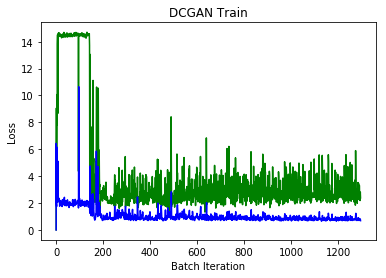

Epoch 163/190 :
     Batch 1/8 generator loss | discriminator loss : 3.2935803 | 0.78388447 - batch took 6.672256946563721 s.
     Batch 2/8 generator loss | discriminator loss : 2.3323348 | 0.79344344 - batch took 6.516103982925415 s.
     Batch 3/8 generator loss | discriminator loss : 3.3363047 | 0.84487545 - batch took 6.82817268371582 s.
     Batch 4/8 generator loss | discriminator loss : 2.4817157 | 0.84911656 - batch took 6.776809930801392 s.
     Batch 5/8 generator loss | discriminator loss : 2.6403887 | 0.79724985 - batch took 6.640354633331299 s.
     Batch 6/8 generator loss | discriminator loss : 2.1820028 | 0.7069031 - batch took 6.540504217147827 s.
     Batch 7/8 generator loss | discriminator loss : 3.1062865 | 0.7187841 - batch took 7.1187708377838135 s.
     Batch 8/8 generator loss | discriminator loss : 2.2110772 | 0.76545215 - batch took 6.8894312381744385 s.


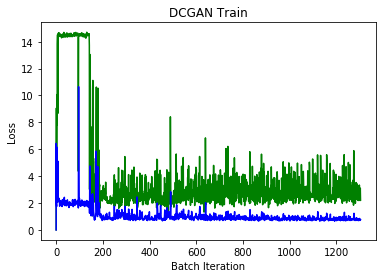

Epoch 164/190 :
     Batch 1/8 generator loss | discriminator loss : 3.7728791 | 0.87127495 - batch took 6.796274662017822 s.
     Batch 2/8 generator loss | discriminator loss : 2.468334 | 0.8775011 - batch took 7.187060594558716 s.
     Batch 3/8 generator loss | discriminator loss : 2.682459 | 0.803306 - batch took 7.152935266494751 s.
     Batch 4/8 generator loss | discriminator loss : 2.1855035 | 0.70399904 - batch took 9.085811376571655 s.
     Batch 5/8 generator loss | discriminator loss : 2.977478 | 0.7874326 - batch took 7.6734044551849365 s.
     Batch 6/8 generator loss | discriminator loss : 2.2457392 | 0.7911326 - batch took 7.610392808914185 s.
     Batch 7/8 generator loss | discriminator loss : 3.664582 | 0.82252955 - batch took 6.299826145172119 s.
     Batch 8/8 generator loss | discriminator loss : 2.1111557 | 0.88030714 - batch took 7.074495553970337 s.


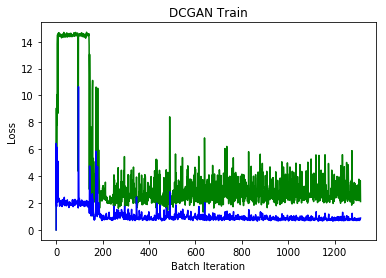

Epoch 165/190 :
     Batch 1/8 generator loss | discriminator loss : 4.3942947 | 0.8740498 - batch took 6.512710332870483 s.
     Batch 2/8 generator loss | discriminator loss : 3.7945576 | 0.8899432 - batch took 7.137488603591919 s.
     Batch 3/8 generator loss | discriminator loss : 2.7110412 | 0.6939293 - batch took 6.50247049331665 s.
     Batch 4/8 generator loss | discriminator loss : 3.0056195 | 0.6764633 - batch took 6.651085615158081 s.
     Batch 5/8 generator loss | discriminator loss : 2.2361453 | 0.753422 - batch took 7.00048041343689 s.
     Batch 6/8 generator loss | discriminator loss : 4.422535 | 0.8861569 - batch took 6.390858888626099 s.
     Batch 7/8 generator loss | discriminator loss : 3.7069526 | 0.9177135 - batch took 6.797728776931763 s.
     Batch 8/8 generator loss | discriminator loss : 2.1703799 | 0.73982394 - batch took 6.787093639373779 s.


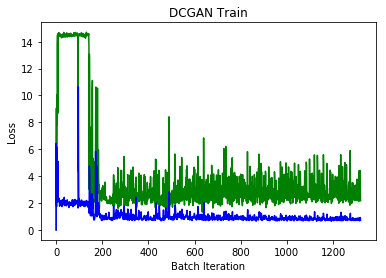

Epoch 166/190 :
     Batch 1/8 generator loss | discriminator loss : 2.857616 | 0.7335037 - batch took 6.937150001525879 s.
     Batch 2/8 generator loss | discriminator loss : 2.3810701 | 0.73835635 - batch took 6.752358675003052 s.
     Batch 3/8 generator loss | discriminator loss : 2.3243034 | 0.7945454 - batch took 6.931903600692749 s.
     Batch 4/8 generator loss | discriminator loss : 2.0942945 | 0.7308303 - batch took 6.885101318359375 s.
     Batch 5/8 generator loss | discriminator loss : 2.7069485 | 0.72908163 - batch took 6.639365196228027 s.
     Batch 6/8 generator loss | discriminator loss : 2.116581 | 0.69582415 - batch took 6.803758382797241 s.
     Batch 7/8 generator loss | discriminator loss : 4.382861 | 0.81632155 - batch took 6.306799650192261 s.
     Batch 8/8 generator loss | discriminator loss : 3.4228506 | 0.8379769 - batch took 6.563735246658325 s.


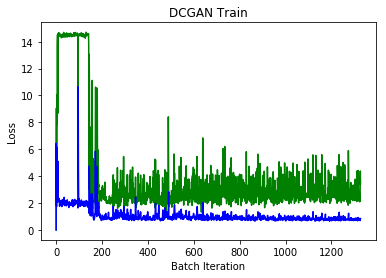

Epoch 167/190 :
     Batch 1/8 generator loss | discriminator loss : 2.2263741 | 0.733432 - batch took 6.598372220993042 s.
     Batch 2/8 generator loss | discriminator loss : 2.8491564 | 0.7355188 - batch took 6.5634925365448 s.
     Batch 3/8 generator loss | discriminator loss : 2.290778 | 0.68750167 - batch took 6.726454257965088 s.
     Batch 4/8 generator loss | discriminator loss : 2.7562623 | 0.74894047 - batch took 6.6365838050842285 s.
     Batch 5/8 generator loss | discriminator loss : 2.4347596 | 0.77072716 - batch took 6.829745054244995 s.
     Batch 6/8 generator loss | discriminator loss : 2.6936555 | 0.6596928 - batch took 6.474405288696289 s.
     Batch 7/8 generator loss | discriminator loss : 2.3193142 | 0.6935487 - batch took 6.6501781940460205 s.
     Batch 8/8 generator loss | discriminator loss : 4.5865655 | 0.849668 - batch took 6.909865140914917 s.


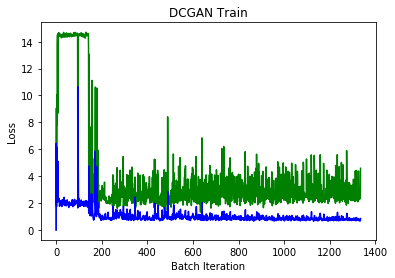

Epoch 168/190 :
     Batch 1/8 generator loss | discriminator loss : 3.7902944 | 0.94008905 - batch took 6.566943168640137 s.
     Batch 2/8 generator loss | discriminator loss : 2.0334878 | 0.7423365 - batch took 6.613606214523315 s.
     Batch 3/8 generator loss | discriminator loss : 2.6213837 | 0.74635875 - batch took 6.617321729660034 s.
     Batch 4/8 generator loss | discriminator loss : 2.611301 | 0.7629586 - batch took 6.665674448013306 s.
     Batch 5/8 generator loss | discriminator loss : 2.6784246 | 0.7353793 - batch took 6.843955039978027 s.
     Batch 6/8 generator loss | discriminator loss : 1.98027 | 0.71839374 - batch took 6.590131044387817 s.
     Batch 7/8 generator loss | discriminator loss : 3.3835092 | 0.7710624 - batch took 7.04629921913147 s.
     Batch 8/8 generator loss | discriminator loss : 2.190977 | 0.78057575 - batch took 6.573469638824463 s.


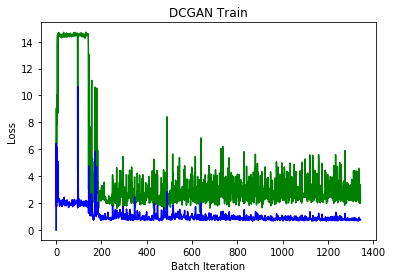

Epoch 169/190 :
     Batch 1/8 generator loss | discriminator loss : 4.363173 | 0.8844727 - batch took 6.808047771453857 s.
     Batch 2/8 generator loss | discriminator loss : 3.0434713 | 0.92148155 - batch took 6.46894907951355 s.
     Batch 3/8 generator loss | discriminator loss : 3.9861262 | 0.97300303 - batch took 6.604985475540161 s.
     Batch 4/8 generator loss | discriminator loss : 2.8531904 | 0.83879167 - batch took 6.563976526260376 s.
     Batch 5/8 generator loss | discriminator loss : 3.890733 | 0.8178802 - batch took 6.594706773757935 s.
     Batch 6/8 generator loss | discriminator loss : 2.4648483 | 0.8541245 - batch took 6.974765300750732 s.
     Batch 7/8 generator loss | discriminator loss : 3.226838 | 0.861457 - batch took 6.651506423950195 s.
     Batch 8/8 generator loss | discriminator loss : 3.110513 | 0.74834335 - batch took 6.851164102554321 s.


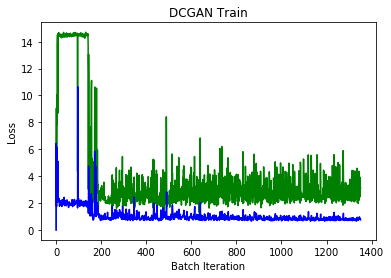

Epoch 170/190 :
     Batch 1/8 generator loss | discriminator loss : 2.9700336 | 0.7865088 - batch took 6.674426317214966 s.
     Batch 2/8 generator loss | discriminator loss : 2.4397118 | 0.69624436 - batch took 6.309538841247559 s.
     Batch 3/8 generator loss | discriminator loss : 5.6665387 | 0.9189013 - batch took 6.797094106674194 s.
     Batch 4/8 generator loss | discriminator loss : 4.43143 | 1.1196456 - batch took 6.656336545944214 s.
     Batch 5/8 generator loss | discriminator loss : 2.682237 | 0.7765384 - batch took 6.919471263885498 s.
     Batch 6/8 generator loss | discriminator loss : 2.4392078 | 0.7688515 - batch took 6.763827562332153 s.
     Batch 7/8 generator loss | discriminator loss : 1.9873526 | 0.83664405 - batch took 6.974186897277832 s.
     Batch 8/8 generator loss | discriminator loss : 2.9992406 | 0.8270105 - batch took 6.629350423812866 s.


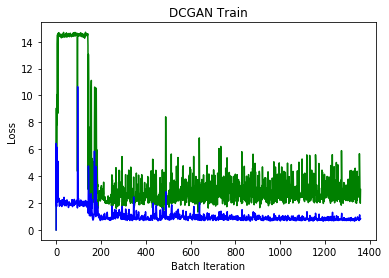

Epoch 171/190 :
     Batch 1/8 generator loss | discriminator loss : 2.6657636 | 0.68149924 - batch took 6.589709520339966 s.
     Batch 2/8 generator loss | discriminator loss : 2.666975 | 0.74564326 - batch took 6.863413095474243 s.
     Batch 3/8 generator loss | discriminator loss : 2.306649 | 0.7219503 - batch took 6.596300363540649 s.
     Batch 4/8 generator loss | discriminator loss : 2.664527 | 0.72829294 - batch took 6.775674104690552 s.
     Batch 5/8 generator loss | discriminator loss : 1.9540815 | 0.7346884 - batch took 6.751588344573975 s.
     Batch 6/8 generator loss | discriminator loss : 2.6730096 | 0.75868785 - batch took 6.671880722045898 s.
     Batch 7/8 generator loss | discriminator loss : 2.1231108 | 0.74248594 - batch took 6.898035049438477 s.
     Batch 8/8 generator loss | discriminator loss : 4.1599956 | 0.85048926 - batch took 6.5432446002960205 s.


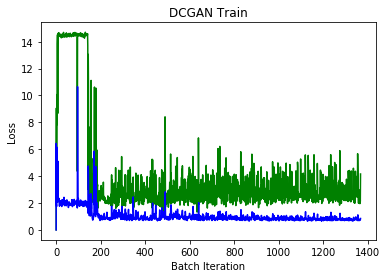

Epoch 172/190 :
     Batch 1/8 generator loss | discriminator loss : 3.5254426 | 0.84467983 - batch took 6.884798288345337 s.
     Batch 2/8 generator loss | discriminator loss : 2.1213553 | 0.7670413 - batch took 6.671151876449585 s.
     Batch 3/8 generator loss | discriminator loss : 2.703269 | 0.82496214 - batch took 6.969331502914429 s.
     Batch 4/8 generator loss | discriminator loss : 2.4026282 | 0.7340683 - batch took 6.481194972991943 s.
     Batch 5/8 generator loss | discriminator loss : 3.2045267 | 0.81516397 - batch took 6.451659440994263 s.
     Batch 6/8 generator loss | discriminator loss : 2.2441761 | 0.7752183 - batch took 6.697052240371704 s.
     Batch 7/8 generator loss | discriminator loss : 4.1805816 | 0.80851245 - batch took 6.529035568237305 s.
     Batch 8/8 generator loss | discriminator loss : 2.6565888 | 0.9166275 - batch took 7.058778524398804 s.


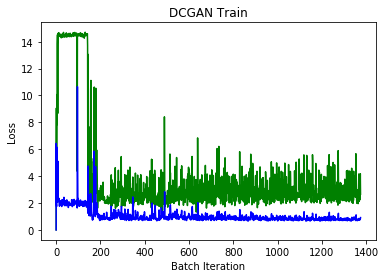

Epoch 173/190 :
     Batch 1/8 generator loss | discriminator loss : 2.72817 | 0.80609536 - batch took 7.775416612625122 s.
     Batch 2/8 generator loss | discriminator loss : 2.3396752 | 0.76194257 - batch took 7.661280155181885 s.
     Batch 3/8 generator loss | discriminator loss : 3.176363 | 0.84119725 - batch took 6.827993869781494 s.
     Batch 4/8 generator loss | discriminator loss : 2.3709354 | 0.75048965 - batch took 6.5755696296691895 s.
     Batch 5/8 generator loss | discriminator loss : 3.60276 | 0.8519646 - batch took 7.090629577636719 s.
     Batch 6/8 generator loss | discriminator loss : 2.7399054 | 0.8319104 - batch took 6.48472261428833 s.
     Batch 7/8 generator loss | discriminator loss : 2.8425753 | 0.7250756 - batch took 6.751652002334595 s.
     Batch 8/8 generator loss | discriminator loss : 2.296827 | 0.7319828 - batch took 6.338720321655273 s.


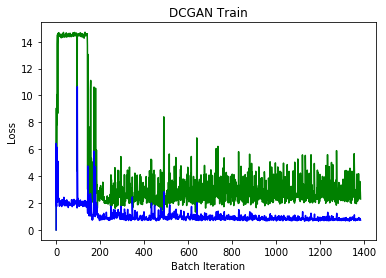

Epoch 174/190 :
     Batch 1/8 generator loss | discriminator loss : 2.8902807 | 0.7997576 - batch took 6.99027419090271 s.
     Batch 2/8 generator loss | discriminator loss : 2.4602866 | 0.7178978 - batch took 6.578915357589722 s.
     Batch 3/8 generator loss | discriminator loss : 4.2416716 | 0.9006733 - batch took 6.828356742858887 s.
     Batch 4/8 generator loss | discriminator loss : 3.524588 | 0.8997396 - batch took 6.729104995727539 s.
     Batch 5/8 generator loss | discriminator loss : 2.7431376 | 0.7489338 - batch took 6.3197267055511475 s.
     Batch 6/8 generator loss | discriminator loss : 2.5294158 | 0.6853962 - batch took 6.739262819290161 s.
     Batch 7/8 generator loss | discriminator loss : 2.546365 | 0.75849557 - batch took 6.6095640659332275 s.
     Batch 8/8 generator loss | discriminator loss : 2.2750297 | 0.7265538 - batch took 6.916347980499268 s.


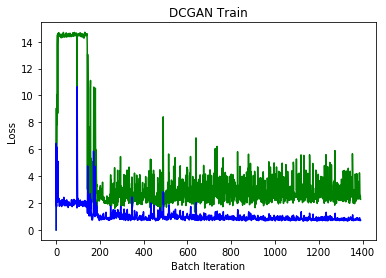

Epoch 175/190 :
     Batch 1/8 generator loss | discriminator loss : 3.5687606 | 0.8026695 - batch took 6.508882761001587 s.
     Batch 2/8 generator loss | discriminator loss : 2.7152982 | 0.8082279 - batch took 6.673381567001343 s.
     Batch 3/8 generator loss | discriminator loss : 3.1764915 | 0.7907157 - batch took 6.905613660812378 s.
     Batch 4/8 generator loss | discriminator loss : 2.4725258 | 0.74741125 - batch took 6.580019950866699 s.
     Batch 5/8 generator loss | discriminator loss : 2.9007244 | 0.75435936 - batch took 7.109041929244995 s.
     Batch 6/8 generator loss | discriminator loss : 2.4432516 | 0.72696716 - batch took 6.559235334396362 s.
     Batch 7/8 generator loss | discriminator loss : 2.57297 | 0.7236825 - batch took 6.553316593170166 s.
     Batch 8/8 generator loss | discriminator loss : 2.8445392 | 0.73410046 - batch took 6.93137526512146 s.


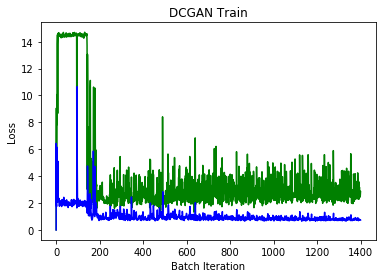

Epoch 176/190 :
     Batch 1/8 generator loss | discriminator loss : 2.361232 | 0.61659527 - batch took 6.682750940322876 s.
     Batch 2/8 generator loss | discriminator loss : 3.0059004 | 0.7054964 - batch took 6.705355644226074 s.
     Batch 3/8 generator loss | discriminator loss : 2.2177405 | 0.70243216 - batch took 6.738781452178955 s.
     Batch 4/8 generator loss | discriminator loss : 3.3792517 | 0.749416 - batch took 7.0532753467559814 s.
     Batch 5/8 generator loss | discriminator loss : 1.9150249 | 0.7911925 - batch took 6.853254079818726 s.
     Batch 6/8 generator loss | discriminator loss : 6.423115 | 1.0742196 - batch took 6.919426679611206 s.
     Batch 7/8 generator loss | discriminator loss : 4.38359 | 1.3505495 - batch took 7.26043438911438 s.
     Batch 8/8 generator loss | discriminator loss : 2.153448 | 0.7063427 - batch took 6.778211355209351 s.


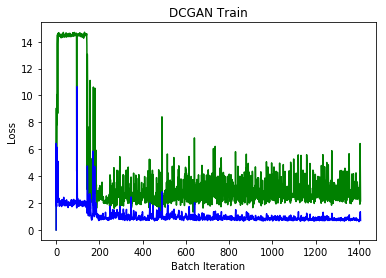

Epoch 177/190 :
     Batch 1/8 generator loss | discriminator loss : 2.5269856 | 0.75525665 - batch took 6.874722480773926 s.
     Batch 2/8 generator loss | discriminator loss : 2.4037745 | 0.83962774 - batch took 6.532827377319336 s.
     Batch 3/8 generator loss | discriminator loss : 2.1011345 | 0.72920465 - batch took 6.906579971313477 s.
     Batch 4/8 generator loss | discriminator loss : 2.8741412 | 0.8170494 - batch took 6.873564720153809 s.
     Batch 5/8 generator loss | discriminator loss : 2.5475984 | 0.708288 - batch took 6.515069007873535 s.
     Batch 6/8 generator loss | discriminator loss : 3.2067966 | 0.8602347 - batch took 6.796358108520508 s.
     Batch 7/8 generator loss | discriminator loss : 2.096276 | 0.8059761 - batch took 6.542922735214233 s.
     Batch 8/8 generator loss | discriminator loss : 3.4129891 | 0.8285403 - batch took 6.894076108932495 s.


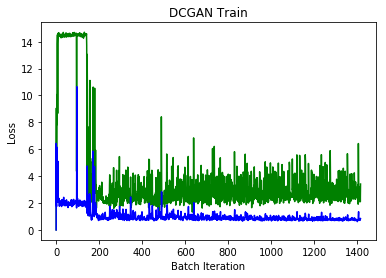

Epoch 178/190 :
     Batch 1/8 generator loss | discriminator loss : 2.2788103 | 0.819365 - batch took 7.2651896476745605 s.
     Batch 2/8 generator loss | discriminator loss : 2.9445057 | 0.79997474 - batch took 7.016061067581177 s.
     Batch 3/8 generator loss | discriminator loss : 2.3506913 | 0.69664943 - batch took 6.680285215377808 s.
     Batch 4/8 generator loss | discriminator loss : 3.6090043 | 0.81847036 - batch took 6.5822625160217285 s.
     Batch 5/8 generator loss | discriminator loss : 2.8551705 | 0.7627685 - batch took 6.578919172286987 s.
     Batch 6/8 generator loss | discriminator loss : 3.3274636 | 0.82739604 - batch took 6.526118278503418 s.
     Batch 7/8 generator loss | discriminator loss : 2.149822 | 0.90976954 - batch took 7.0785603523254395 s.
     Batch 8/8 generator loss | discriminator loss : 2.883241 | 0.7772411 - batch took 6.53080415725708 s.


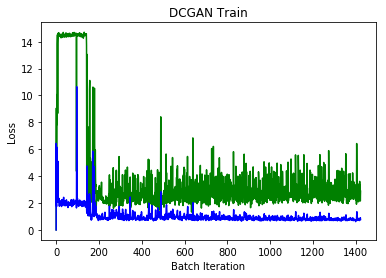

Epoch 179/190 :
     Batch 1/8 generator loss | discriminator loss : 2.4370954 | 0.76304394 - batch took 6.848134756088257 s.
     Batch 2/8 generator loss | discriminator loss : 2.333459 | 0.7665544 - batch took 6.497686147689819 s.
     Batch 3/8 generator loss | discriminator loss : 2.3854506 | 0.6733867 - batch took 6.623631000518799 s.
     Batch 4/8 generator loss | discriminator loss : 2.756326 | 0.72097623 - batch took 6.811845779418945 s.
     Batch 5/8 generator loss | discriminator loss : 2.9497764 | 0.9208294 - batch took 6.813211679458618 s.
     Batch 6/8 generator loss | discriminator loss : 2.1897264 | 0.74864423 - batch took 7.032444953918457 s.
     Batch 7/8 generator loss | discriminator loss : 7.1054974 | 1.1435463 - batch took 6.675720453262329 s.
     Batch 8/8 generator loss | discriminator loss : 3.937767 | 1.4511443 - batch took 6.816691160202026 s.


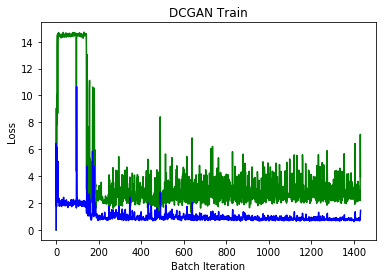

Epoch 180/190 :
     Batch 1/8 generator loss | discriminator loss : 3.1307917 | 1.0065981 - batch took 6.573343753814697 s.
     Batch 2/8 generator loss | discriminator loss : 2.8869982 | 0.76282173 - batch took 6.507949590682983 s.
     Batch 3/8 generator loss | discriminator loss : 1.9430035 | 0.7742264 - batch took 7.117932319641113 s.
     Batch 4/8 generator loss | discriminator loss : 2.446198 | 0.75725055 - batch took 7.500402450561523 s.
     Batch 5/8 generator loss | discriminator loss : 2.3256762 | 0.73948085 - batch took 7.628659725189209 s.
     Batch 6/8 generator loss | discriminator loss : 2.5901194 | 0.7514859 - batch took 6.5891807079315186 s.
     Batch 7/8 generator loss | discriminator loss : 2.327491 | 0.84683603 - batch took 6.832213401794434 s.
     Batch 8/8 generator loss | discriminator loss : 1.8704224 | 0.7431246 - batch took 6.401278495788574 s.


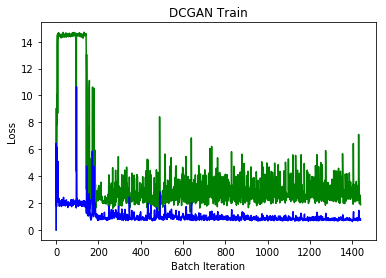

Epoch 181/190 :
     Batch 1/8 generator loss | discriminator loss : 2.6751223 | 0.73808545 - batch took 6.699434280395508 s.
     Batch 2/8 generator loss | discriminator loss : 2.53892 | 0.729001 - batch took 6.9854371547698975 s.
     Batch 3/8 generator loss | discriminator loss : 2.3911169 | 0.75279075 - batch took 6.526518106460571 s.
     Batch 4/8 generator loss | discriminator loss : 2.363573 | 0.69346976 - batch took 7.192163944244385 s.
     Batch 5/8 generator loss | discriminator loss : 2.3169985 | 0.8350234 - batch took 6.5430591106414795 s.
     Batch 6/8 generator loss | discriminator loss : 2.6064222 | 0.68886334 - batch took 7.189072608947754 s.
     Batch 7/8 generator loss | discriminator loss : 1.8934262 | 0.7330348 - batch took 6.941814184188843 s.
     Batch 8/8 generator loss | discriminator loss : 2.2552707 | 0.77258164 - batch took 7.408919811248779 s.


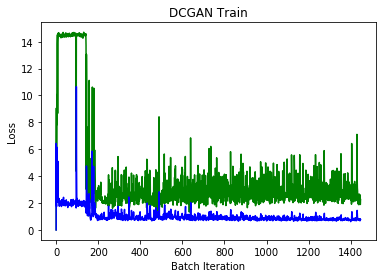

Epoch 182/190 :
     Batch 1/8 generator loss | discriminator loss : 2.4837666 | 0.67756104 - batch took 6.66472864151001 s.
     Batch 2/8 generator loss | discriminator loss : 2.9980297 | 0.7090354 - batch took 6.645964860916138 s.
     Batch 3/8 generator loss | discriminator loss : 2.217006 | 0.6758748 - batch took 6.757983446121216 s.
     Batch 4/8 generator loss | discriminator loss : 3.1410499 | 0.7404463 - batch took 6.546806812286377 s.
     Batch 5/8 generator loss | discriminator loss : 2.3351824 | 0.7732785 - batch took 7.156917572021484 s.
     Batch 6/8 generator loss | discriminator loss : 3.7035933 | 0.80401266 - batch took 6.665319919586182 s.
     Batch 7/8 generator loss | discriminator loss : 2.6088028 | 0.80800784 - batch took 6.857438564300537 s.
     Batch 8/8 generator loss | discriminator loss : 5.8788304 | 1.0257224 - batch took 6.810538291931152 s.


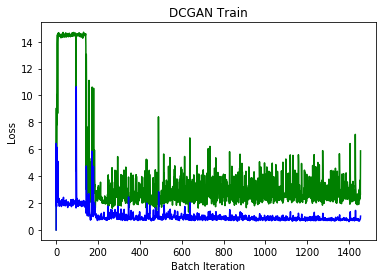

Epoch 183/190 :
     Batch 1/8 generator loss | discriminator loss : 4.756623 | 1.176149 - batch took 6.489043951034546 s.
     Batch 2/8 generator loss | discriminator loss : 1.8560557 | 0.8177297 - batch took 6.934174060821533 s.
     Batch 3/8 generator loss | discriminator loss : 3.2913773 | 0.9496584 - batch took 6.72499418258667 s.
     Batch 4/8 generator loss | discriminator loss : 2.8375134 | 0.8173522 - batch took 6.775719881057739 s.
     Batch 5/8 generator loss | discriminator loss : 2.392531 | 0.7448367 - batch took 6.592929363250732 s.
     Batch 6/8 generator loss | discriminator loss : 2.6562989 | 0.744507 - batch took 6.443477153778076 s.
     Batch 7/8 generator loss | discriminator loss : 2.2430222 | 0.73326814 - batch took 7.086472988128662 s.
     Batch 8/8 generator loss | discriminator loss : 3.1137981 | 0.78560805 - batch took 6.422513484954834 s.


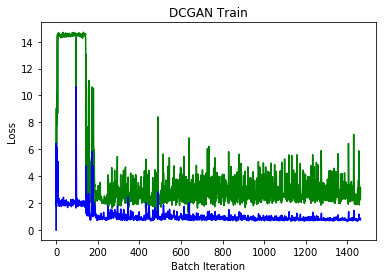

Epoch 184/190 :
     Batch 1/8 generator loss | discriminator loss : 2.3795328 | 0.82588017 - batch took 7.104212045669556 s.
     Batch 2/8 generator loss | discriminator loss : 4.0464354 | 0.84937227 - batch took 6.515222787857056 s.
     Batch 3/8 generator loss | discriminator loss : 3.0036504 | 0.9525466 - batch took 6.932818651199341 s.
     Batch 4/8 generator loss | discriminator loss : 2.6460955 | 0.72406876 - batch took 6.786166191101074 s.
     Batch 5/8 generator loss | discriminator loss : 2.3952982 | 0.709182 - batch took 6.887118577957153 s.
     Batch 6/8 generator loss | discriminator loss : 2.3694155 | 0.71915126 - batch took 7.346724987030029 s.
     Batch 7/8 generator loss | discriminator loss : 2.5702577 | 0.7299142 - batch took 6.605364084243774 s.
     Batch 8/8 generator loss | discriminator loss : 2.822486 | 0.68140465 - batch took 6.750491380691528 s.


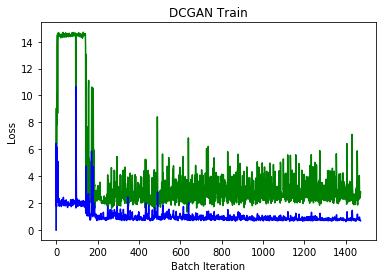

Epoch 185/190 :
     Batch 1/8 generator loss | discriminator loss : 2.4370925 | 0.6871992 - batch took 6.555689811706543 s.
     Batch 2/8 generator loss | discriminator loss : 3.7852764 | 0.80675054 - batch took 6.975475549697876 s.
     Batch 3/8 generator loss | discriminator loss : 2.5045395 | 0.83603126 - batch took 6.498543739318848 s.
     Batch 4/8 generator loss | discriminator loss : 4.6249275 | 0.94953394 - batch took 6.594363451004028 s.
     Batch 5/8 generator loss | discriminator loss : 3.6751451 | 0.94 - batch took 6.6104466915130615 s.
     Batch 6/8 generator loss | discriminator loss : 2.7494628 | 0.7886169 - batch took 6.822819232940674 s.
     Batch 7/8 generator loss | discriminator loss : 2.2870035 | 0.69556487 - batch took 6.773024082183838 s.
     Batch 8/8 generator loss | discriminator loss : 3.0820522 | 0.764146 - batch took 6.495234966278076 s.


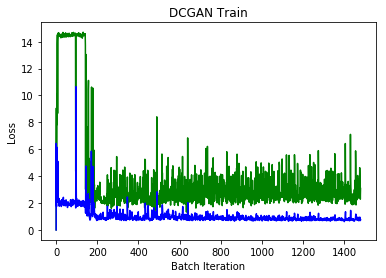

Epoch 186/190 :
     Batch 1/8 generator loss | discriminator loss : 2.2987776 | 0.7647228 - batch took 6.686948299407959 s.
     Batch 2/8 generator loss | discriminator loss : 3.0527296 | 0.8332771 - batch took 7.040788412094116 s.
     Batch 3/8 generator loss | discriminator loss : 2.6146488 | 0.6908155 - batch took 6.851402759552002 s.
     Batch 4/8 generator loss | discriminator loss : 2.68982 | 0.7525399 - batch took 6.5828773975372314 s.
     Batch 5/8 generator loss | discriminator loss : 2.612802 | 0.6797595 - batch took 6.767848014831543 s.
     Batch 6/8 generator loss | discriminator loss : 2.4713426 | 0.735772 - batch took 6.998641014099121 s.
     Batch 7/8 generator loss | discriminator loss : 3.4323535 | 0.74190354 - batch took 6.443418741226196 s.
     Batch 8/8 generator loss | discriminator loss : 2.1486268 | 0.7953291 - batch took 6.368487358093262 s.


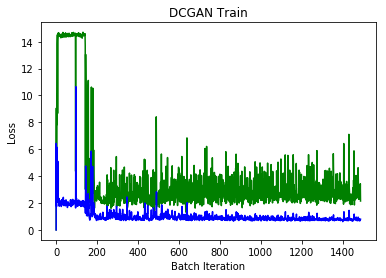

Epoch 187/190 :
     Batch 1/8 generator loss | discriminator loss : 5.355327 | 0.9513334 - batch took 6.515815019607544 s.
     Batch 2/8 generator loss | discriminator loss : 3.8442209 | 1.0319086 - batch took 6.598556041717529 s.
     Batch 3/8 generator loss | discriminator loss : 2.2979507 | 0.7365373 - batch took 6.767339468002319 s.
     Batch 4/8 generator loss | discriminator loss : 3.390882 | 0.7896923 - batch took 6.906182050704956 s.
     Batch 5/8 generator loss | discriminator loss : 2.3278518 | 0.7609731 - batch took 6.795602321624756 s.
     Batch 6/8 generator loss | discriminator loss : 3.417498 | 0.76702464 - batch took 6.590529680252075 s.
     Batch 7/8 generator loss | discriminator loss : 2.355321 | 0.7853762 - batch took 6.6211302280426025 s.
     Batch 8/8 generator loss | discriminator loss : 3.0342703 | 0.76747984 - batch took 6.6527228355407715 s.


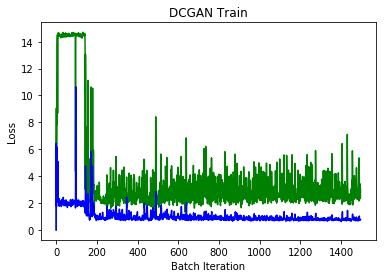

Epoch 188/190 :
     Batch 1/8 generator loss | discriminator loss : 2.39403 | 0.76607585 - batch took 6.591951370239258 s.
     Batch 2/8 generator loss | discriminator loss : 3.4015949 | 0.8556942 - batch took 6.67245626449585 s.
     Batch 3/8 generator loss | discriminator loss : 2.2858233 | 0.8700624 - batch took 6.531611204147339 s.
     Batch 4/8 generator loss | discriminator loss : 4.82256 | 0.9284363 - batch took 7.202389717102051 s.
     Batch 5/8 generator loss | discriminator loss : 3.044862 | 0.99631995 - batch took 6.5755674839019775 s.
     Batch 6/8 generator loss | discriminator loss : 4.184643 | 0.98839355 - batch took 6.3590099811553955 s.
     Batch 7/8 generator loss | discriminator loss : 3.4638665 | 0.7551757 - batch took 6.8495306968688965 s.
     Batch 8/8 generator loss | discriminator loss : 1.9474018 | 0.7530926 - batch took 6.679841041564941 s.


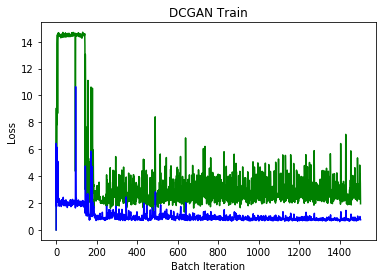

Epoch 189/190 :
     Batch 1/8 generator loss | discriminator loss : 2.9480784 | 0.7885822 - batch took 6.859871864318848 s.
     Batch 2/8 generator loss | discriminator loss : 2.535642 | 0.71270823 - batch took 6.718567848205566 s.
     Batch 3/8 generator loss | discriminator loss : 2.460858 | 0.73126936 - batch took 6.394764184951782 s.
     Batch 4/8 generator loss | discriminator loss : 2.297841 | 0.7101269 - batch took 6.572668075561523 s.
     Batch 5/8 generator loss | discriminator loss : 2.3347807 | 0.7216537 - batch took 6.5980224609375 s.
     Batch 6/8 generator loss | discriminator loss : 2.7291315 | 0.6883805 - batch took 6.714257001876831 s.
     Batch 7/8 generator loss | discriminator loss : 2.1457548 | 0.7365762 - batch took 6.583334922790527 s.
     Batch 8/8 generator loss | discriminator loss : 2.5838768 | 0.81659114 - batch took 6.682799577713013 s.


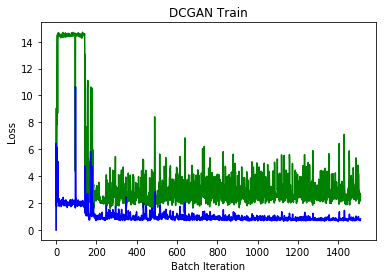

Epoch 190/190 :
     Batch 1/8 generator loss | discriminator loss : 2.2283902 | 0.69566655 - batch took 6.72443413734436 s.
     Batch 2/8 generator loss | discriminator loss : 3.5464034 | 0.75748086 - batch took 6.787469863891602 s.
     Batch 3/8 generator loss | discriminator loss : 2.3490047 | 0.82802504 - batch took 6.8580405712127686 s.
     Batch 4/8 generator loss | discriminator loss : 3.7495081 | 1.0023763 - batch took 6.627187728881836 s.
     Batch 5/8 generator loss | discriminator loss : 3.1759002 | 0.82785845 - batch took 6.777478218078613 s.
     Batch 6/8 generator loss | discriminator loss : 2.664065 | 0.6907207 - batch took 6.856228351593018 s.
     Batch 7/8 generator loss | discriminator loss : 1.9611478 | 0.712796 - batch took 6.688864469528198 s.
     Batch 8/8 generator loss | discriminator loss : 3.0800097 | 0.82006997 - batch took 6.501624345779419 s.


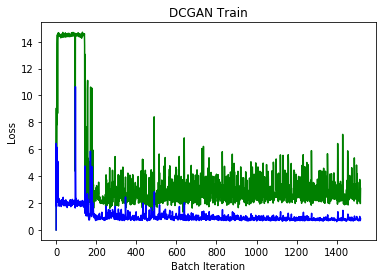

<Figure size 432x288 with 0 Axes>

In [3]:
dataset_path = 'images'
batch_size = 50
image_shape = (64, 64, 3)
epochs = 190
train_dcgan(batch_size, epochs,image_shape, dataset_path)

In [53]:
from keras.models import load_model
# Generate noise
generator = load_model("models/generator_epoch189.hdf5")



In [58]:
# Generate images
noise = np.random.normal(0, 1, size=(64,) + (1, 1, 100))
generated_images = generator.predict(noise)
an_image = generated_images[0]
an_image += 1
an_image *= 127.5

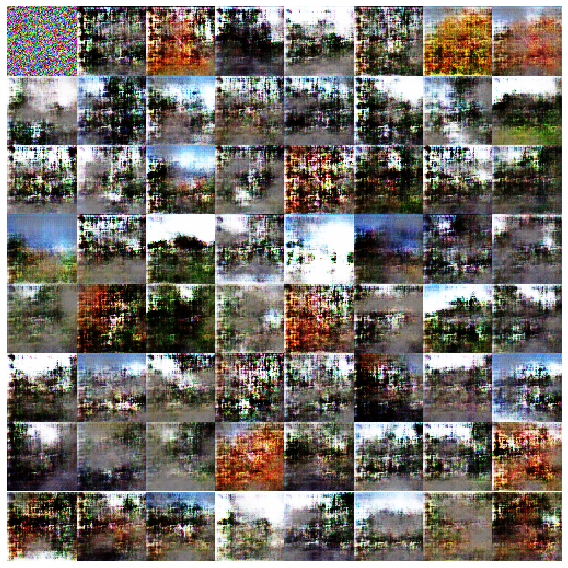

In [59]:
plt.figure(figsize=(8, 8), num=2)
gs1 = gridspec.GridSpec(8, 8)
gs1.update(wspace=0, hspace=0)

for i in range(64):
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    image = generated_images[i, :, :, :]
    image += 1
    image *= 127.5
    fig = plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


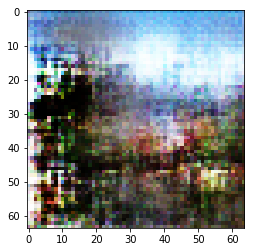

In [62]:
img = generated_images[18,:,:,:]
fig = plt.imshow(img.astype(np.uint8))
plt.show()